In [1]:
from collections import OrderedDict
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image

from IPython import display

print(torch.__version__)
print(torchvision.__version__)


2.0.0
0.15.1


In [2]:
def try_gpu():
    if torch.cuda.device_count() > 0:
        return torch.device("cuda:0")

    return torch.device("cpu")

device = try_gpu()
device


device(type='cuda', index=0)

In [3]:
train_data = torchvision.datasets.CIFAR10("~/data", download=True)


100%|██████████| 170498071/170498071 [00:05<00:00, 29009028.69it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data


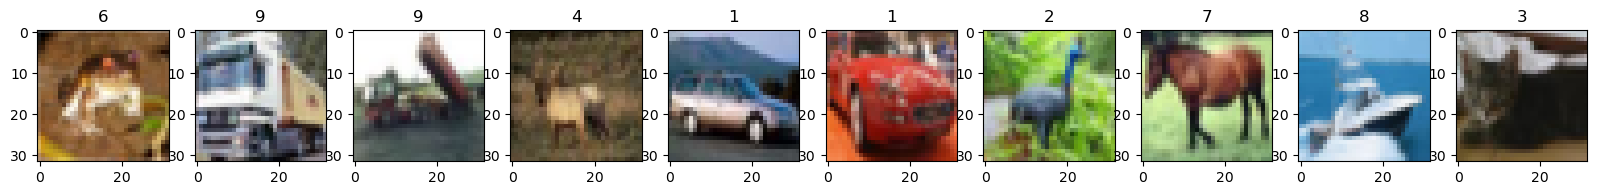

In [4]:
def plt_images(dataset, figsize=(20, 8)):
    _, axs = plt.subplots(1, 10, figsize=figsize)
    
    for ax, (im, label) in zip(axs, dataset):
        ax.imshow(im)
        ax.set_title(label)
        
    plt.plot()
    
plt_images(train_data)    


## Helpers

In [5]:
def load_cifar(data_path, batch_size, shuffle=True, num_workers=6, transformations=None,
               train_size=None, mode="CIFAR10", train=True, seed=42):
    
    transforms = torchvision.transforms.Compose(transformations)
    
    if mode == "CIFAR10":
        data = torchvision.datasets.CIFAR10(root=data_path, transform=transforms, train=train)
        
    elif mode == "CIFAR100":
        data = torchvision.datasets.CIFAR100(root=data_path, transform=transforms, train=train)
        
    if train_size is not None:
        _train_size = int(len(data) * train_size)
        _val_size = len(data) - _train_size

        print("Train dataset size:", _train_size, "test dataset size:", _val_size)
        
        gen = torch.Generator().manual_seed(seed)
        data_train, data_val = random_split(data, [_train_size, _val_size], generator=gen)

        return (
            DataLoader(data_train, batch_size, shuffle, num_workers=num_workers),
            DataLoader(data_val, batch_size, shuffle, num_workers=num_workers)
        )

    return DataLoader(data, batch_size, shuffle, num_workers=num_workers)


BATCH_SIZE = 64

In [6]:
class MetricSaver:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def accuracy(y_true, y_pred):
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)

    temp = y_pred.type(y_true.dtype) == y_true
    return float(temp.type(y_true.dtype).sum())


def eval_model_accuracy(net, data_iter, device=None):
    device = device if device else try_gpu()

    if isinstance(net, torch.nn.Module):
        net.eval()
    else:
        raise ValueError(f"Network must inherit from nn.Module, got {type(net)}")

    metrics = MetricSaver(2)

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)

            metrics.add(accuracy(y, net(X)), y.numel())

    return metrics[0] / metrics[1]


class Plotter:
    def __init__(self, x_label=None, y_label=None, legend=None, x_lim=None, y_lim=None,
                 x_scale="linear", y_scale="linear", linestyles=('-', 'm--', 'g-.', 'r:'),
                 n_rows=1, n_cols=1, figsize=(8, 6)):

        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if n_rows * n_cols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: self.set_axes(self.axes[0],
                                                 x_label, y_label, x_lim, y_lim, x_scale, y_scale, legend)
        self.X, self.Y, self.fmts = None, None, linestyles


    @staticmethod
    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib."""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()


    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()

    def plot(self):
        display.display(self.fig)


## Training loop

In [39]:
def init_weights_(layer):
    if isinstance(layer, torch.nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight, mode="fan_out")
    elif isinstance(layer, (nn.BatchNorm2d)):
        nn.init.constant_(layer.weight, 1)
        nn.init.constant_(layer.bias, 0)
    elif isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight)


def lr_decay(optim, epoch, mode="vanilla"):
    if mode == "vanilla":
        if epoch < 80:
            lr = 0.1
        elif 80 <= epoch < 120:
            lr = 0.01
        elif 120 <= epoch < 200:
            lr = 0.001
        elif 200 <= epoch < 240:
            lr = 0.0001
        else:
            lr = 0.000011

    if mode == "sr":
        if epoch < 40:
            lr = 0.1
        elif 40 <= epoch < 60:
            lr = 0.02
        elif 60 <= epoch < 80:
            lr = 0.004
        else:
            lr = 0.0008

    for param_group in optim.param_groups:
        param_group["lr"] = lr

    return lr


def train_model(
    net, train_iter, test_iter, epochs, optim, loss=None, device=None,
    init_weights=False, debug=False, save_optim=None, mode="vanilla",
    verbose_interval=5, scheduler=None
    ):
    # Init stuff
    if init_weights:
        net.apply(init_weights_)

    loss = torch.nn.CrossEntropyLoss() if not loss else loss
    plotter = Plotter(x_label="epochs", y_label="accuracy", x_lim=[1, epochs], legend=["train loss", "train acc", "test acc"])

    num_batches = len(train_iter)

    device = try_gpu() if not device else device
    print(f"Training on {device}")
    net.to(device)

    # Training loop
    for epoch in range(epochs):

        metrics = MetricSaver(3)
        net.train()

        for i, (X, y) in enumerate(tqdm(train_iter)):
            optim.zero_grad()
            X, y = X.to(device), y.to(device)
            y_pred = net(X)
            l = loss(y_pred, y)
            l.backward()
#             torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2., norm_type=2)
            optim.step()

            with torch.no_grad():
                metrics.add(l * X.shape[0], accuracy(y, y_pred), X.shape[0])
                train_loss = metrics[0] / metrics[2]
                train_acc = metrics[1] / metrics[2]

            if (i + 1) % num_batches == 50 or i == num_batches - 1:
                plotter.add(epoch + (i + 1) / num_batches,
                            (train_loss, train_acc, None))

        test_accuracy = eval_model_accuracy(net, test_iter, device)
        plotter.add(epoch + 1, (None, None, test_accuracy))

        if (epoch + 1) % verbose_interval == 0 or epoch == 0 or epoch == (epochs - 1):
                print(f"epoch: {epoch}", f'train loss: {train_loss:.3f}, train accuracy: {train_acc:.3f}, '
                    f"test accuracy {test_accuracy:.3f}, lr: {optim.param_groups[0]['lr']}")
                plotter.plot()

        if debug:
            break
        
        if scheduler is not None:
            scheduler.step()

    if save_optim is not None:
        torch.save(optim.state_dict(), save_optim)
        print(f"Optimizer saved to {save_optim}")


## Vanilla ResNet-50

In [40]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, padding=1):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=False)
        self.bn_1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(out_channels)

        self.res_con = None
        if stride != 1 and in_channels != out_channels:
            self.res_con = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, X):
        input_ = X
        out = self.bn_1(self.conv_1(X))
        out = self.relu(out)
        out = self.bn_2(self.conv_2(out))

        if self.res_con is not None:
            out += self.res_con(input_)

        out = self.relu(out)
        return out

In [41]:
class ResNet(nn.Module):
    def __init__(self, input_channels, out_channels, layers, num_classes=10):
        self.hidden_size = out_channels

        super().__init__()
        self.conv_1 = nn.Conv2d(
            input_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn_1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.res_1 = self.make_res_block(out_channels, out_channels, layers[0], 1)
        self.res_2 = self.make_res_block(out_channels, 128, layers[1], 2)
        self.res_3 = self.make_res_block(128, 256, layers[2], 2)
        self.res_4 = self.make_res_block(256, 512, layers[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flat = nn.Flatten()
        self.out = nn.Linear(512, num_classes, bias=False)

    def make_res_block(self, input_channels, output_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResBlock(self.hidden_size, output_channels, stride))
            self.hidden_size = output_channels

        return nn.Sequential(*layers)

    def forward(self, X):
        out = self.bn_1(self.conv_1(X))
        out = self.relu(out)

        out = self.res_1(out)
        out = self.res_2(out)
        out = self.res_3(out)
        out = self.res_4(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.out(out)

        return out


In [42]:
_X = torch.randn((2, 3, 32, 32))
resnet_18 = ResNet(3, 64, [2, 2, 2, 2])

print(sum([p.nelement() for p in resnet_18.parameters()]))
resnet_18(_X).shape


11173952


torch.Size([2, 10])

Training on cuda:0


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 0 train loss: 3.104, train accuracy: 0.118, test accuracy 0.179, lr: 0.1


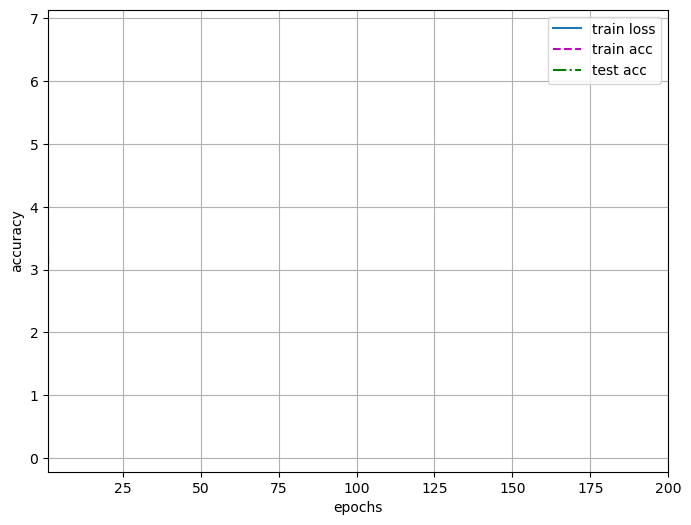

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 1 train loss: 2.015, train accuracy: 0.239, test accuracy 0.294, lr: 0.09999383162408304


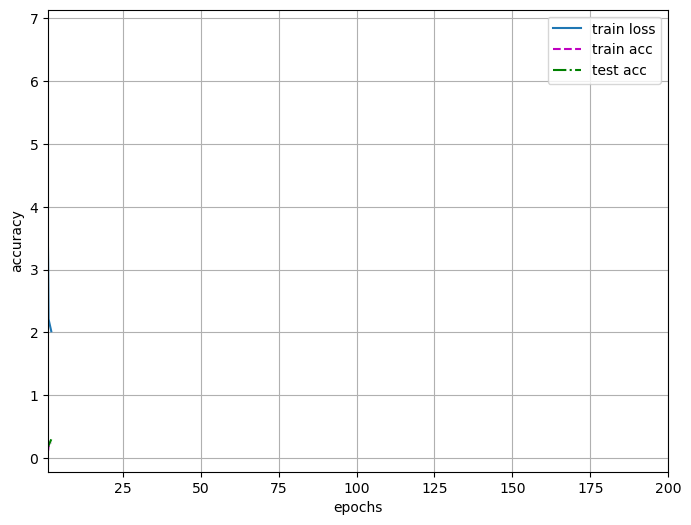

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 2 train loss: 1.786, train accuracy: 0.327, test accuracy 0.388, lr: 0.09997532801828658


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 3 train loss: 1.648, train accuracy: 0.384, test accuracy 0.414, lr: 0.09994449374809851


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 4 train loss: 1.524, train accuracy: 0.437, test accuracy 0.476, lr: 0.09990133642141359


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 5 train loss: 1.362, train accuracy: 0.504, test accuracy 0.506, lr: 0.09984586668665642


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 6 train loss: 1.205, train accuracy: 0.569, test accuracy 0.584, lr: 0.09977809823015402


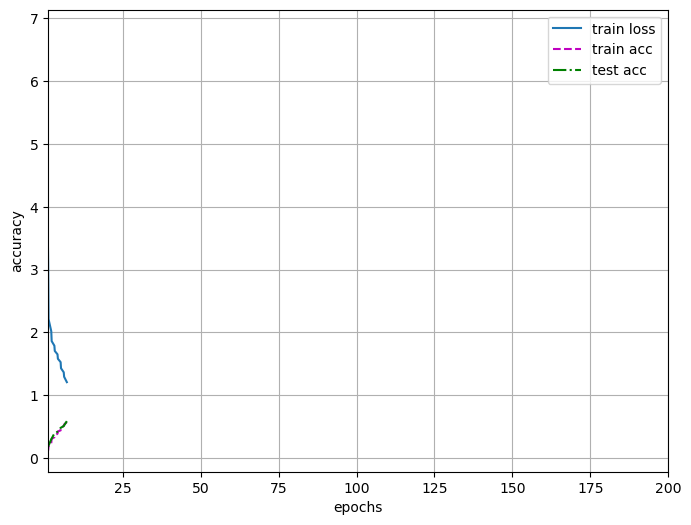

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 7 train loss: 1.052, train accuracy: 0.629, test accuracy 0.579, lr: 0.09969804777275901


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 8 train loss: 0.916, train accuracy: 0.680, test accuracy 0.587, lr: 0.09960573506572391


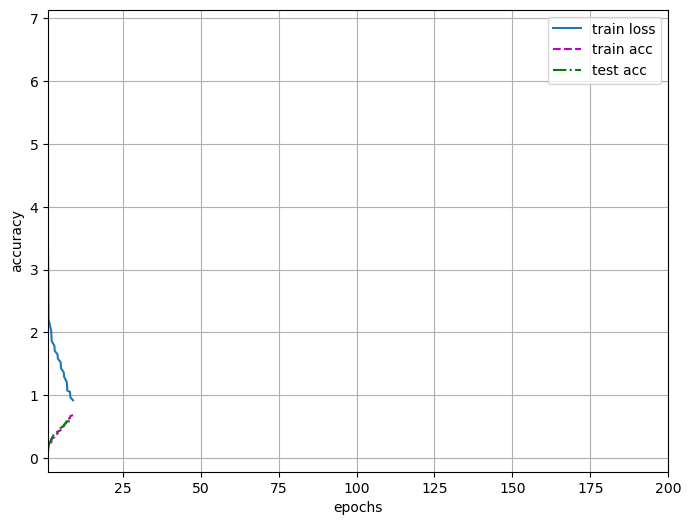

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 9 train loss: 0.822, train accuracy: 0.715, test accuracy 0.685, lr: 0.09950118288582789


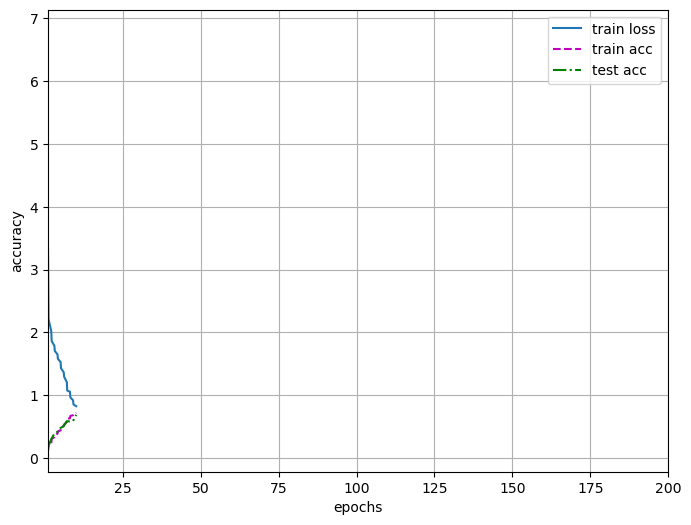

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 10 train loss: 0.745, train accuracy: 0.741, test accuracy 0.611, lr: 0.09938441702975691


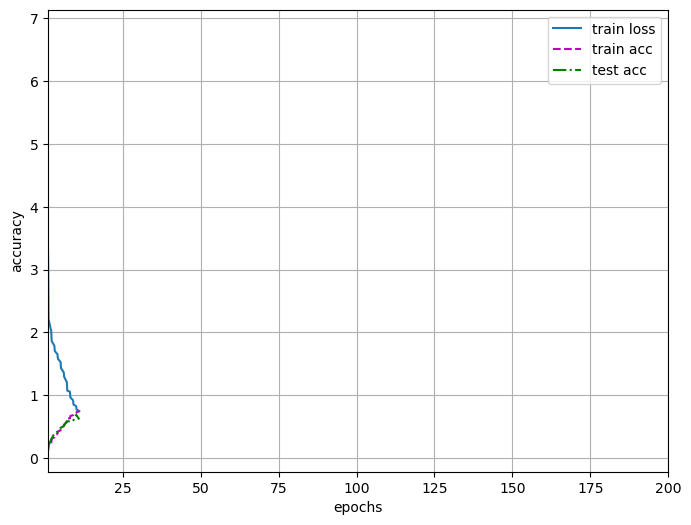

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 11 train loss: 0.694, train accuracy: 0.760, test accuracy 0.698, lr: 0.09925546630773871


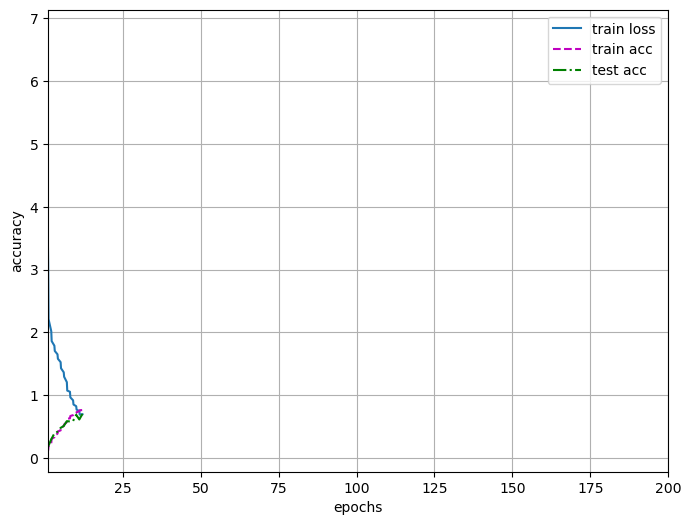

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 12 train loss: 0.646, train accuracy: 0.779, test accuracy 0.761, lr: 0.09911436253643445


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 13 train loss: 0.616, train accuracy: 0.788, test accuracy 0.709, lr: 0.0989611405310883


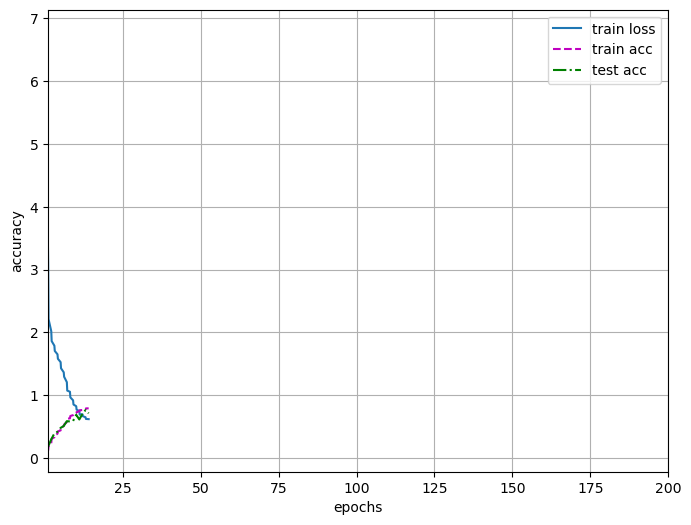

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 14 train loss: 0.597, train accuracy: 0.794, test accuracy 0.733, lr: 0.09879583809693739


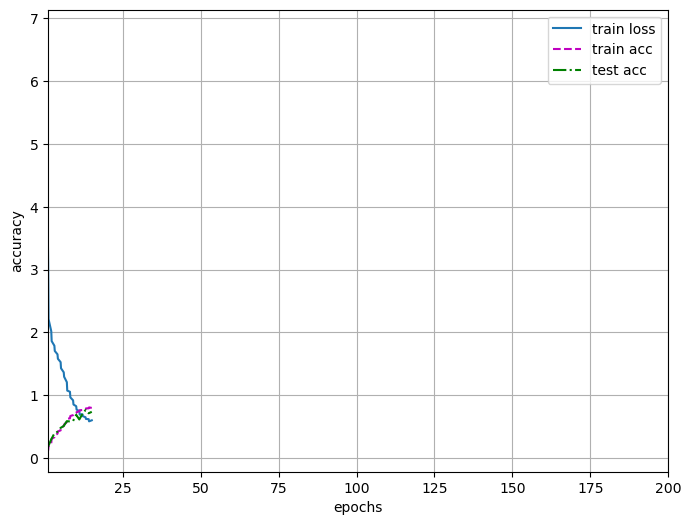

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 15 train loss: 0.576, train accuracy: 0.803, test accuracy 0.724, lr: 0.09861849601988384


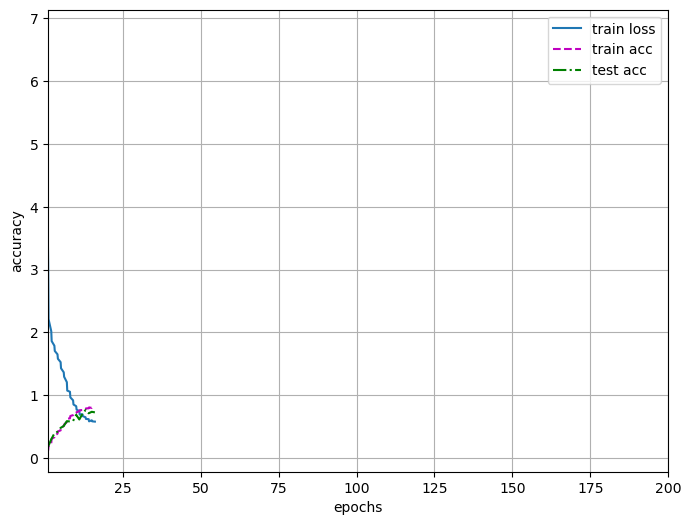

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 16 train loss: 0.553, train accuracy: 0.810, test accuracy 0.749, lr: 0.09842915805643157


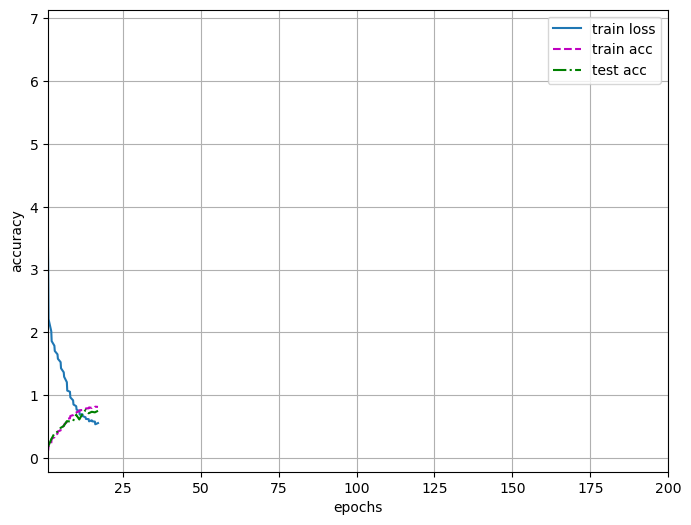

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 17 train loss: 0.541, train accuracy: 0.816, test accuracy 0.764, lr: 0.09822787092288993


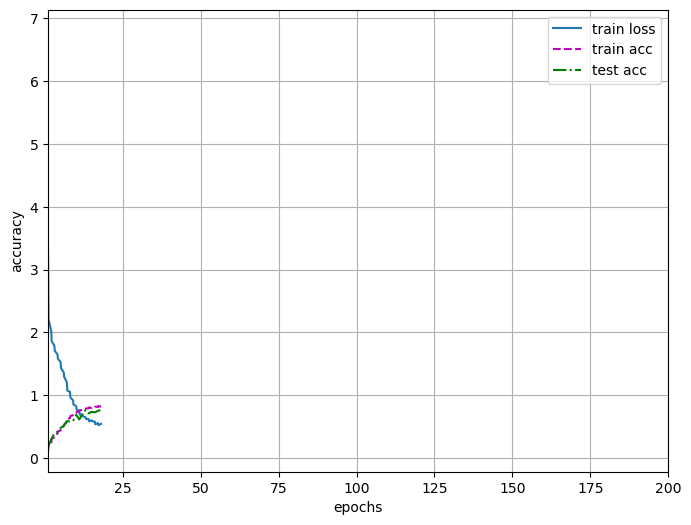

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 18 train loss: 0.522, train accuracy: 0.822, test accuracy 0.745, lr: 0.09801468428384717


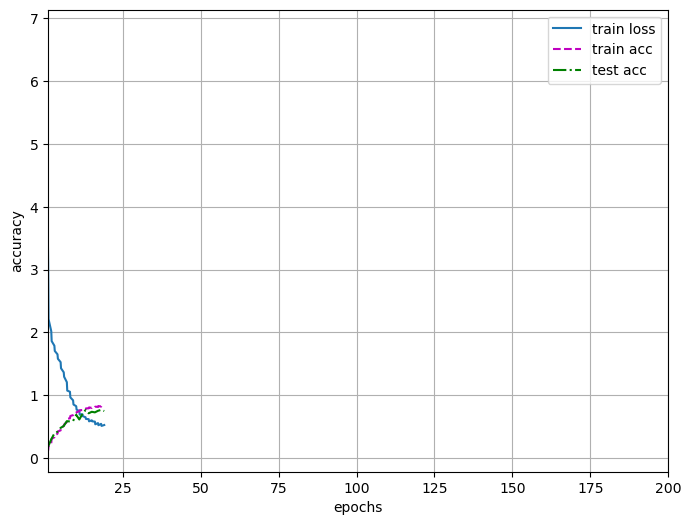

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 19 train loss: 0.510, train accuracy: 0.827, test accuracy 0.738, lr: 0.09778965073991652


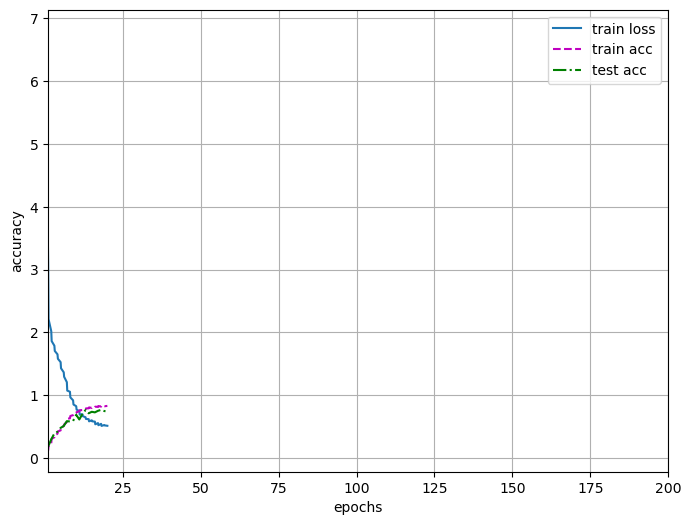

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 20 train loss: 0.504, train accuracy: 0.829, test accuracy 0.768, lr: 0.0975528258147577


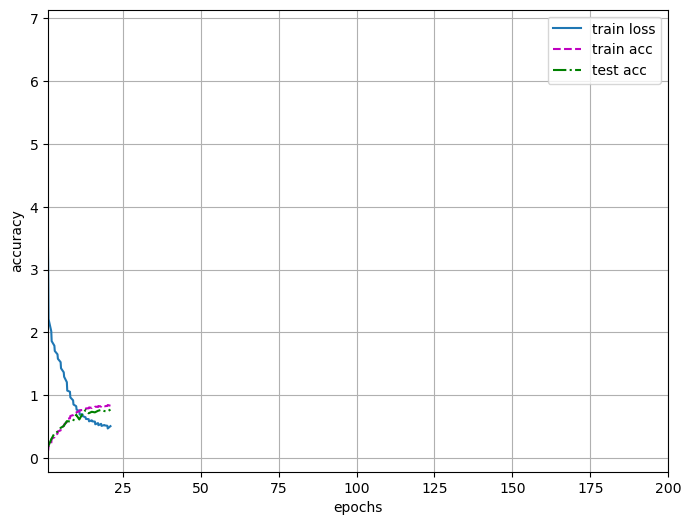

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 21 train loss: 0.484, train accuracy: 0.836, test accuracy 0.779, lr: 0.09730426794137728


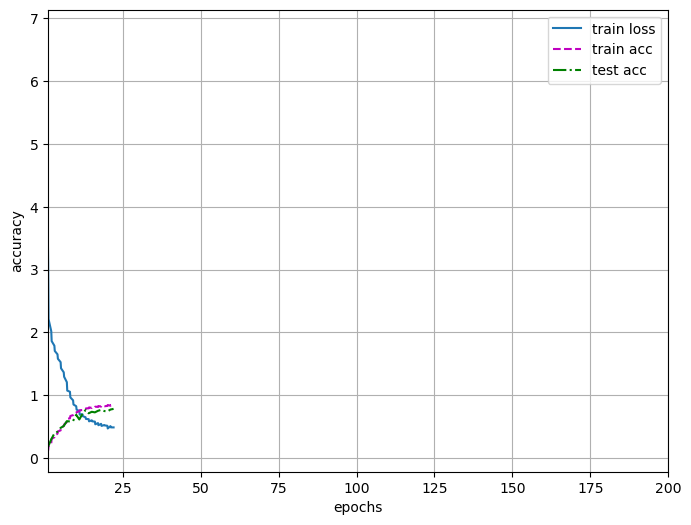

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 22 train loss: 0.486, train accuracy: 0.835, test accuracy 0.771, lr: 0.09704403844771128


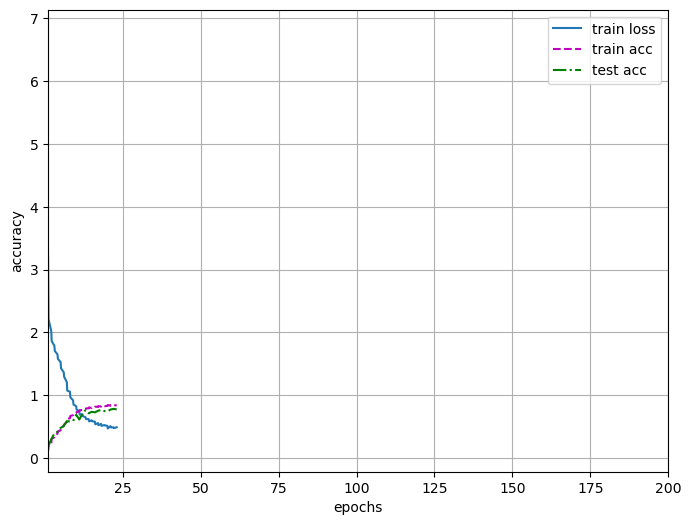

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 23 train loss: 0.477, train accuracy: 0.837, test accuracy 0.783, lr: 0.09677220154149338


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 24 train loss: 0.460, train accuracy: 0.844, test accuracy 0.743, lr: 0.09648882429441258


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 25 train loss: 0.461, train accuracy: 0.842, test accuracy 0.770, lr: 0.09619397662556435


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 26 train loss: 0.457, train accuracy: 0.843, test accuracy 0.806, lr: 0.09588773128419906


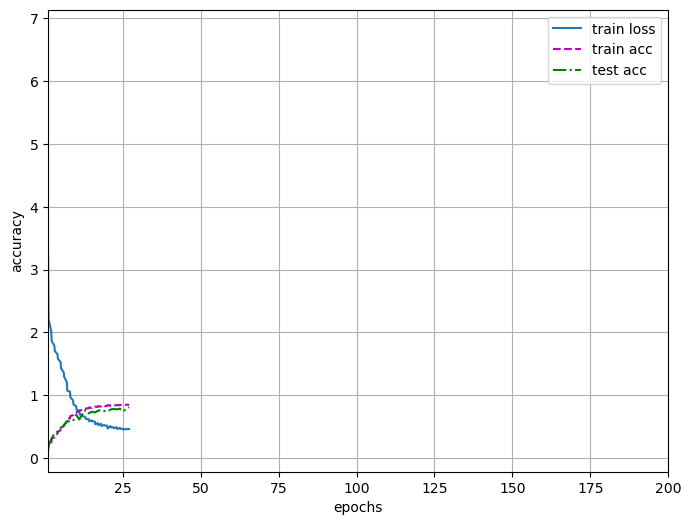

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 27 train loss: 0.450, train accuracy: 0.846, test accuracy 0.752, lr: 0.09557016383177226


  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 28 train loss: 0.442, train accuracy: 0.849, test accuracy 0.711, lr: 0.09524135262330098


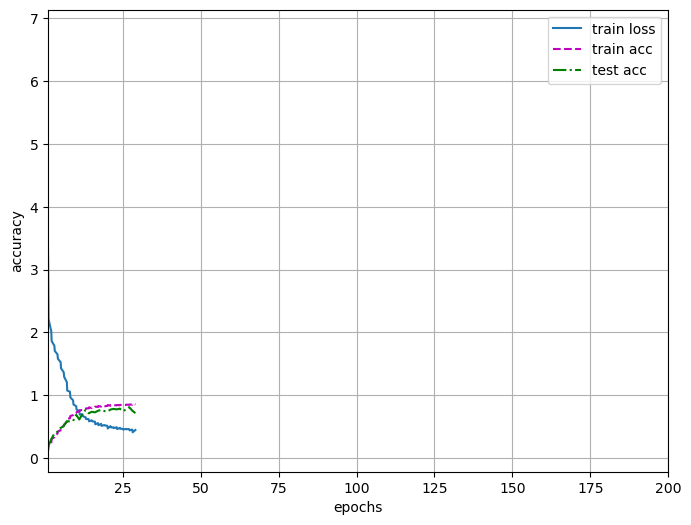

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

epoch: 29 train loss: 0.440, train accuracy: 0.849, test accuracy 0.809, lr: 0.09490137878803079


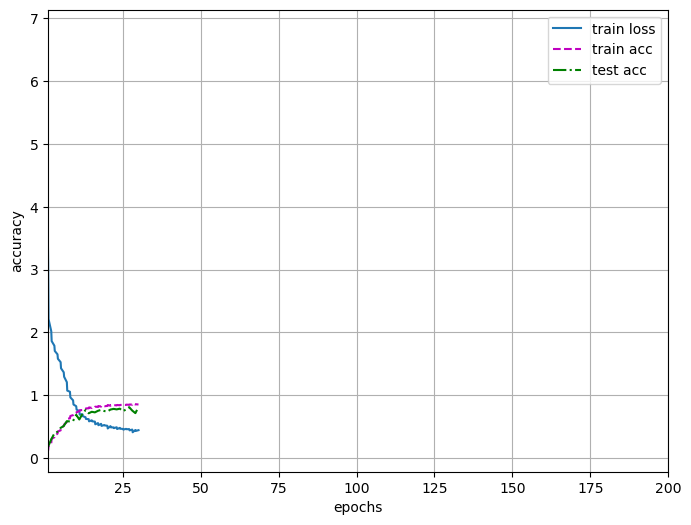

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 30 train loss: 0.432, train accuracy: 0.854, test accuracy 0.799, lr: 0.0945503262094184


  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 31 train loss: 0.428, train accuracy: 0.855, test accuracy 0.758, lr: 0.0941882815044347


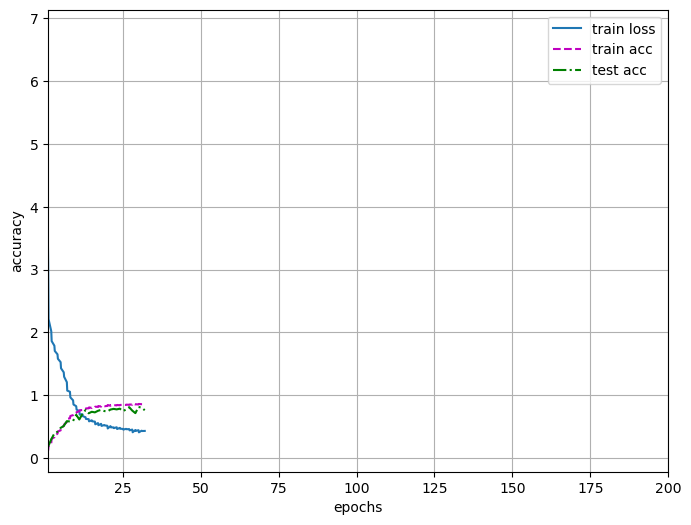

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 32 train loss: 0.421, train accuracy: 0.856, test accuracy 0.826, lr: 0.09381533400219319


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 33 train loss: 0.417, train accuracy: 0.858, test accuracy 0.748, lr: 0.09343157572190958


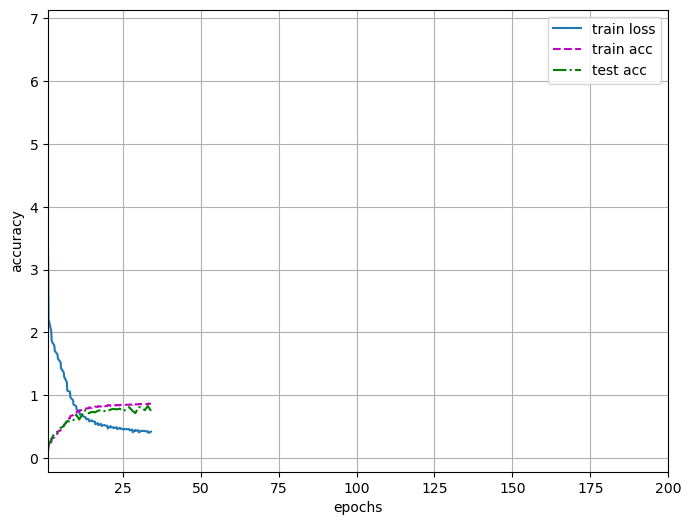

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 34 train loss: 0.416, train accuracy: 0.858, test accuracy 0.766, lr: 0.0930371013501972


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 35 train loss: 0.413, train accuracy: 0.860, test accuracy 0.787, lr: 0.09263200821770463


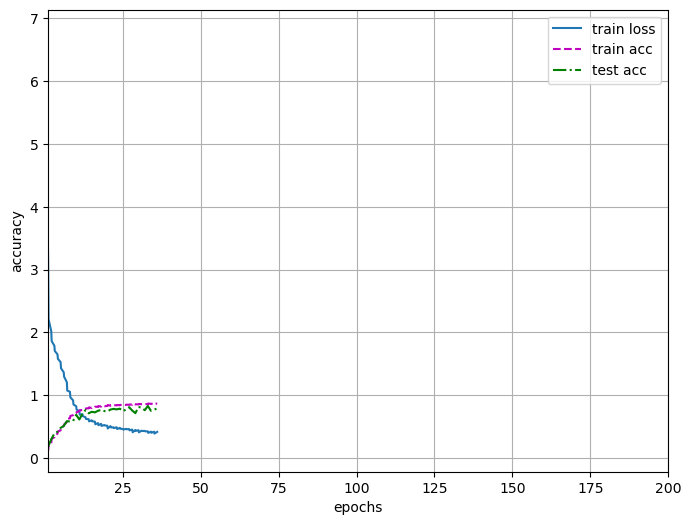

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 36 train loss: 0.410, train accuracy: 0.860, test accuracy 0.764, lr: 0.09221639627510078


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 37 train loss: 0.405, train accuracy: 0.863, test accuracy 0.818, lr: 0.09179036806841355


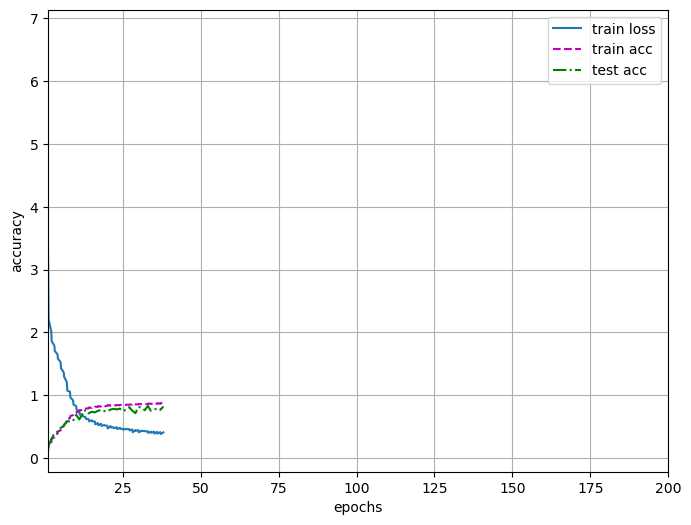

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 38 train loss: 0.400, train accuracy: 0.864, test accuracy 0.746, lr: 0.09135402871372812


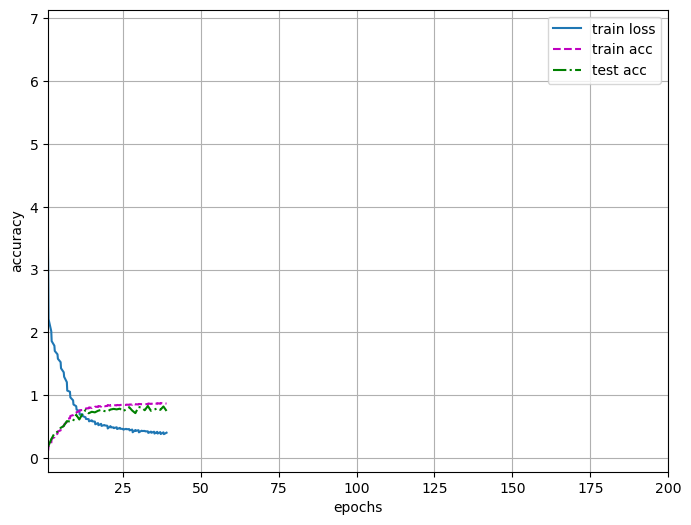

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 39 train loss: 0.394, train accuracy: 0.867, test accuracy 0.834, lr: 0.0909074858712512


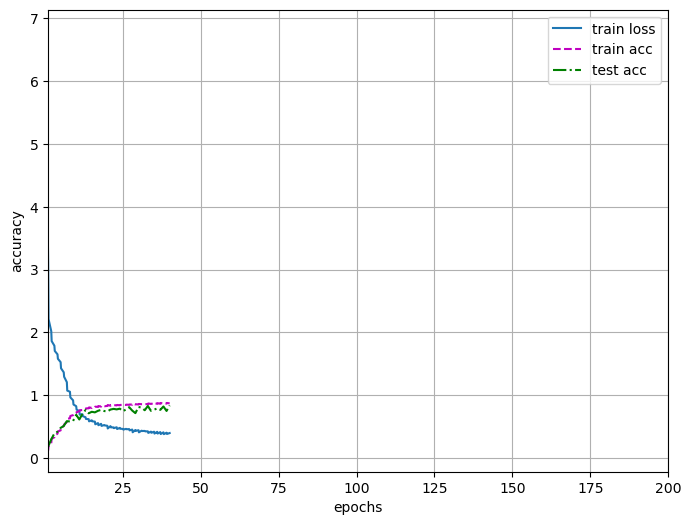

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 40 train loss: 0.389, train accuracy: 0.868, test accuracy 0.751, lr: 0.09045084971874741


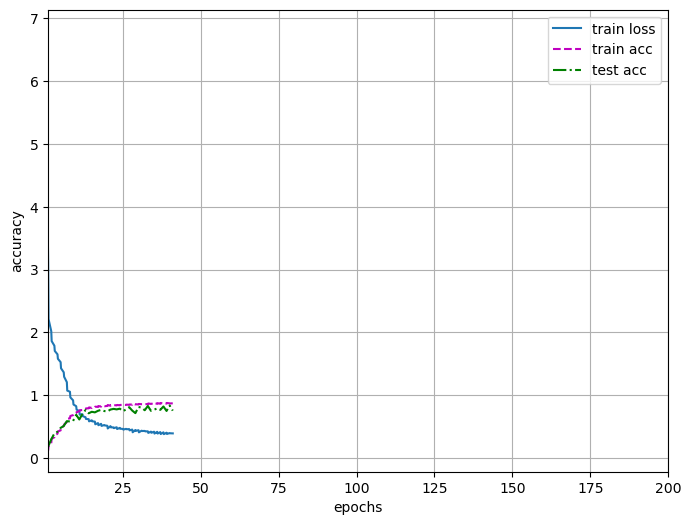

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 41 train loss: 0.387, train accuracy: 0.869, test accuracy 0.720, lr: 0.08998423292435458


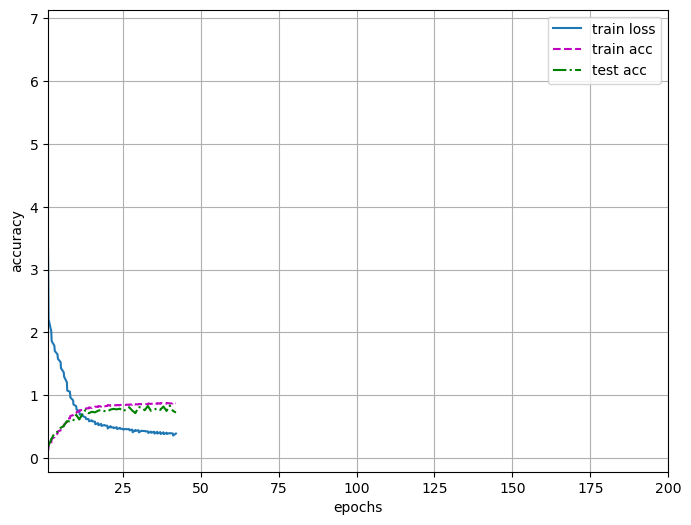

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 42 train loss: 0.386, train accuracy: 0.870, test accuracy 0.772, lr: 0.08950775061878455


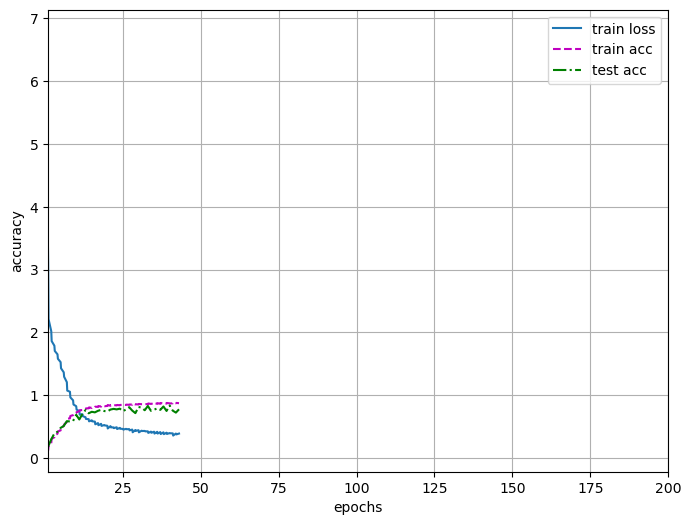

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 43 train loss: 0.379, train accuracy: 0.872, test accuracy 0.782, lr: 0.08902152036691653


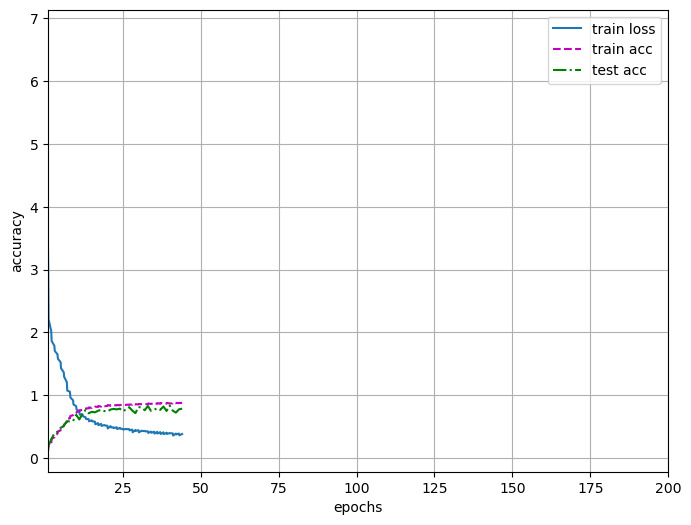

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 44 train loss: 0.376, train accuracy: 0.872, test accuracy 0.830, lr: 0.08852566213878951


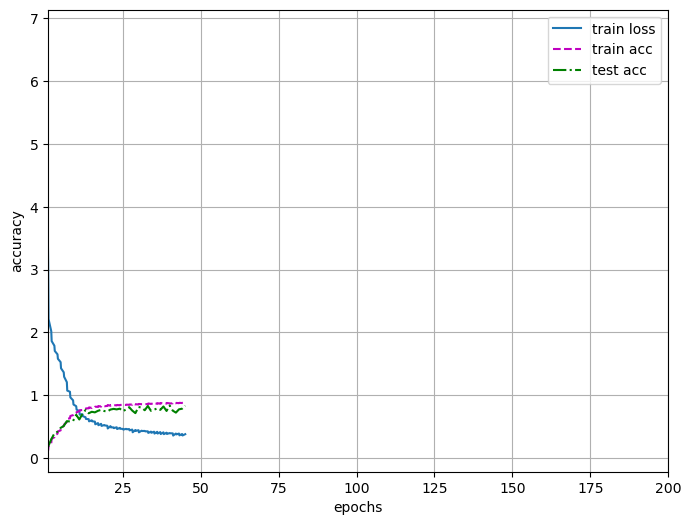

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 45 train loss: 0.372, train accuracy: 0.874, test accuracy 0.814, lr: 0.0880202982800016


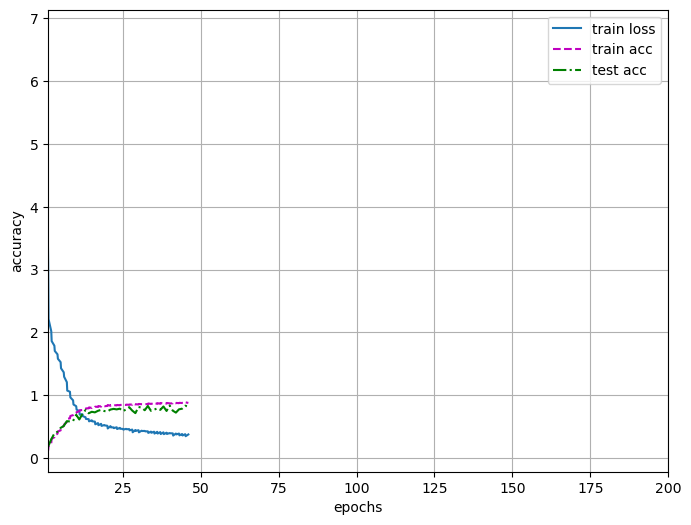

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 46 train loss: 0.366, train accuracy: 0.876, test accuracy 0.826, lr: 0.08750555348152303


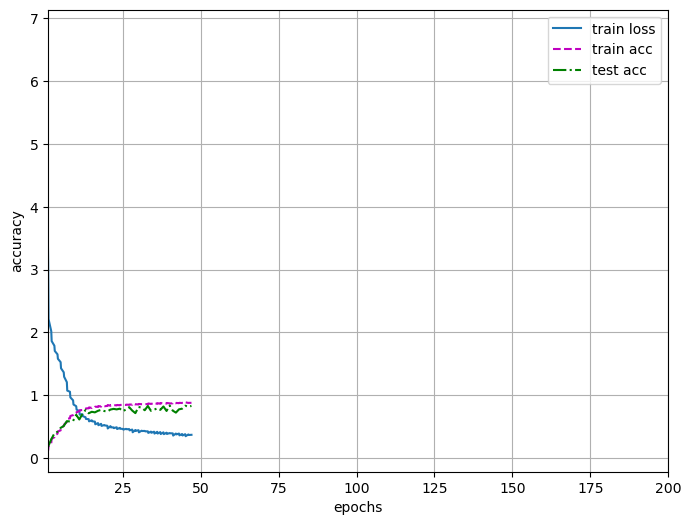

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 47 train loss: 0.375, train accuracy: 0.872, test accuracy 0.839, lr: 0.08698155474893052


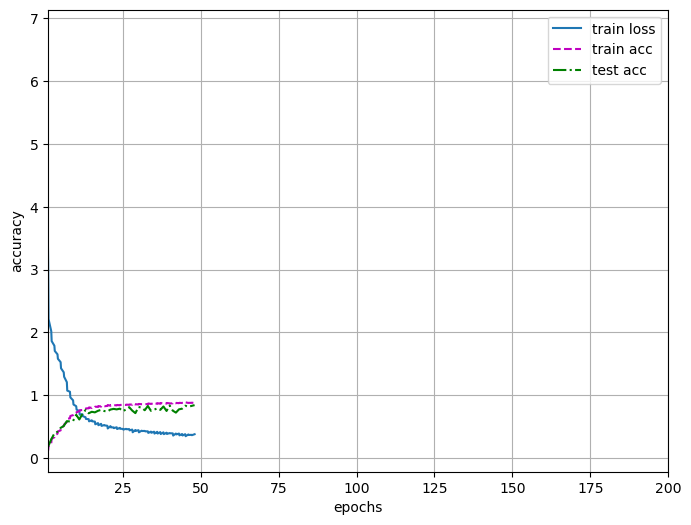

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 48 train loss: 0.363, train accuracy: 0.877, test accuracy 0.804, lr: 0.08644843137107061


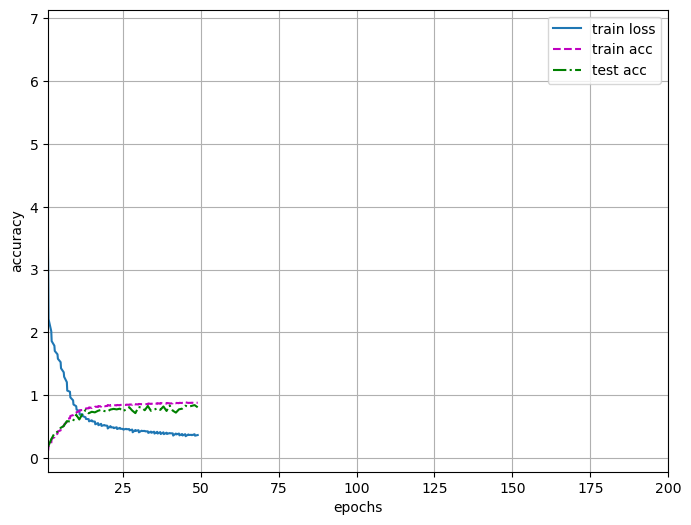

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 49 train loss: 0.362, train accuracy: 0.878, test accuracy 0.849, lr: 0.08590631488815947


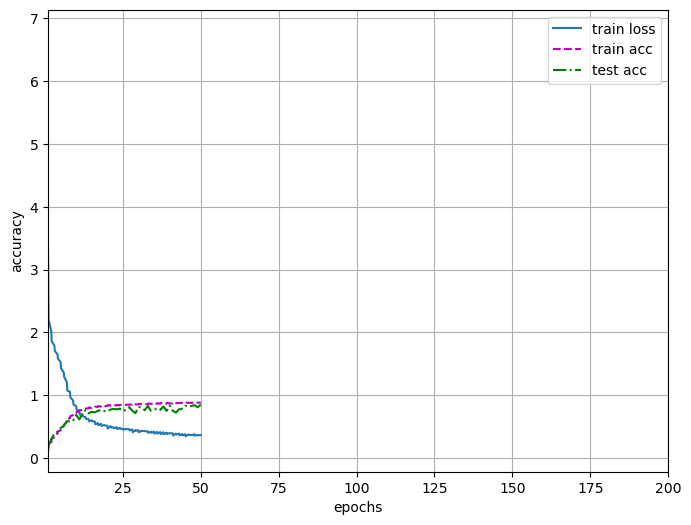

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 50 train loss: 0.364, train accuracy: 0.876, test accuracy 0.813, lr: 0.0853553390593274


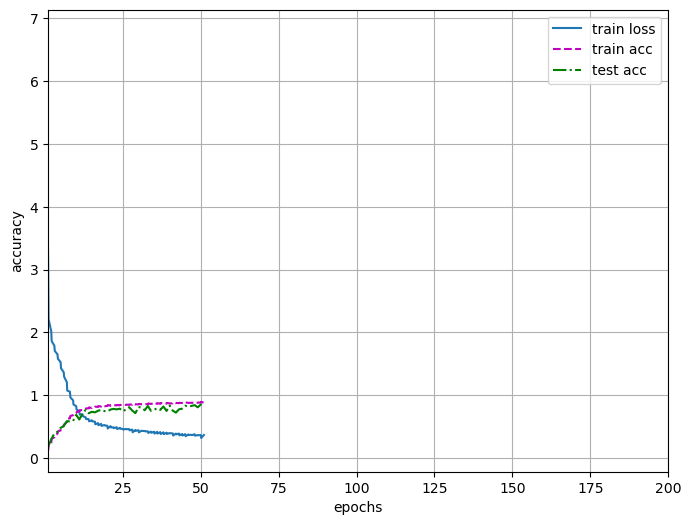

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 51 train loss: 0.359, train accuracy: 0.878, test accuracy 0.755, lr: 0.08479563982961574


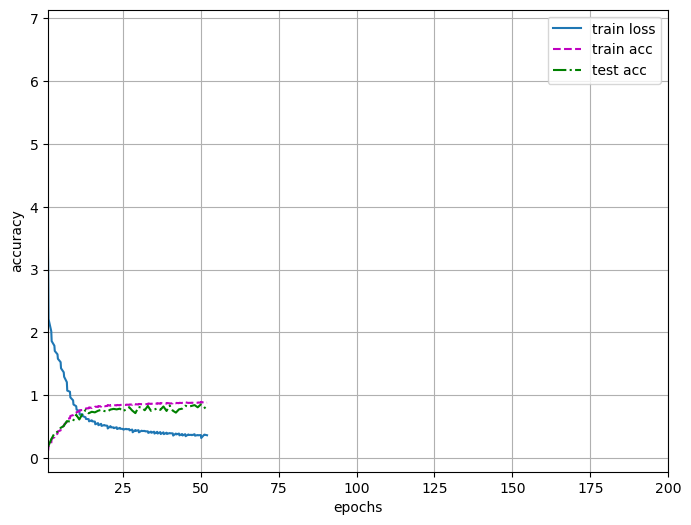

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 52 train loss: 0.362, train accuracy: 0.878, test accuracy 0.811, lr: 0.08422735529643446


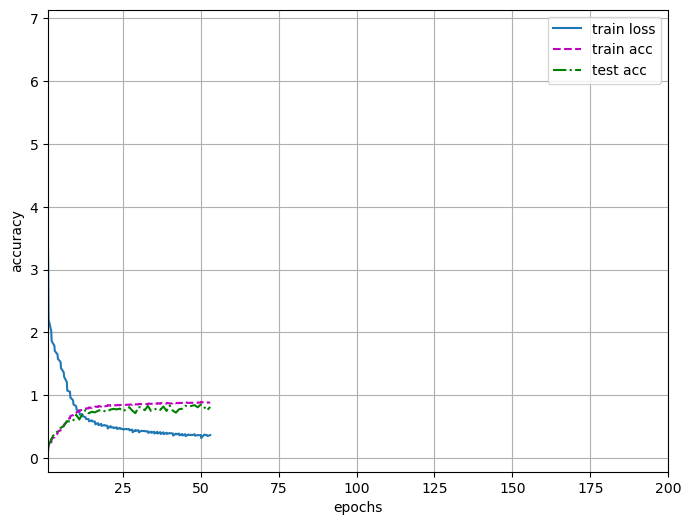

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 53 train loss: 0.349, train accuracy: 0.882, test accuracy 0.821, lr: 0.08365062567548869


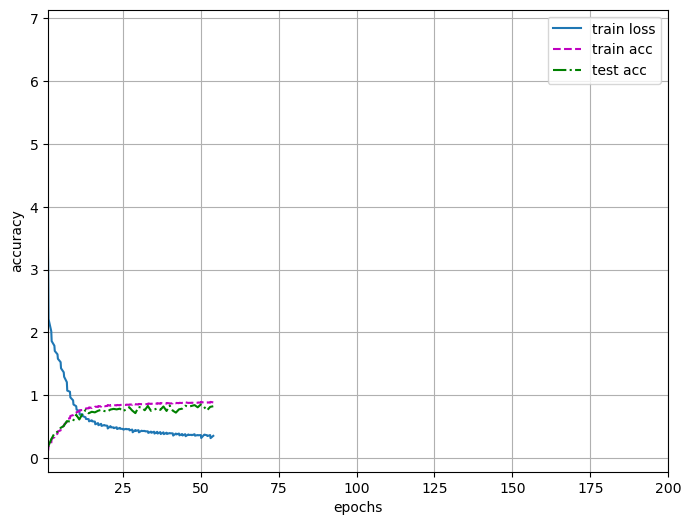

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 54 train loss: 0.354, train accuracy: 0.880, test accuracy 0.813, lr: 0.08306559326618261


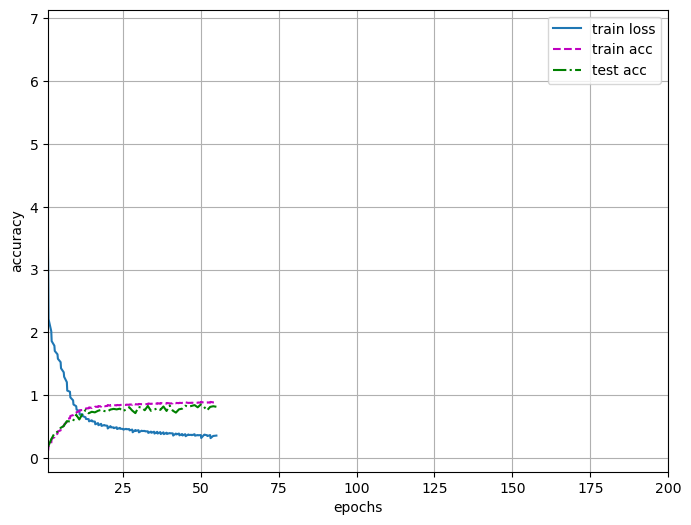

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 55 train loss: 0.345, train accuracy: 0.883, test accuracy 0.827, lr: 0.0824724024165092


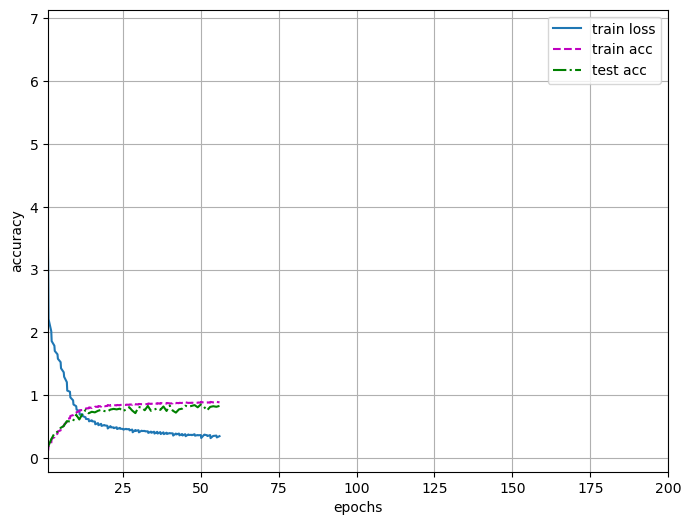

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 56 train loss: 0.342, train accuracy: 0.885, test accuracy 0.818, lr: 0.0818711994874345


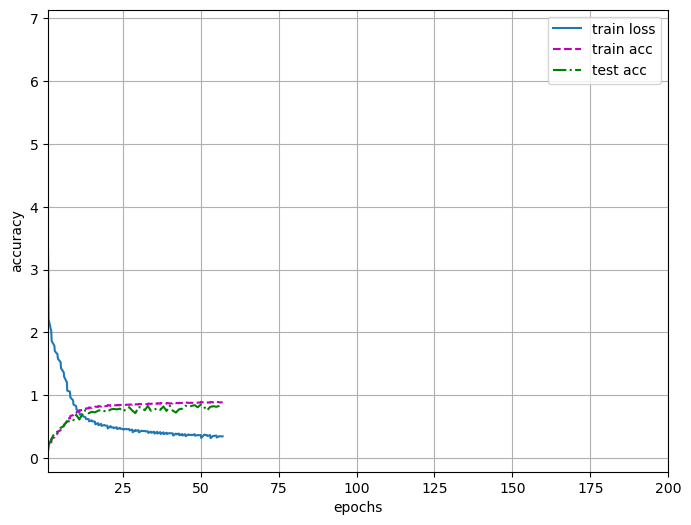

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 57 train loss: 0.338, train accuracy: 0.886, test accuracy 0.849, lr: 0.08126213281678528


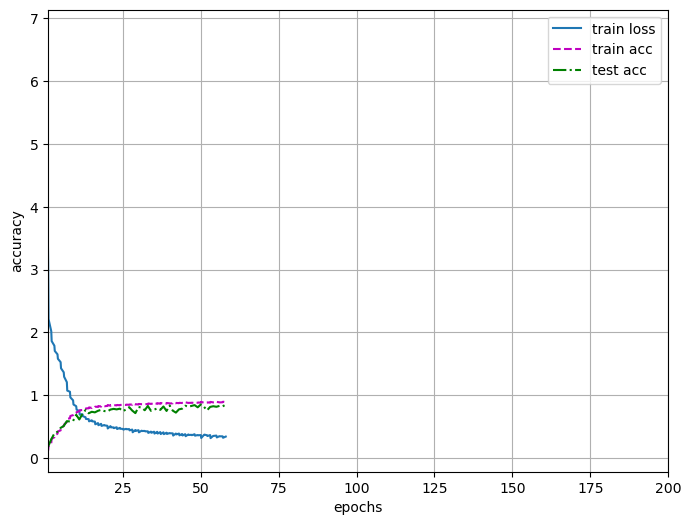

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 58 train loss: 0.346, train accuracy: 0.882, test accuracy 0.797, lr: 0.08064535268264884


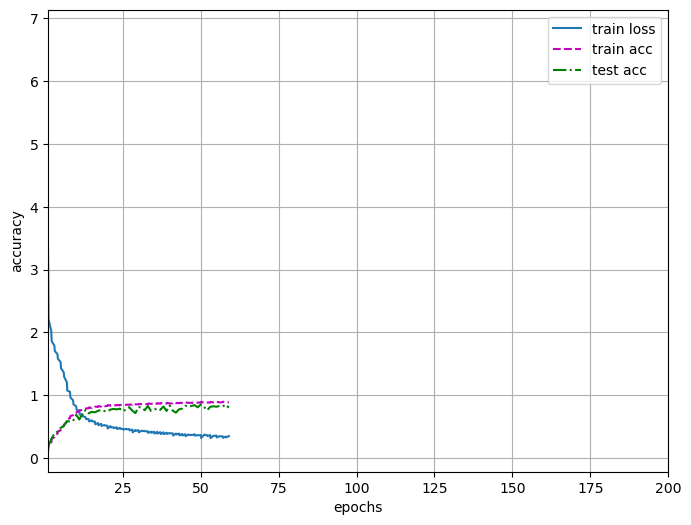

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():AssertionError: can only test a child process

  File "/op

epoch: 59 train loss: 0.331, train accuracy: 0.888, test accuracy 0.849, lr: 0.08002101126629421


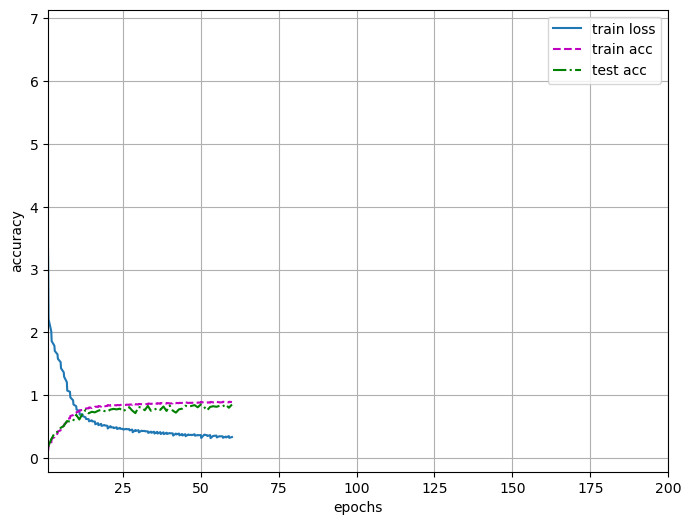

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 60 train loss: 0.335, train accuracy: 0.887, test accuracy 0.838, lr: 0.07938926261462367


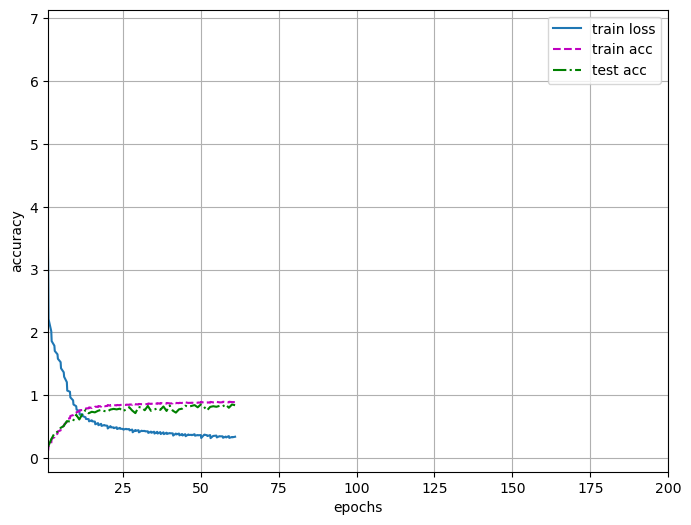

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 61 train loss: 0.328, train accuracy: 0.889, test accuracy 0.827, lr: 0.07875026260216395


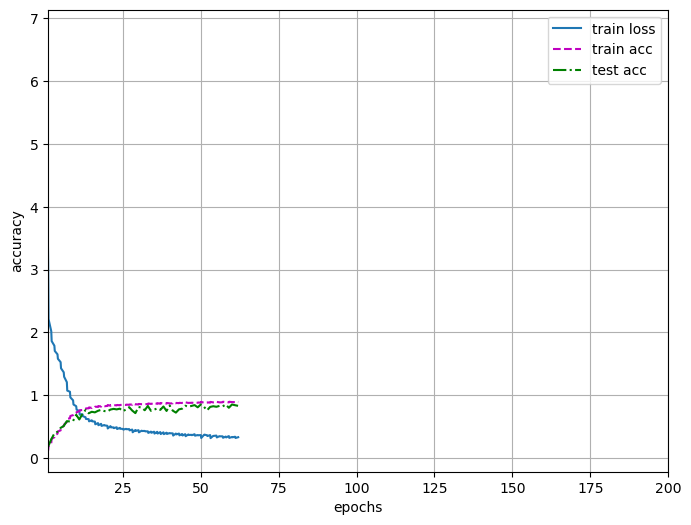

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 62 train loss: 0.330, train accuracy: 0.889, test accuracy 0.847, lr: 0.07810416889260656


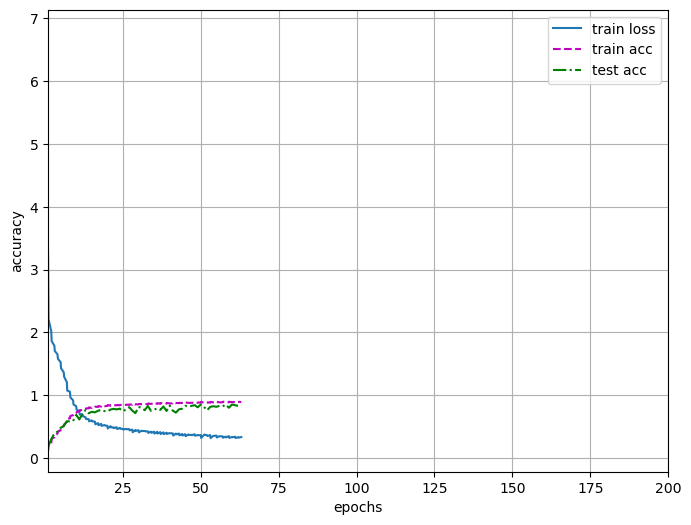

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 63 train loss: 0.330, train accuracy: 0.887, test accuracy 0.856, lr: 0.07745114089990661


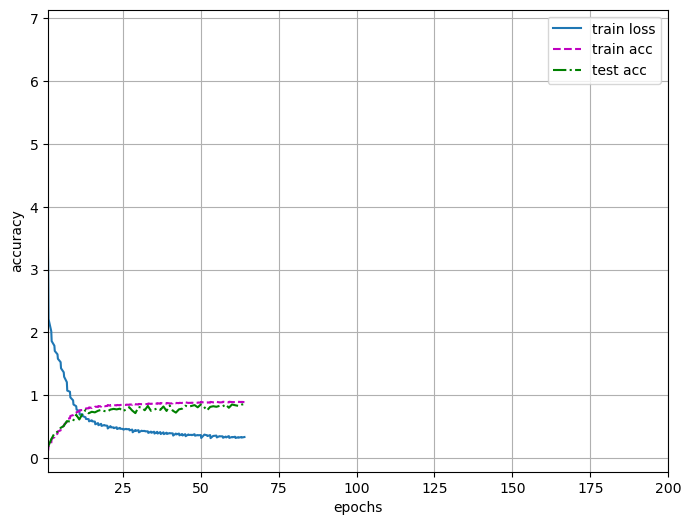

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 64 train loss: 0.330, train accuracy: 0.888, test accuracy 0.828, lr: 0.07679133974894985


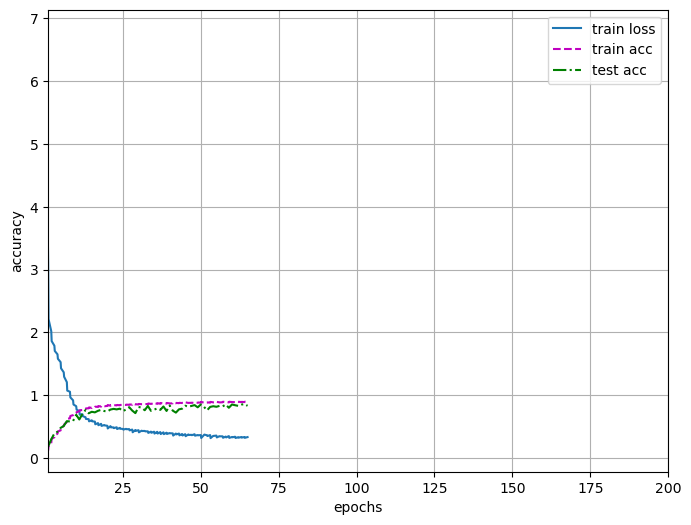

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 65 train loss: 0.317, train accuracy: 0.892, test accuracy 0.832, lr: 0.07612492823579746


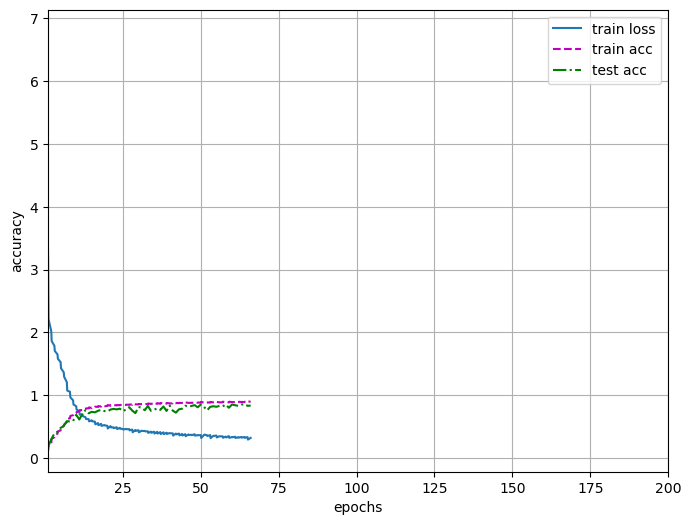

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 66 train loss: 0.317, train accuracy: 0.892, test accuracy 0.843, lr: 0.07545207078751859


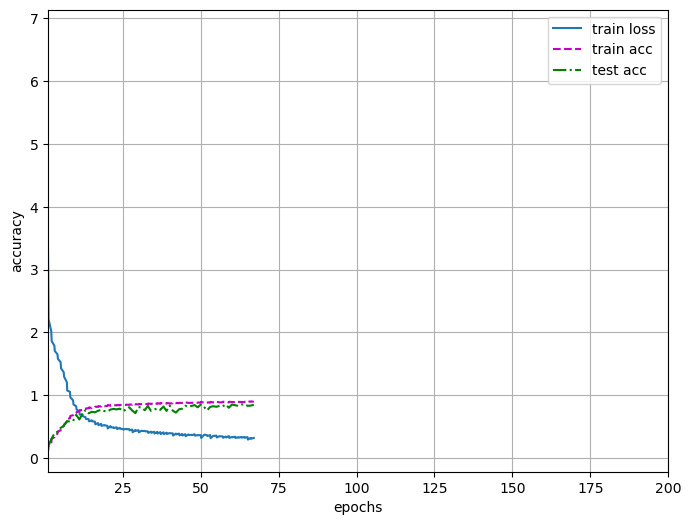

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 67 train loss: 0.318, train accuracy: 0.892, test accuracy 0.850, lr: 0.0747729334216204


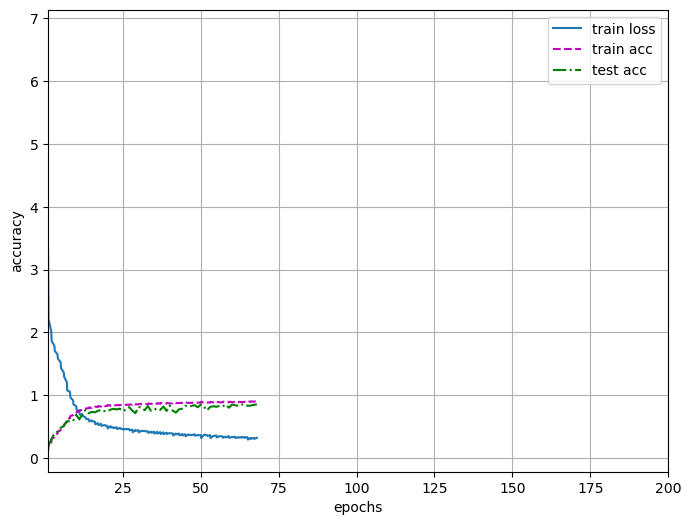

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 68 train loss: 0.313, train accuracy: 0.893, test accuracy 0.829, lr: 0.07408768370508578


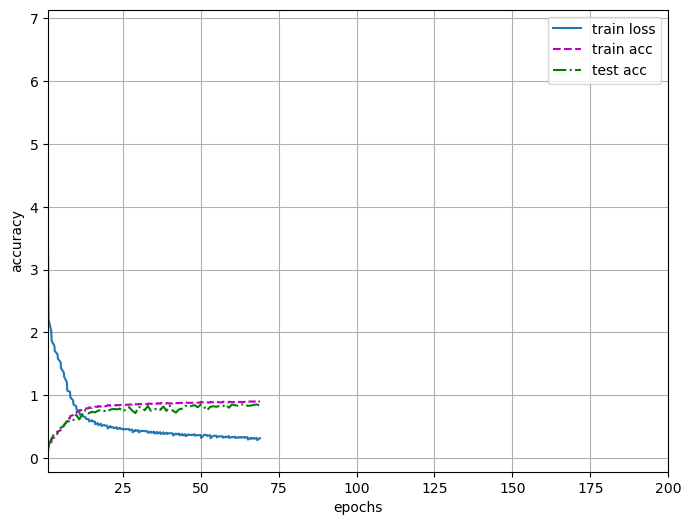

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 69 train loss: 0.311, train accuracy: 0.895, test accuracy 0.822, lr: 0.0733964907130287


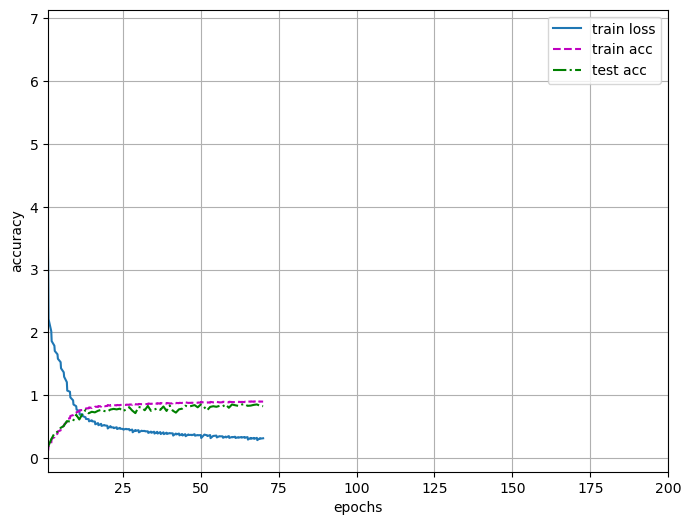

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 70 train loss: 0.310, train accuracy: 0.896, test accuracy 0.854, lr: 0.07269952498697736


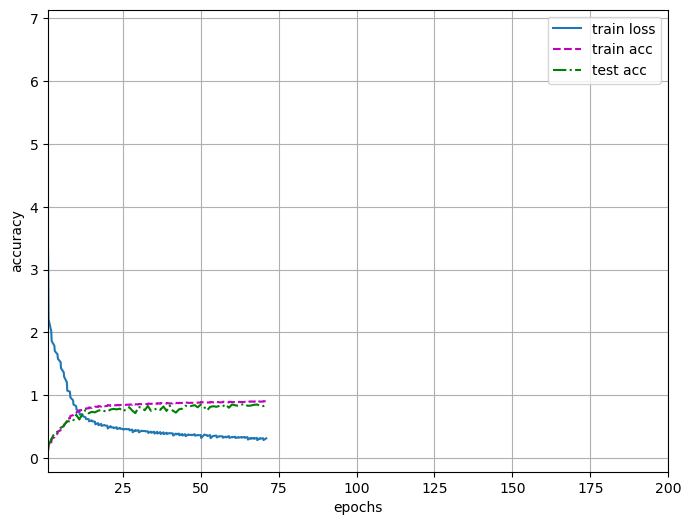

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 71 train loss: 0.310, train accuracy: 0.894, test accuracy 0.780, lr: 0.07199695849279578


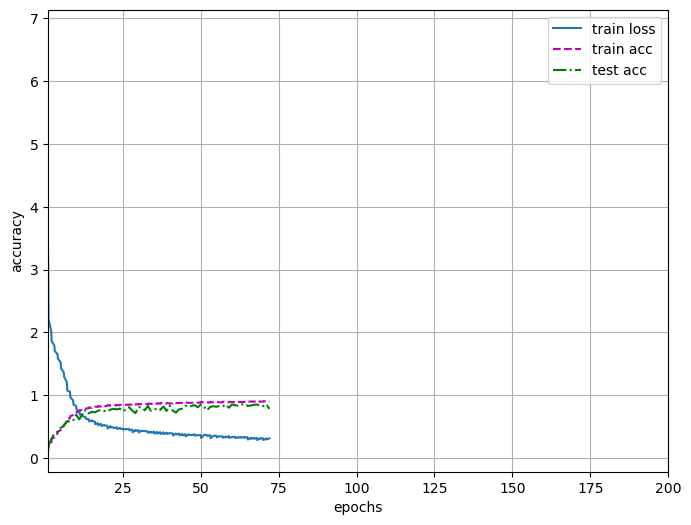

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 72 train loss: 0.305, train accuracy: 0.897, test accuracy 0.831, lr: 0.07128896457825366


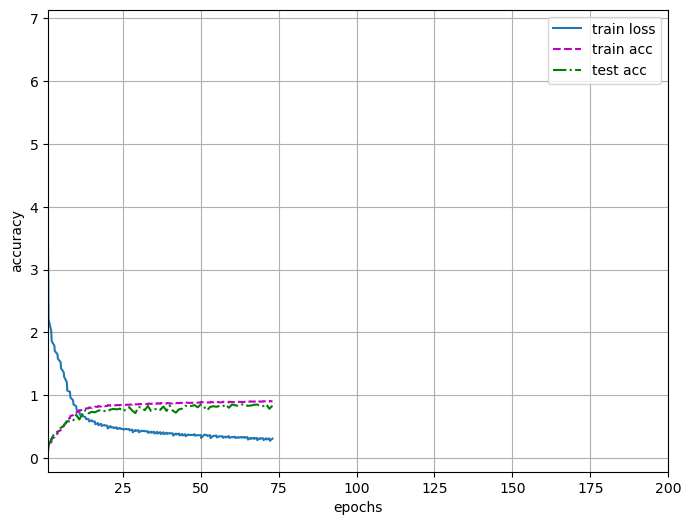

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 73 train loss: 0.302, train accuracy: 0.897, test accuracy 0.835, lr: 0.07057571793025548


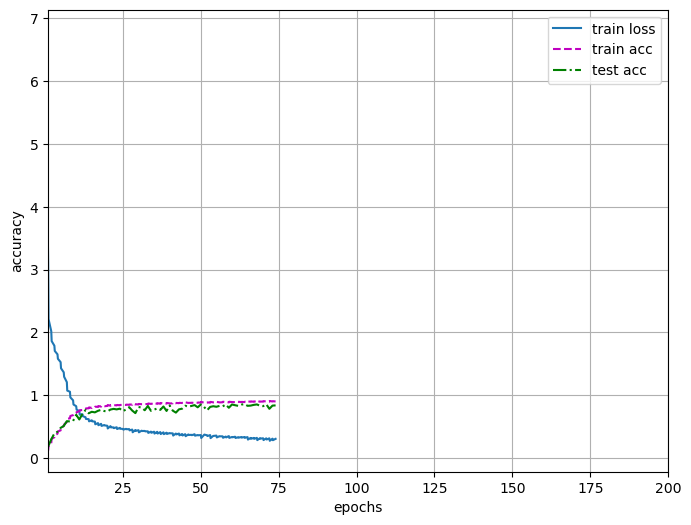

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 74 train loss: 0.303, train accuracy: 0.896, test accuracy 0.826, lr: 0.06985739453173906


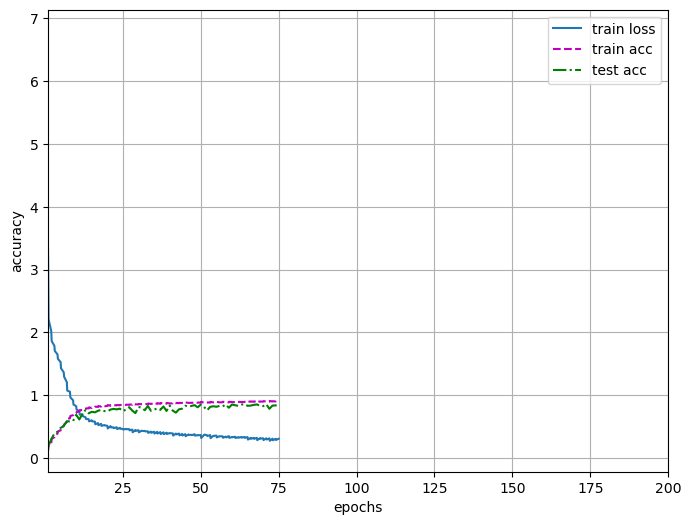

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 75 train loss: 0.296, train accuracy: 0.899, test accuracy 0.658, lr: 0.06913417161825453


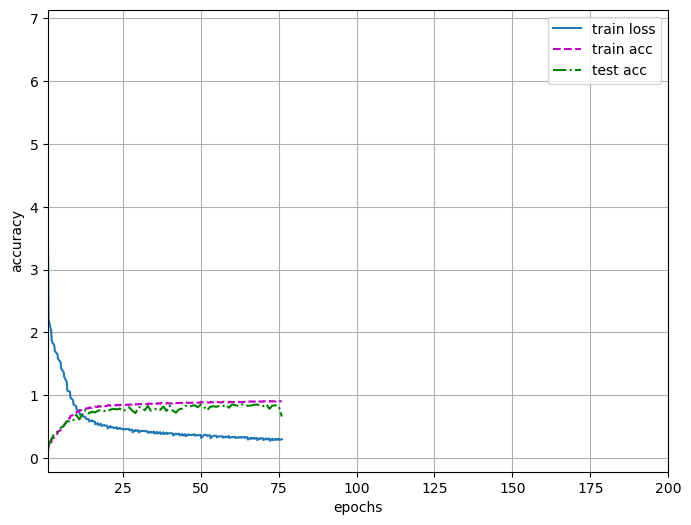

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 76 train loss: 0.296, train accuracy: 0.901, test accuracy 0.821, lr: 0.06840622763423394


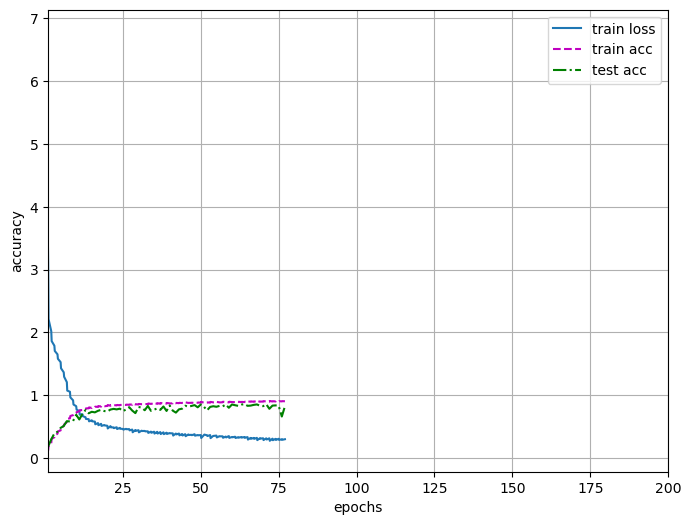

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 77 train loss: 0.290, train accuracy: 0.901, test accuracy 0.863, lr: 0.0676737421889629


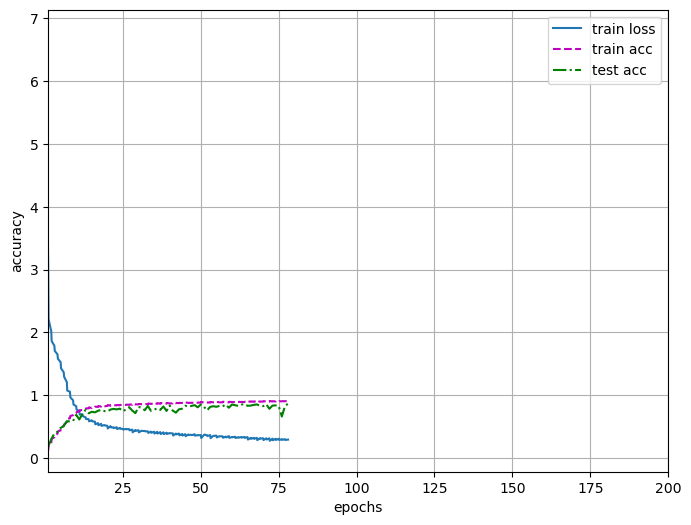

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 78 train loss: 0.283, train accuracy: 0.906, test accuracy 0.847, lr: 0.06693689601226462


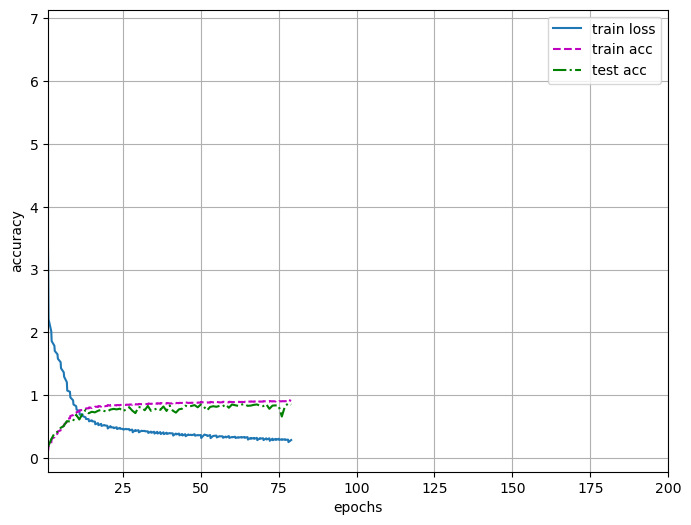

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 79 train loss: 0.291, train accuracy: 0.901, test accuracy 0.877, lr: 0.06619587090990751


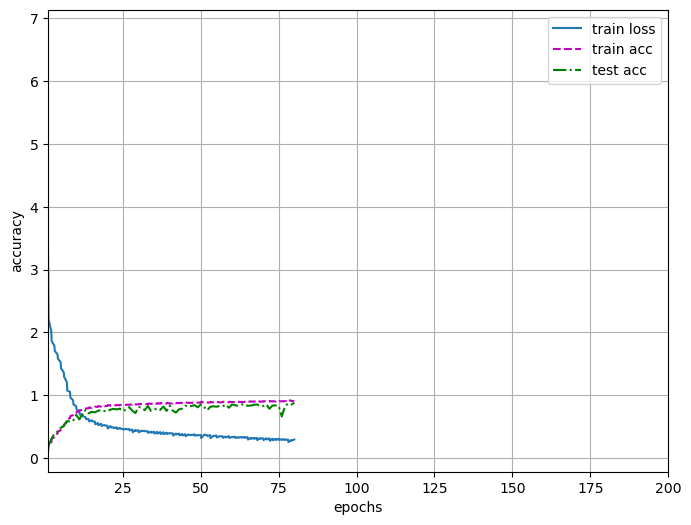

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 80 train loss: 0.284, train accuracy: 0.902, test accuracy 0.877, lr: 0.06545084971874741


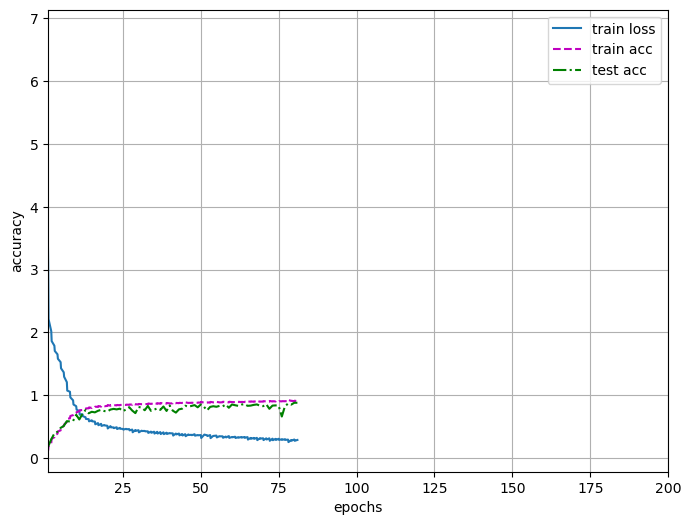

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 81 train loss: 0.276, train accuracy: 0.908, test accuracy 0.837, lr: 0.06470201626161524


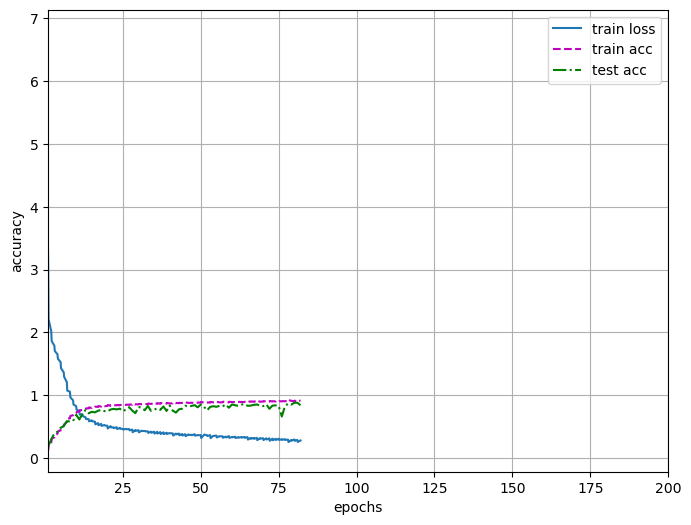

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 82 train loss: 0.281, train accuracy: 0.906, test accuracy 0.866, lr: 0.06394955530196152


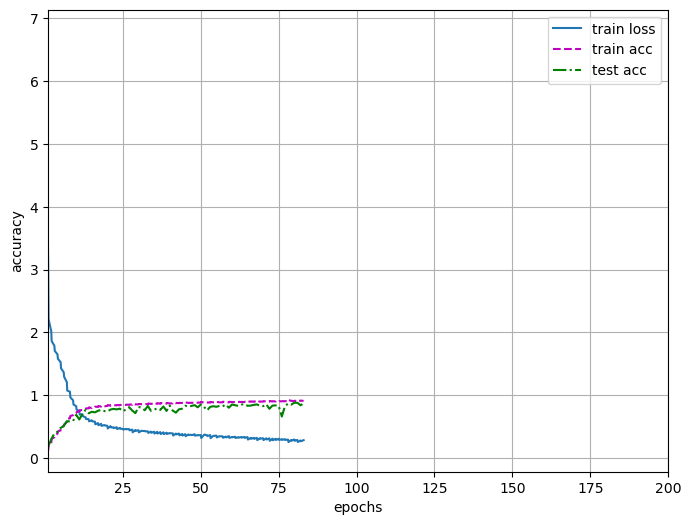

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 83 train loss: 0.273, train accuracy: 0.907, test accuracy 0.846, lr: 0.06319365249826868


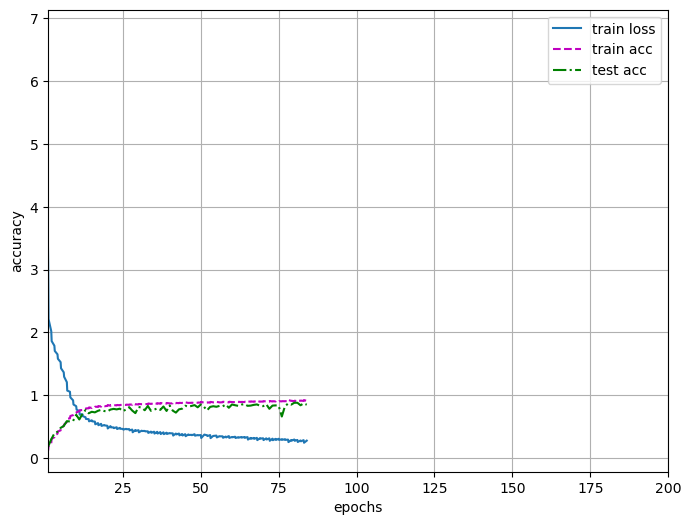

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 84 train loss: 0.273, train accuracy: 0.906, test accuracy 0.868, lr: 0.06243449435824277


  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 85 train loss: 0.271, train accuracy: 0.908, test accuracy 0.840, lr: 0.06167226819279532


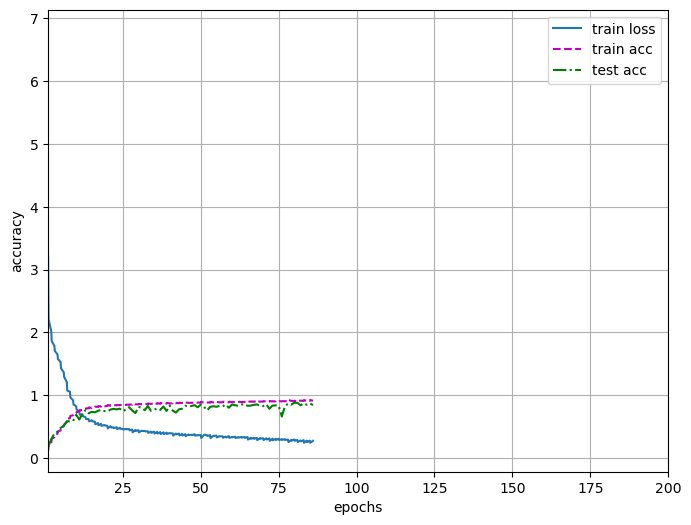

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 86 train loss: 0.266, train accuracy: 0.908, test accuracy 0.852, lr: 0.06090716206982718


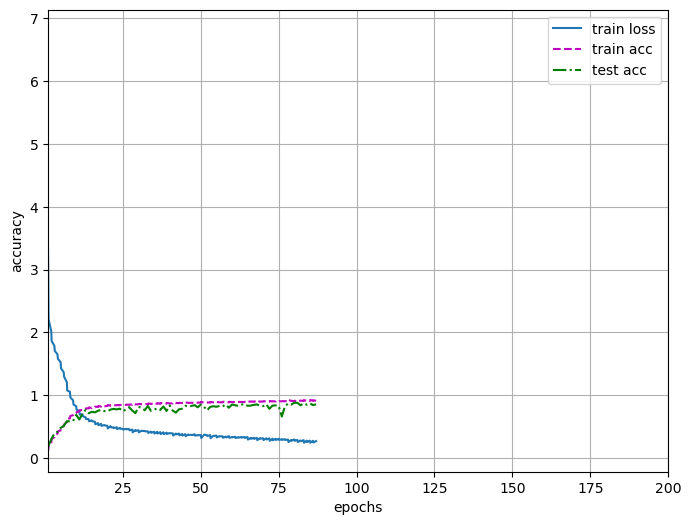

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 87 train loss: 0.266, train accuracy: 0.911, test accuracy 0.847, lr: 0.06013936476782568


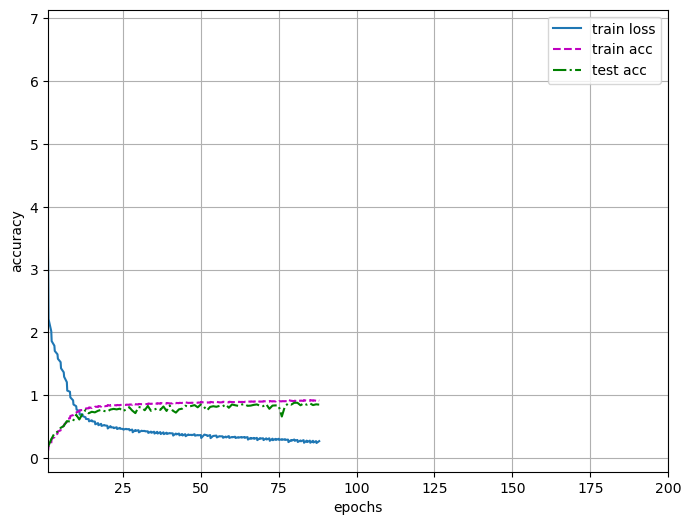

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 88 train loss: 0.263, train accuracy: 0.911, test accuracy 0.844, lr: 0.05936906572928629


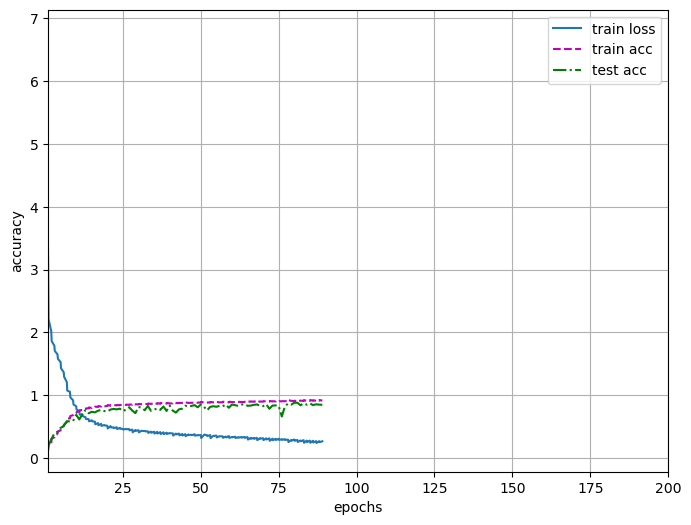

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 89 train loss: 0.259, train accuracy: 0.912, test accuracy 0.847, lr: 0.05859645501397052


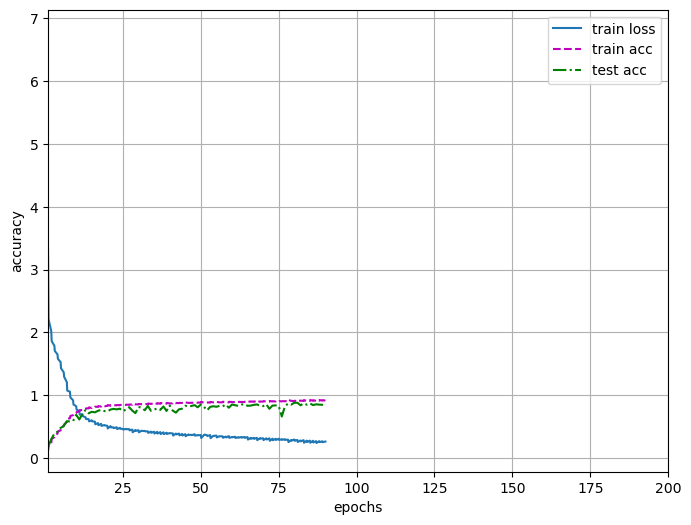

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

epoch: 90 train loss: 0.255, train accuracy: 0.914, test accuracy 0.858, lr: 0.05782172325201159


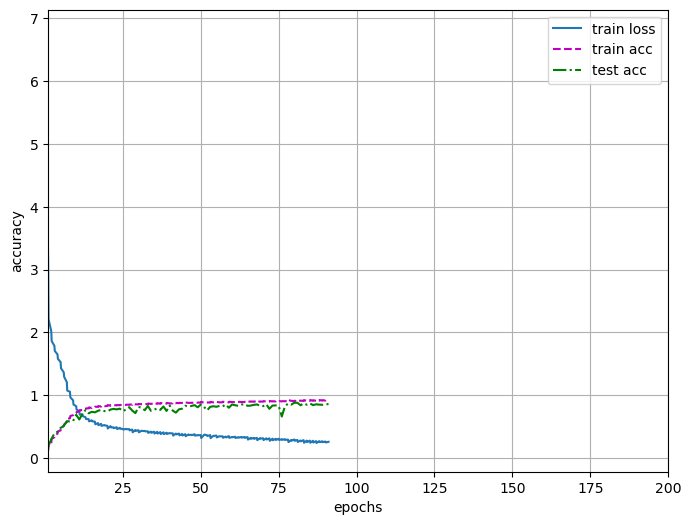

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 91 train loss: 0.252, train accuracy: 0.915, test accuracy 0.843, lr: 0.057045061596879186


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 92 train loss: 0.248, train accuracy: 0.915, test accuracy 0.852, lr: 0.056266661678215264


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 93 train loss: 0.249, train accuracy: 0.914, test accuracy 0.878, lr: 0.055486715554552306


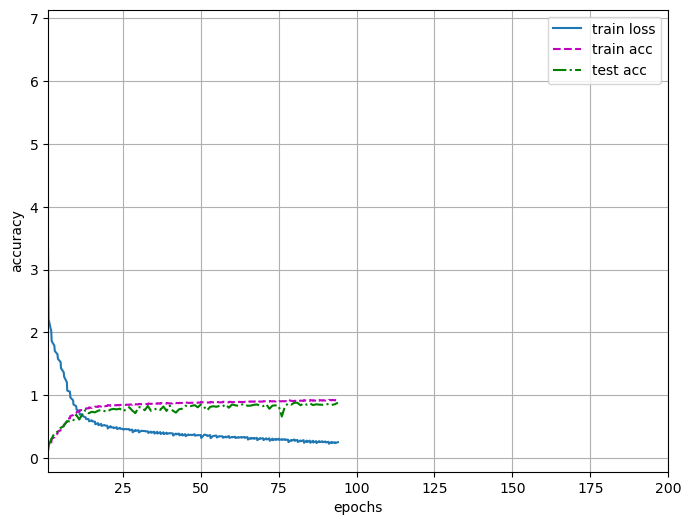

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 94 train loss: 0.238, train accuracy: 0.920, test accuracy 0.874, lr: 0.05470541566592575


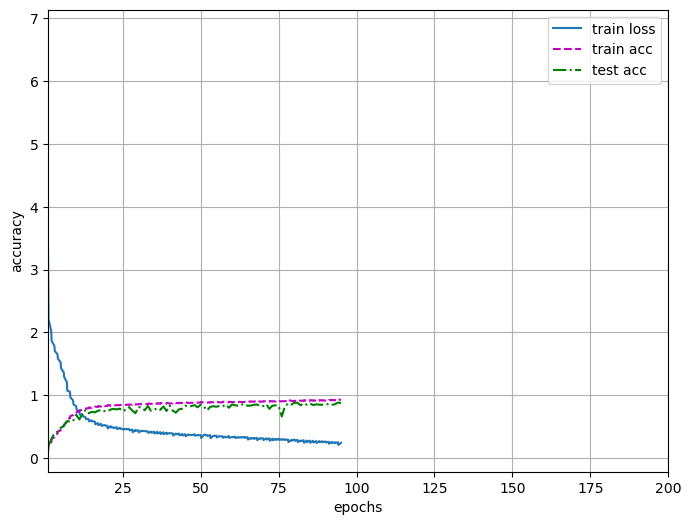

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 95 train loss: 0.244, train accuracy: 0.918, test accuracy 0.867, lr: 0.05392295478639229


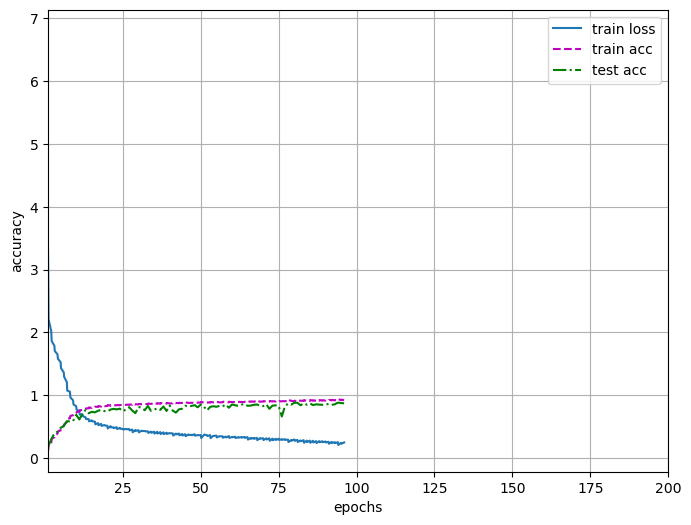

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 96 train loss: 0.240, train accuracy: 0.920, test accuracy 0.868, lr: 0.05313952597646571


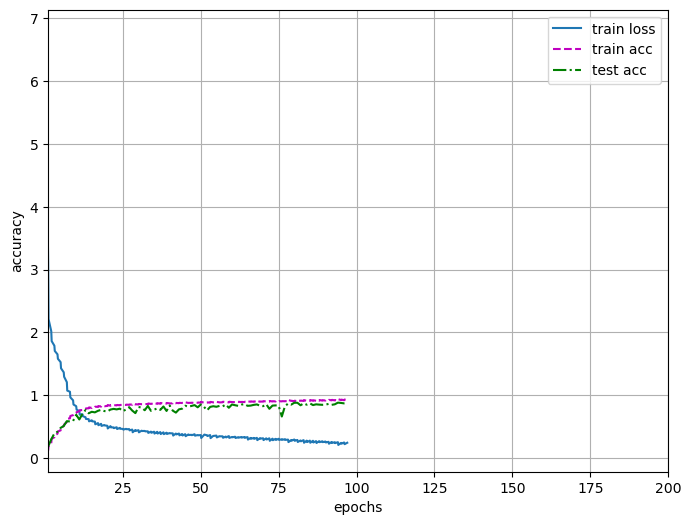

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 97 train loss: 0.231, train accuracy: 0.922, test accuracy 0.848, lr: 0.05235532253548216


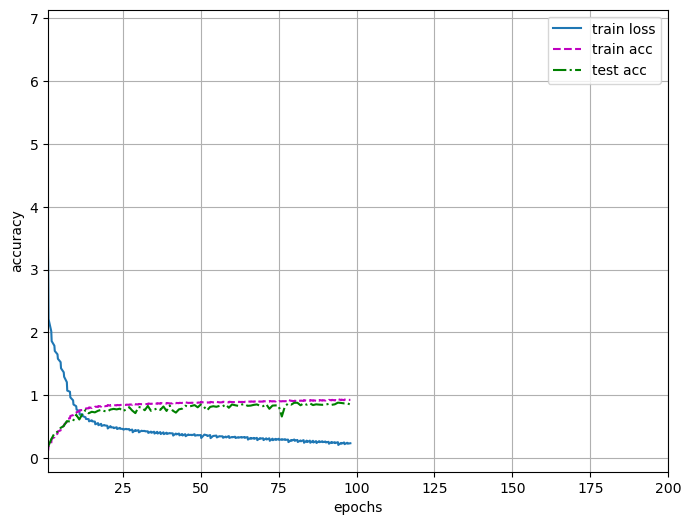

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 98 train loss: 0.237, train accuracy: 0.919, test accuracy 0.881, lr: 0.051570537953906447


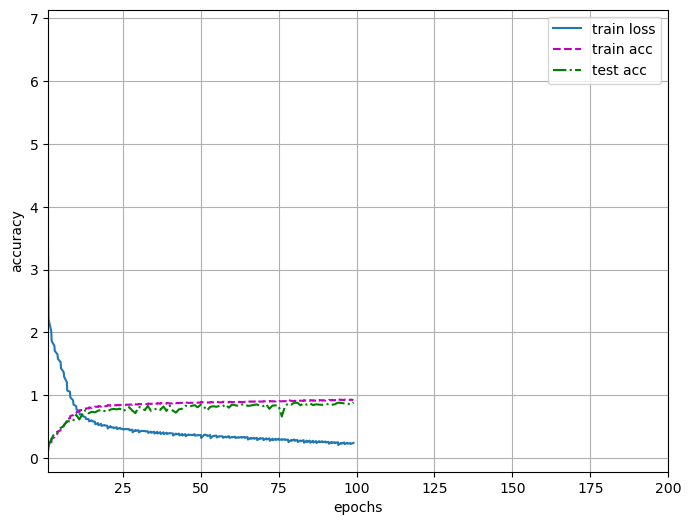

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 99 train loss: 0.232, train accuracy: 0.921, test accuracy 0.859, lr: 0.05078536586559106


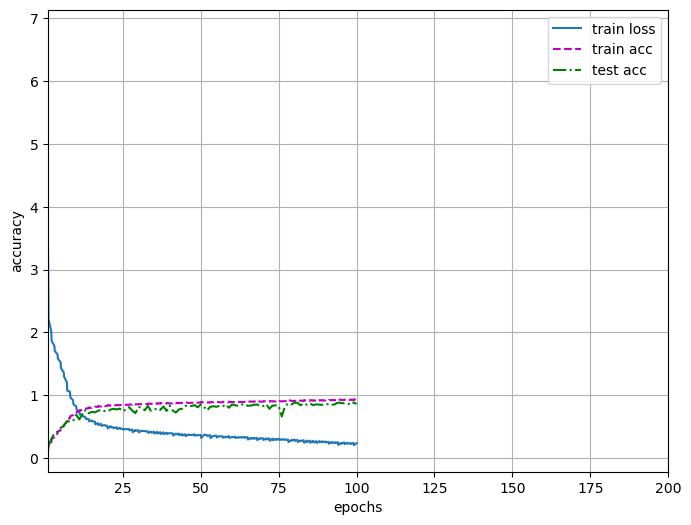

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 100 train loss: 0.221, train accuracy: 0.923, test accuracy 0.870, lr: 0.050000000000000024


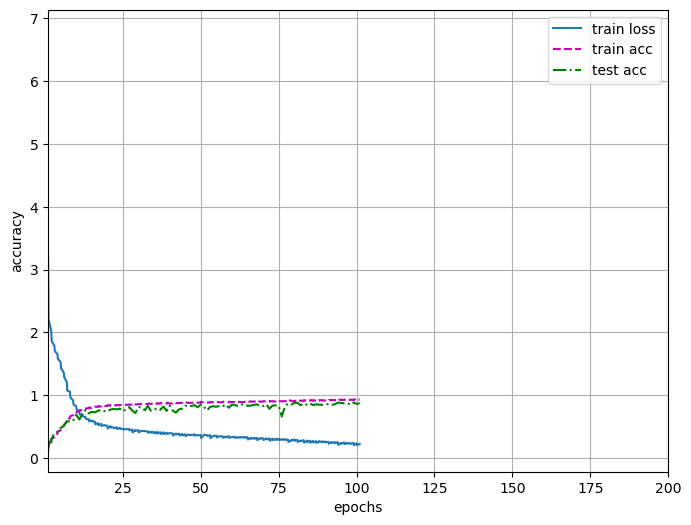

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 101 train loss: 0.223, train accuracy: 0.925, test accuracy 0.883, lr: 0.049214634134409


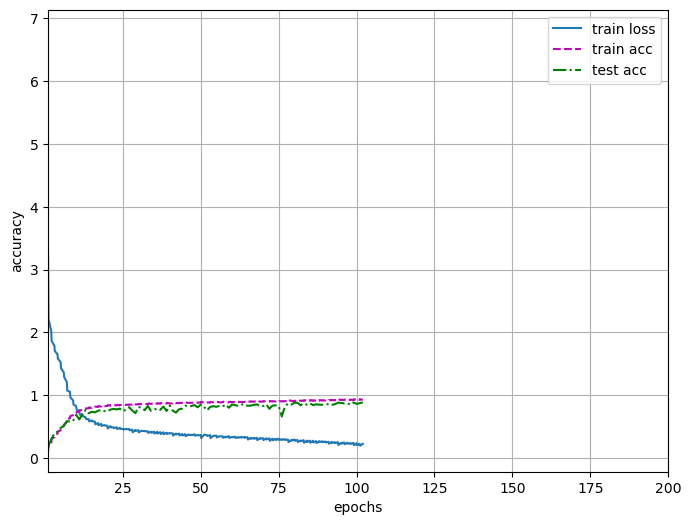

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 102 train loss: 0.224, train accuracy: 0.924, test accuracy 0.858, lr: 0.04842946204609361


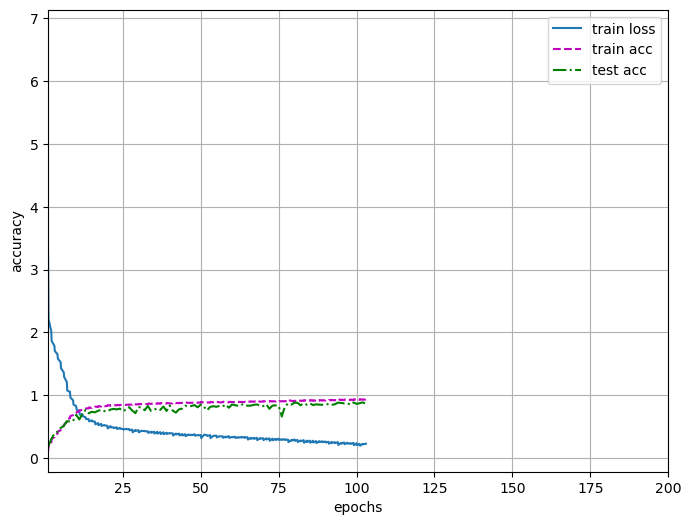

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 103 train loss: 0.218, train accuracy: 0.925, test accuracy 0.872, lr: 0.04764467746451789


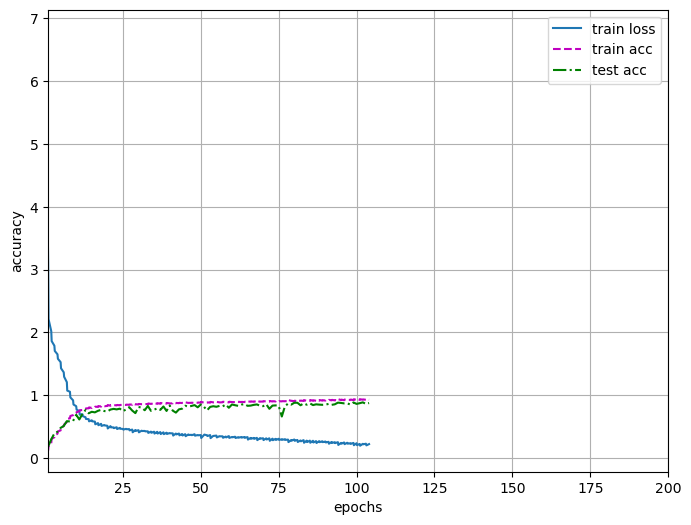

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 104 train loss: 0.211, train accuracy: 0.928, test accuracy 0.861, lr: 0.046860474023534354


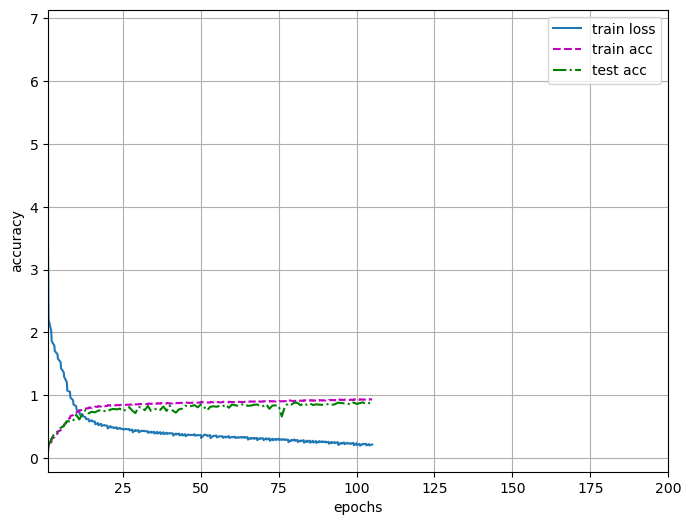

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 105 train loss: 0.208, train accuracy: 0.930, test accuracy 0.866, lr: 0.04607704521360778


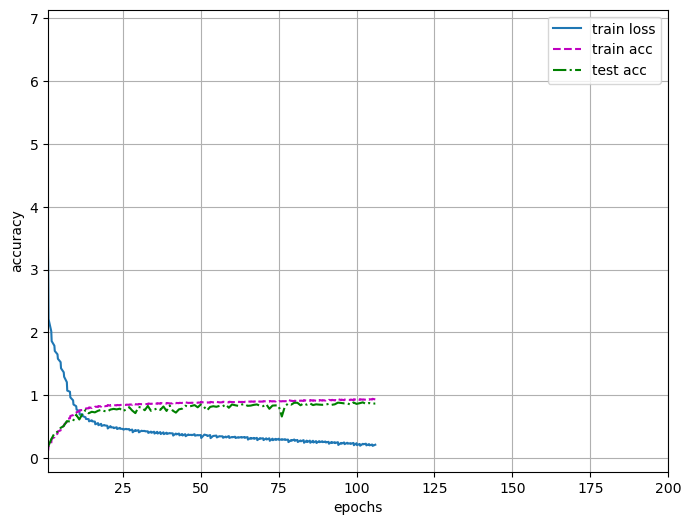

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 106 train loss: 0.205, train accuracy: 0.931, test accuracy 0.892, lr: 0.04529458433407431


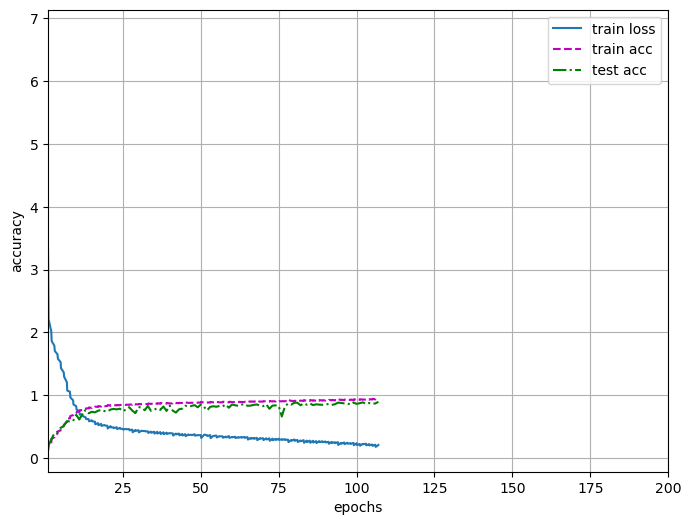

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 107 train loss: 0.209, train accuracy: 0.929, test accuracy 0.890, lr: 0.04451328444544776


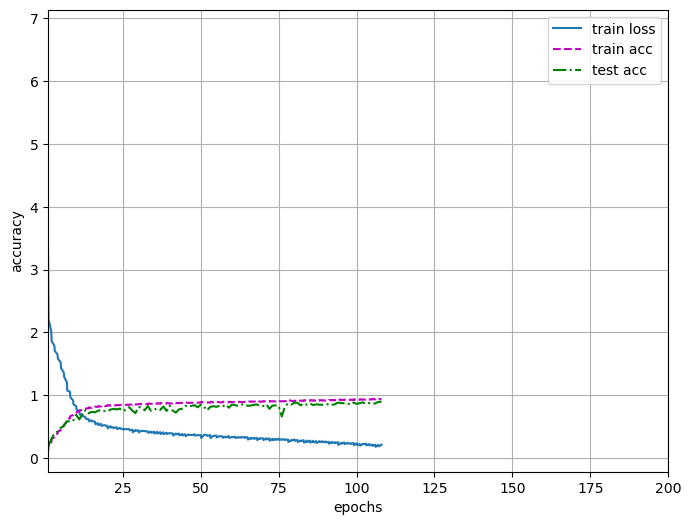

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 108 train loss: 0.202, train accuracy: 0.932, test accuracy 0.873, lr: 0.04373333832178482


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 109 train loss: 0.201, train accuracy: 0.932, test accuracy 0.874, lr: 0.0429549384031209


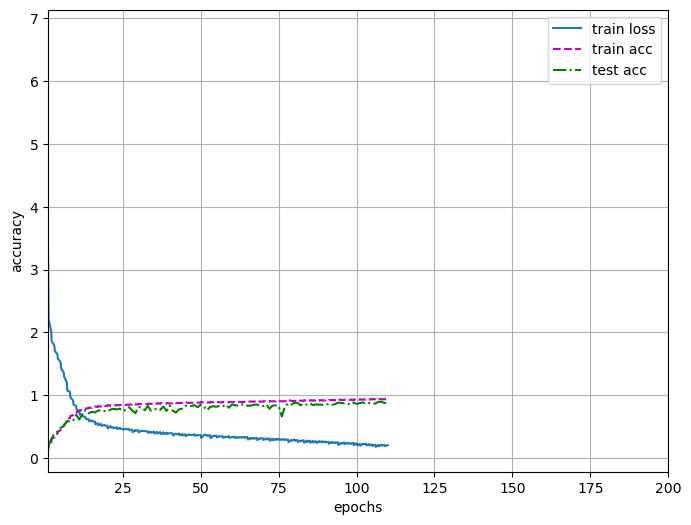

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 110 train loss: 0.194, train accuracy: 0.934, test accuracy 0.880, lr: 0.042178276747988484


  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 111 train loss: 0.194, train accuracy: 0.934, test accuracy 0.892, lr: 0.04140354498602954


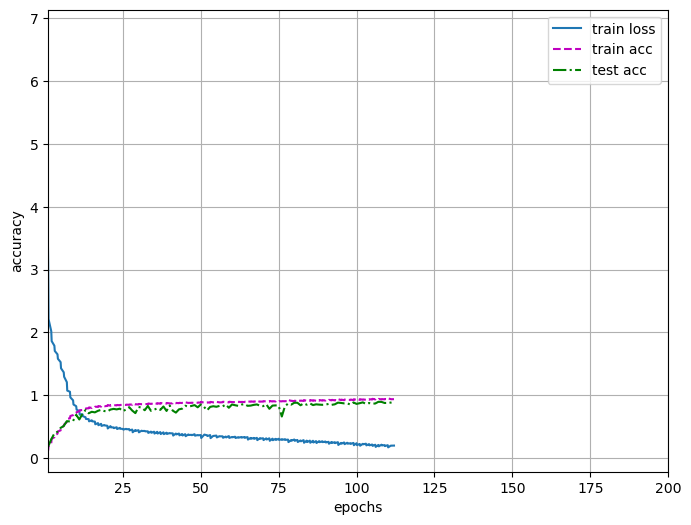

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 112 train loss: 0.189, train accuracy: 0.936, test accuracy 0.891, lr: 0.0406309342707138


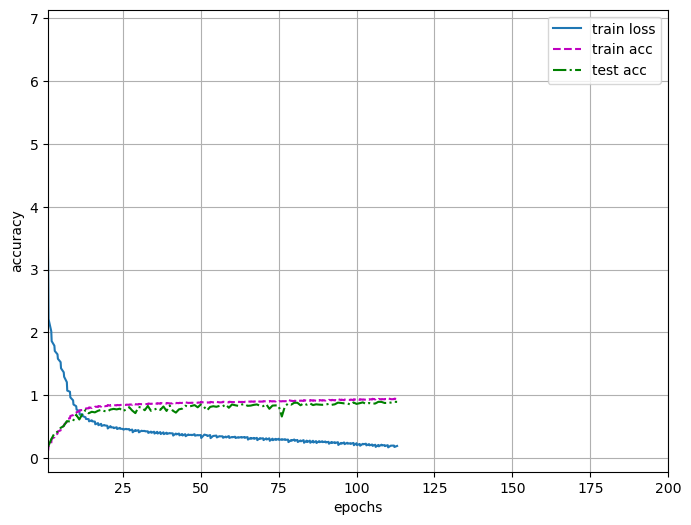

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 113 train loss: 0.190, train accuracy: 0.936, test accuracy 0.893, lr: 0.03986063523217441


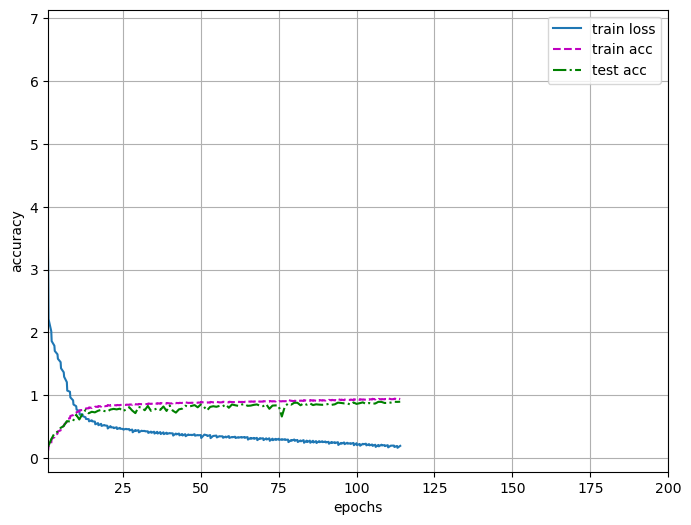

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 114 train loss: 0.178, train accuracy: 0.940, test accuracy 0.898, lr: 0.039092837930172916


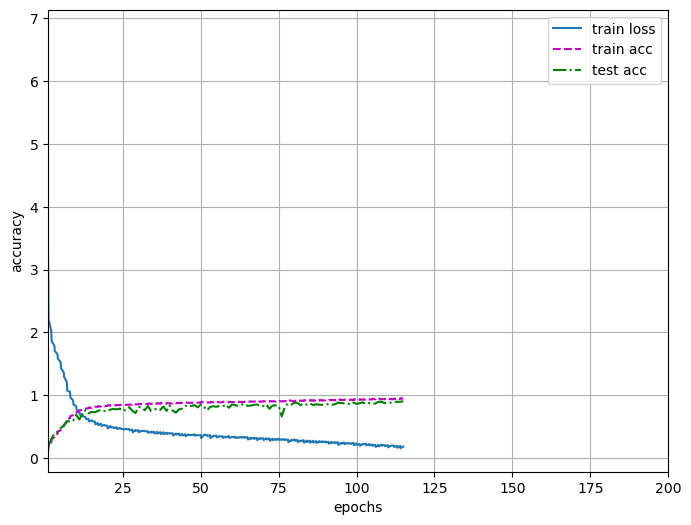

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 115 train loss: 0.182, train accuracy: 0.939, test accuracy 0.872, lr: 0.03832773180720475


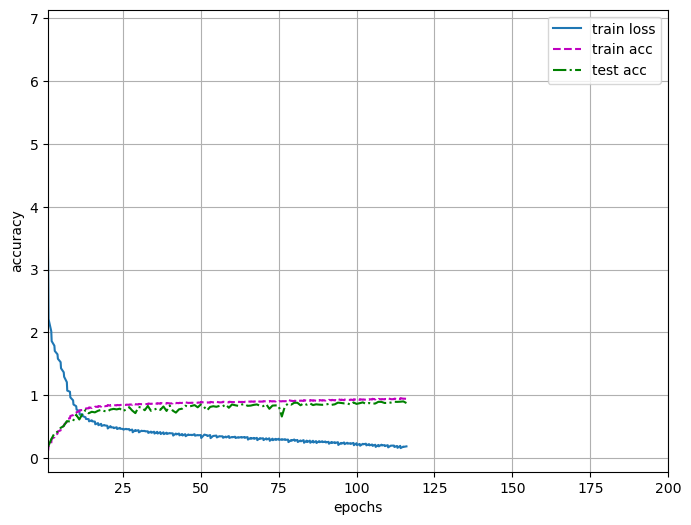

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 116 train loss: 0.170, train accuracy: 0.942, test accuracy 0.873, lr: 0.037565505641757285


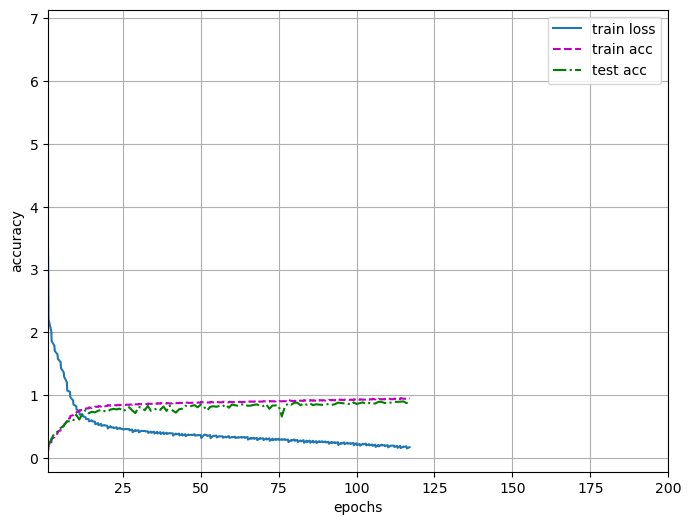

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 117 train loss: 0.170, train accuracy: 0.943, test accuracy 0.880, lr: 0.03680634750173138


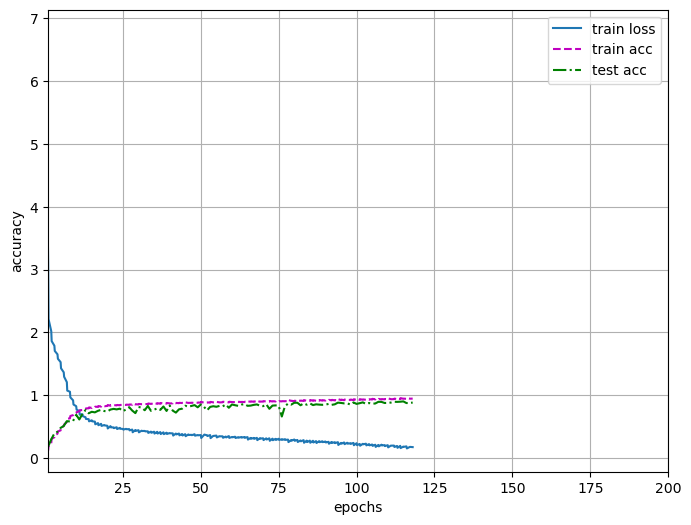

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 118 train loss: 0.168, train accuracy: 0.942, test accuracy 0.881, lr: 0.036050444698038565


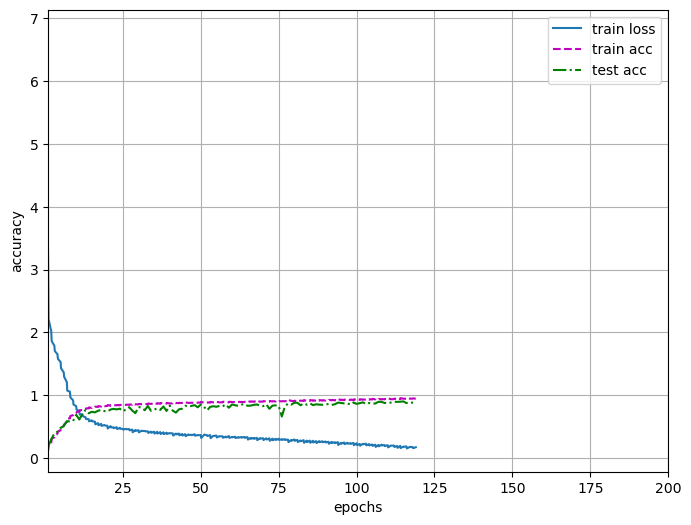

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 119 train loss: 0.168, train accuracy: 0.943, test accuracy 0.884, lr: 0.03529798373838483


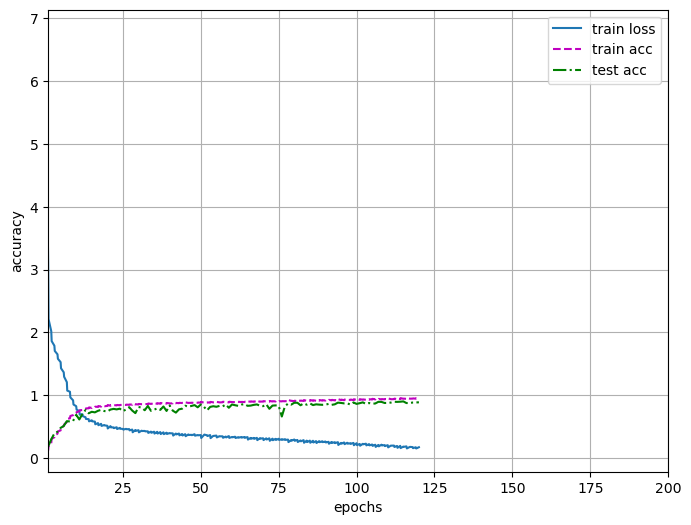

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 120 train loss: 0.155, train accuracy: 0.948, test accuracy 0.897, lr: 0.03454915028125267


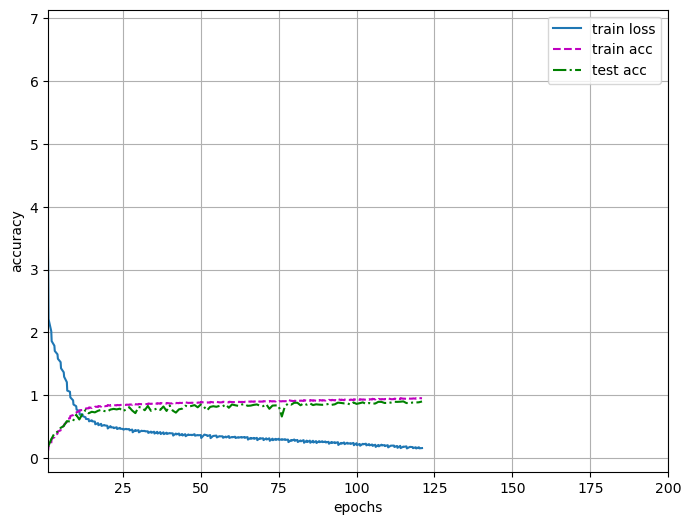

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 121 train loss: 0.158, train accuracy: 0.947, test accuracy 0.907, lr: 0.03380412909009255


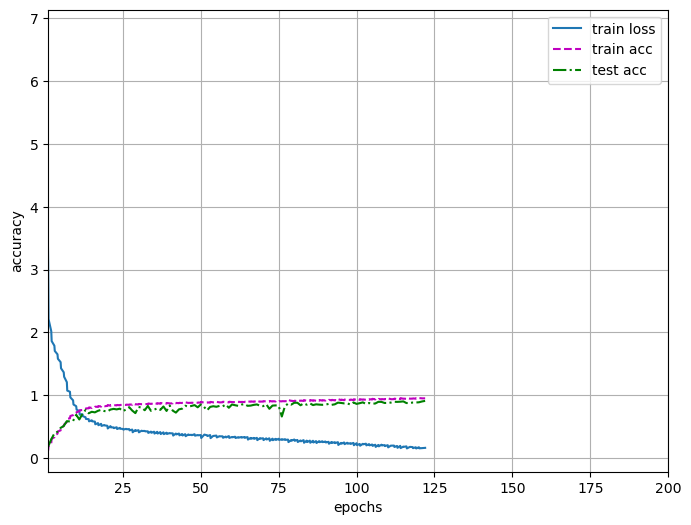

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

epoch: 122 train loss: 0.158, train accuracy: 0.946, test accuracy 0.894, lr: 0.03306310398773545


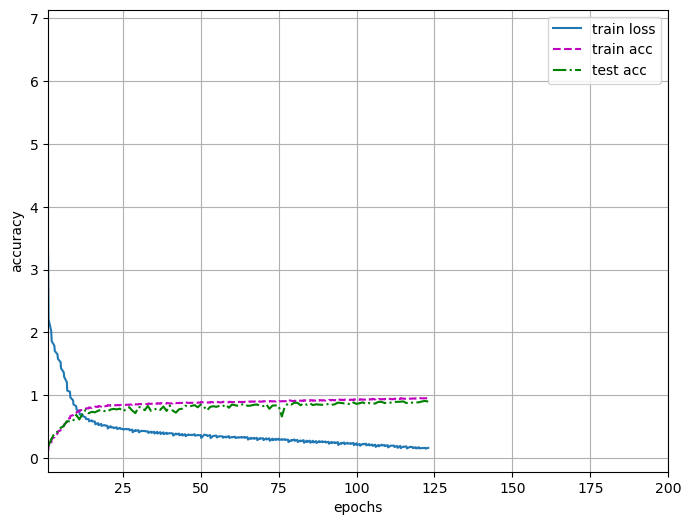

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

epoch: 123 train loss: 0.147, train accuracy: 0.951, test accuracy 0.880, lr: 0.03232625781103717


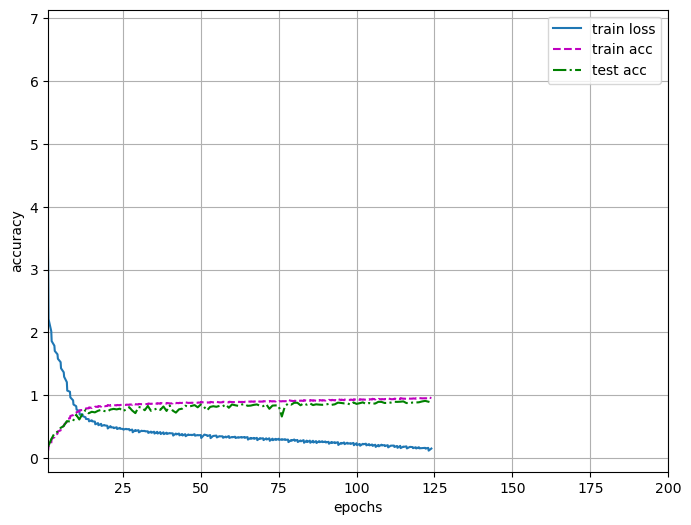

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 124 train loss: 0.141, train accuracy: 0.952, test accuracy 0.889, lr: 0.03159377236576613


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 125 train loss: 0.148, train accuracy: 0.950, test accuracy 0.897, lr: 0.030865828381745543


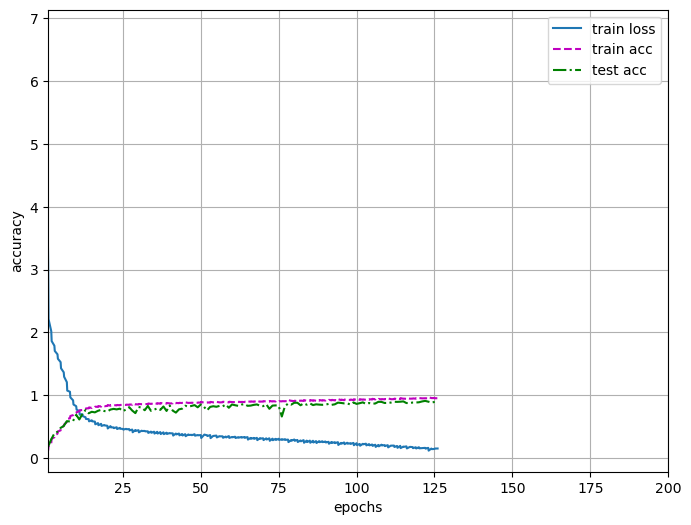

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 126 train loss: 0.139, train accuracy: 0.953, test accuracy 0.876, lr: 0.03014260546826098


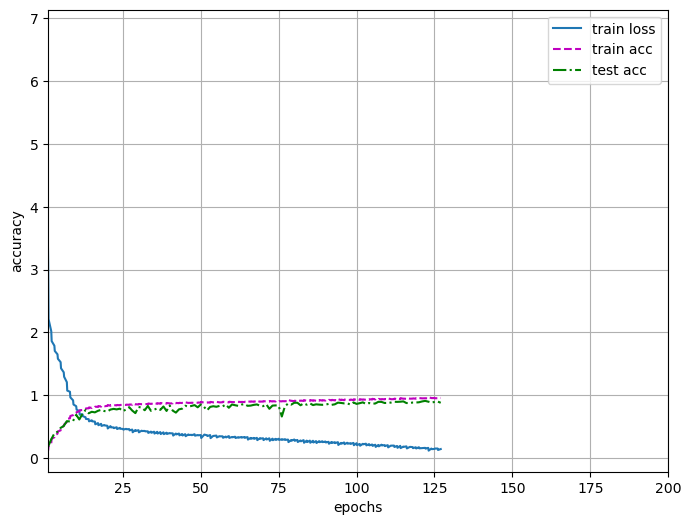

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 127 train loss: 0.140, train accuracy: 0.953, test accuracy 0.890, lr: 0.02942428206974458


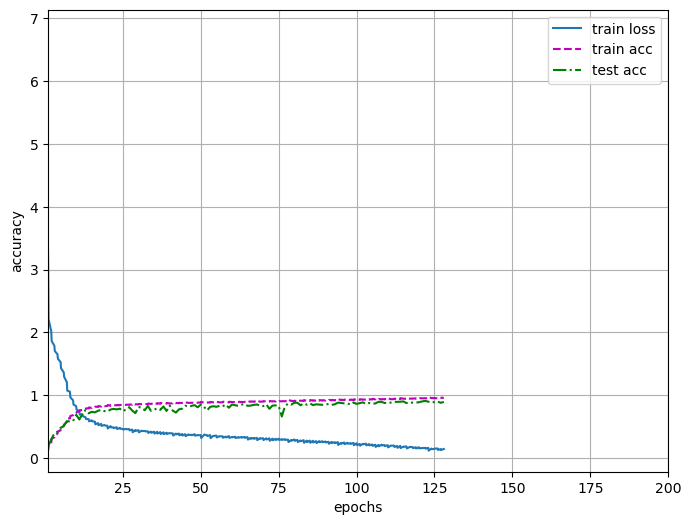

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 128 train loss: 0.134, train accuracy: 0.955, test accuracy 0.886, lr: 0.028711035421746387


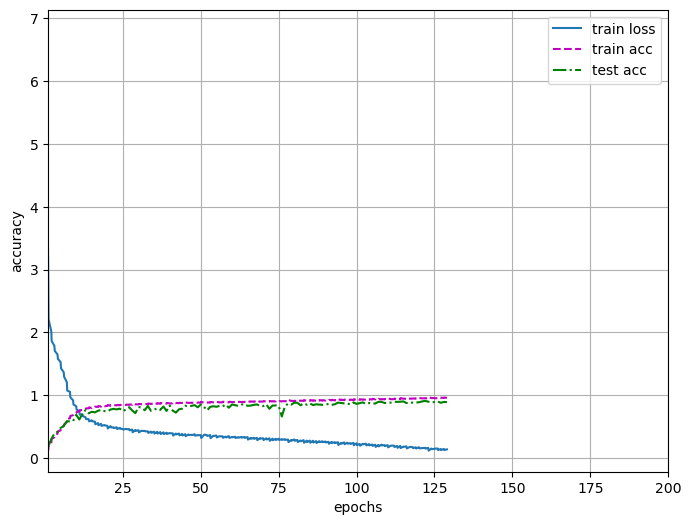

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 129 train loss: 0.131, train accuracy: 0.955, test accuracy 0.894, lr: 0.02800304150720426


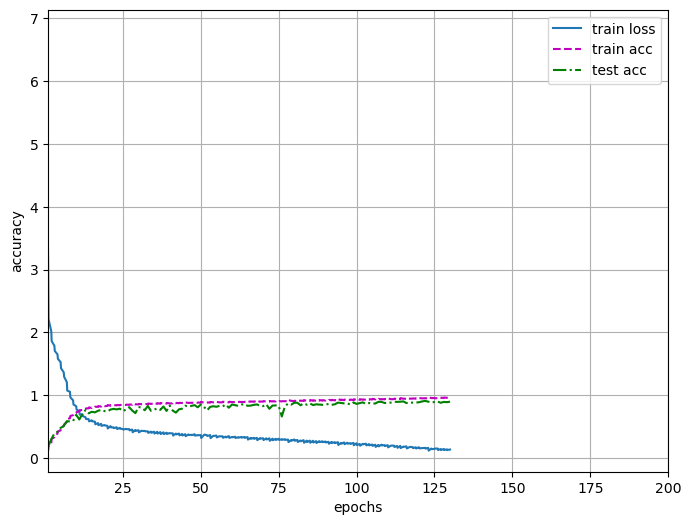

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 130 train loss: 0.129, train accuracy: 0.956, test accuracy 0.906, lr: 0.02730047501302268


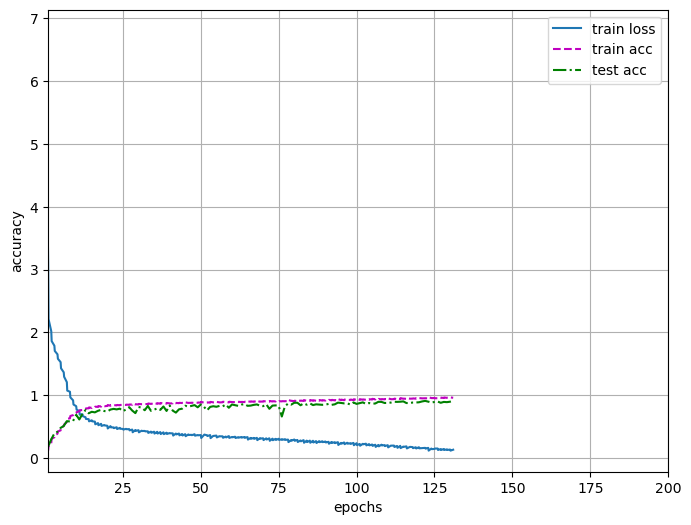

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 131 train loss: 0.127, train accuracy: 0.957, test accuracy 0.885, lr: 0.026603509286971357


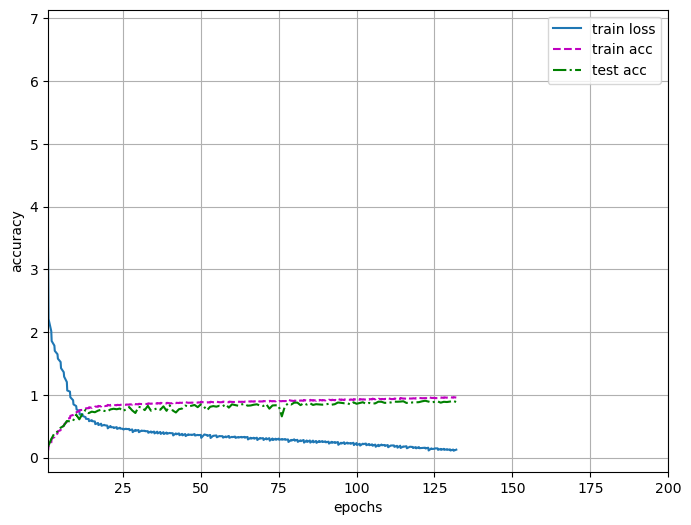

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 132 train loss: 0.117, train accuracy: 0.961, test accuracy 0.898, lr: 0.025912316294914244


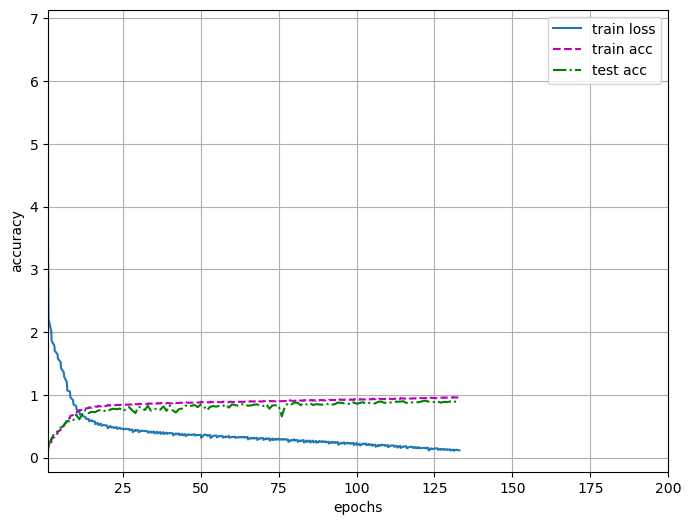

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 133 train loss: 0.114, train accuracy: 0.961, test accuracy 0.895, lr: 0.025227066578379632


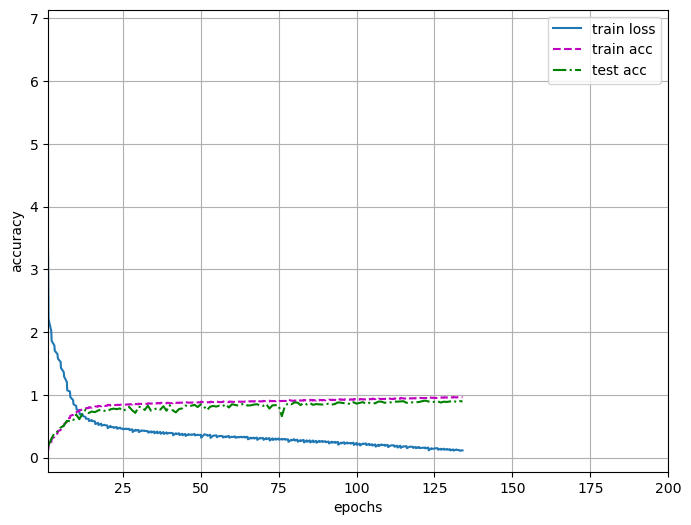

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 134 train loss: 0.116, train accuracy: 0.961, test accuracy 0.901, lr: 0.024547929212481445


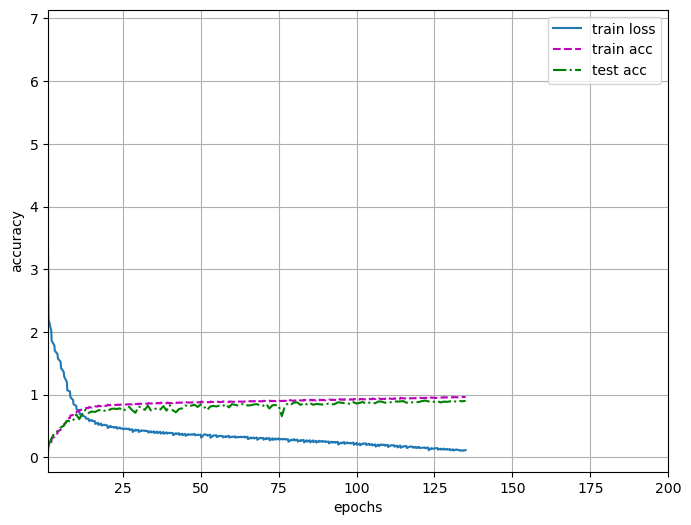

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 135 train loss: 0.111, train accuracy: 0.963, test accuracy 0.901, lr: 0.02387507176420257


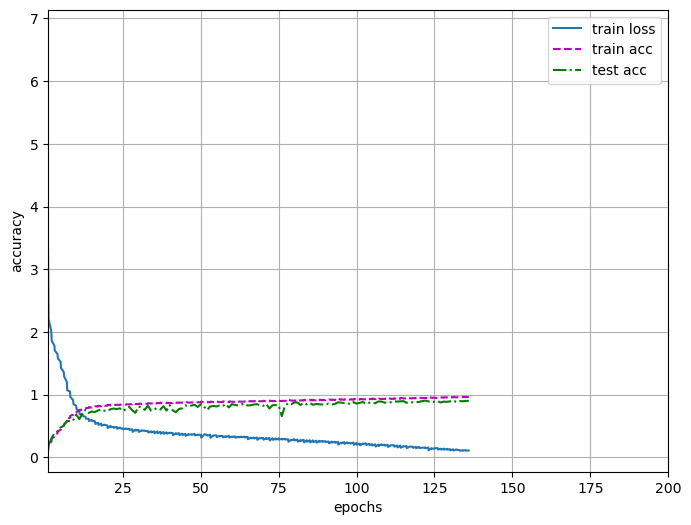

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 136 train loss: 0.108, train accuracy: 0.964, test accuracy 0.905, lr: 0.023208660251050166


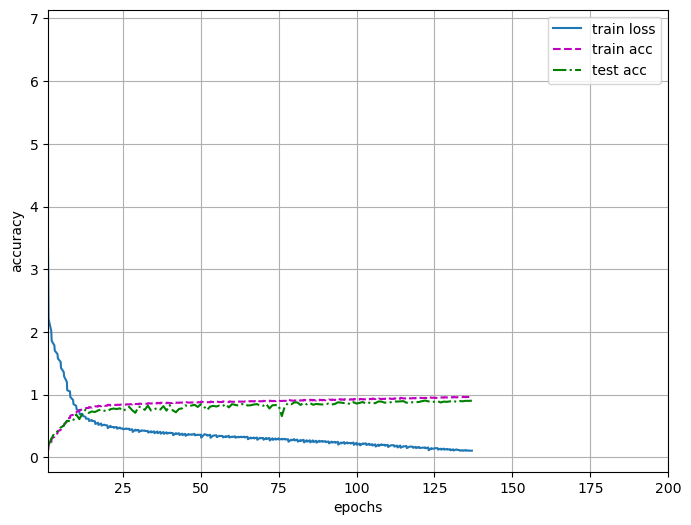

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 137 train loss: 0.098, train accuracy: 0.967, test accuracy 0.909, lr: 0.022548859100093414


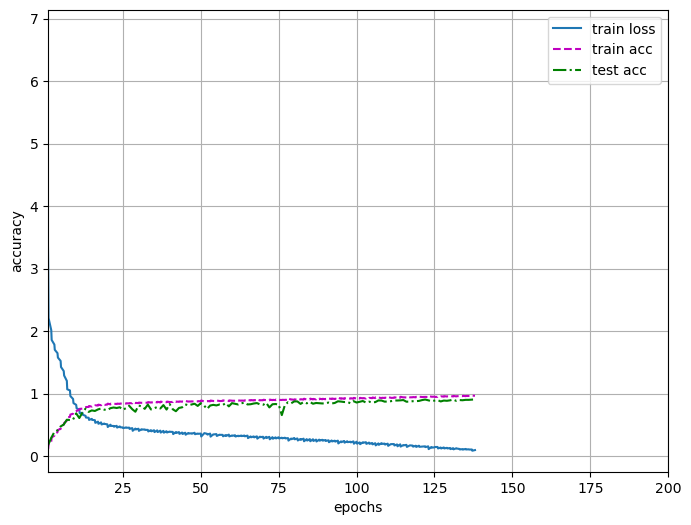

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 138 train loss: 0.107, train accuracy: 0.964, test accuracy 0.895, lr: 0.021895831107393474


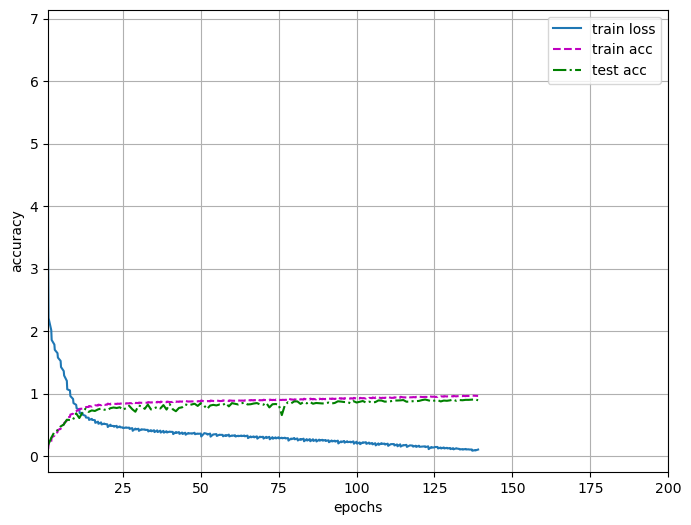

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 139 train loss: 0.097, train accuracy: 0.968, test accuracy 0.913, lr: 0.02124973739783608


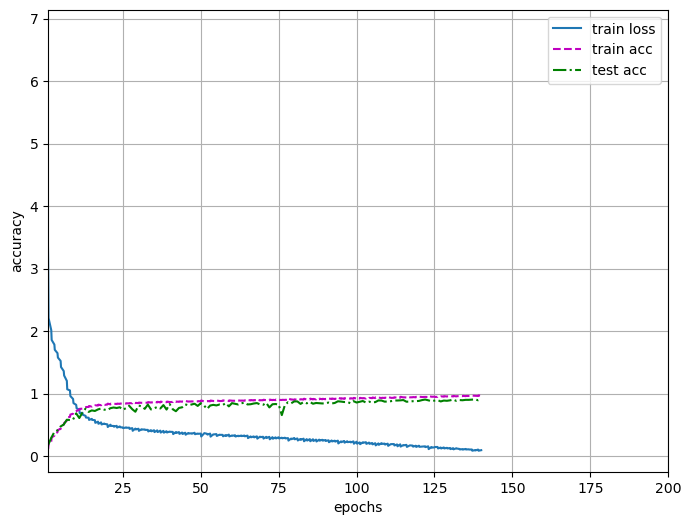

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 140 train loss: 0.095, train accuracy: 0.967, test accuracy 0.892, lr: 0.02061073738537636


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 141 train loss: 0.088, train accuracy: 0.970, test accuracy 0.905, lr: 0.019978988733705814


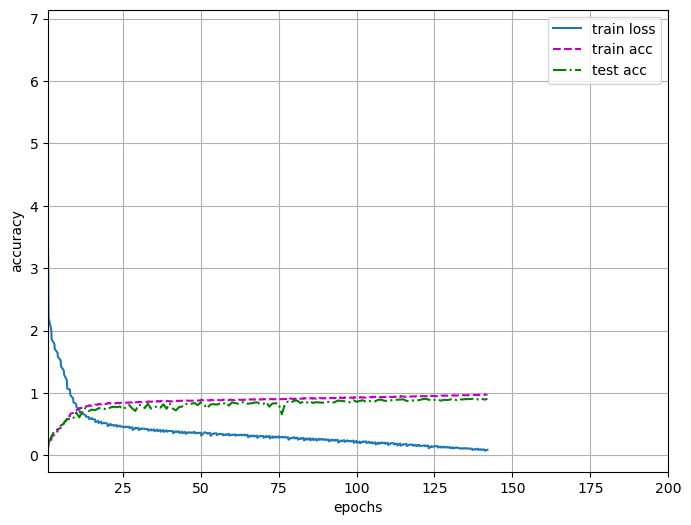

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 142 train loss: 0.084, train accuracy: 0.972, test accuracy 0.916, lr: 0.01935464731735118


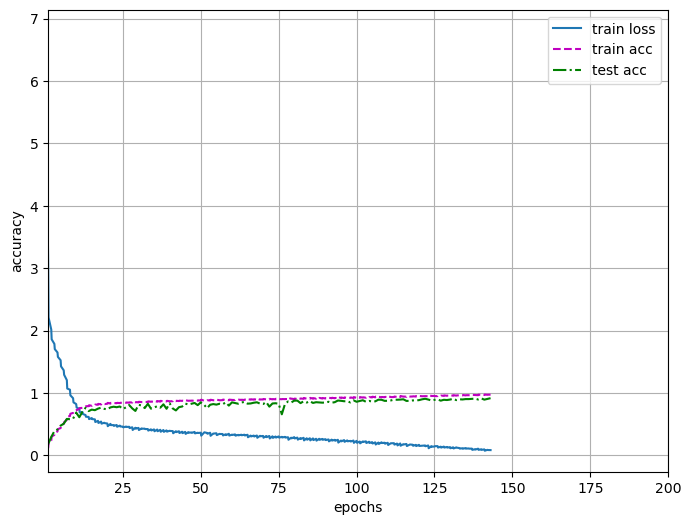

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 143 train loss: 0.082, train accuracy: 0.973, test accuracy 0.912, lr: 0.018737867183214747


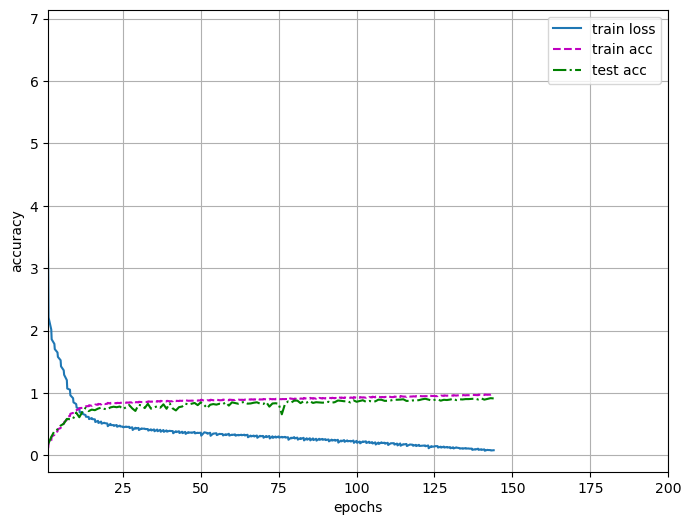

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 144 train loss: 0.081, train accuracy: 0.973, test accuracy 0.912, lr: 0.01812880051256552


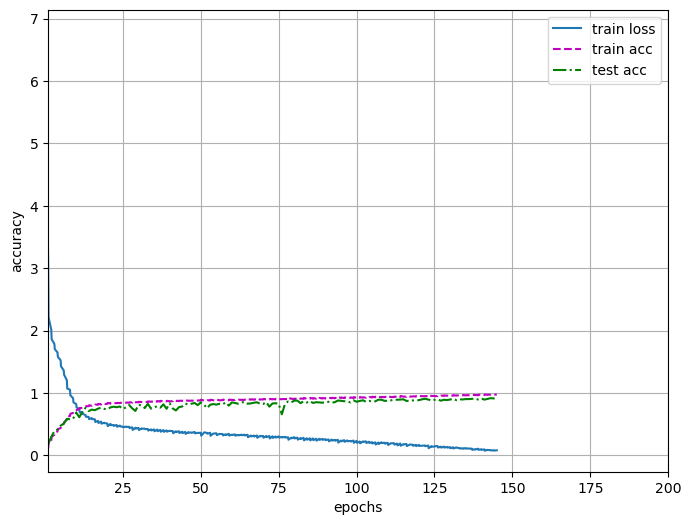

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 145 train loss: 0.072, train accuracy: 0.976, test accuracy 0.916, lr: 0.017527597583490827


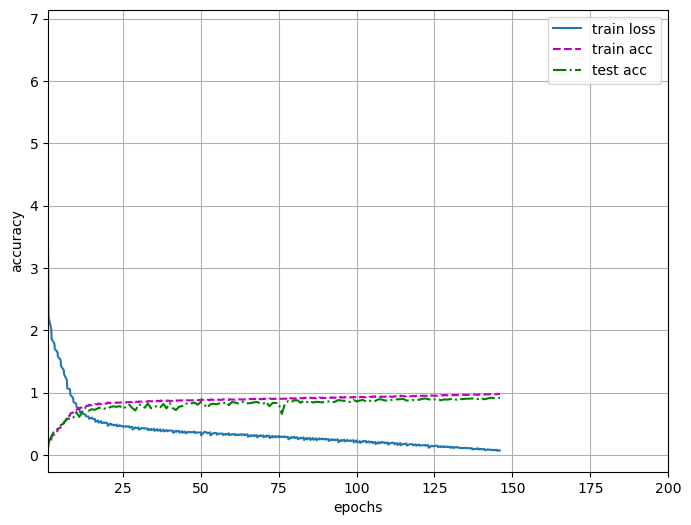

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 146 train loss: 0.075, train accuracy: 0.975, test accuracy 0.917, lr: 0.01693440673381742


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 147 train loss: 0.069, train accuracy: 0.977, test accuracy 0.906, lr: 0.016349374324511334


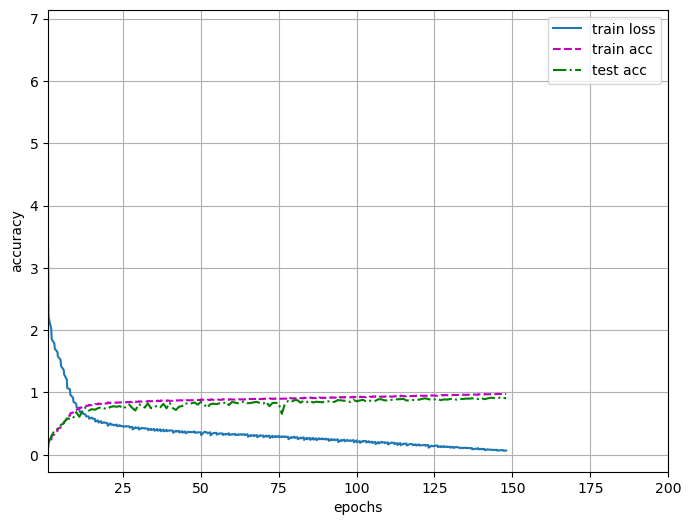

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 148 train loss: 0.067, train accuracy: 0.978, test accuracy 0.909, lr: 0.01577264470356557


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 149 train loss: 0.062, train accuracy: 0.979, test accuracy 0.924, lr: 0.01520436017038429


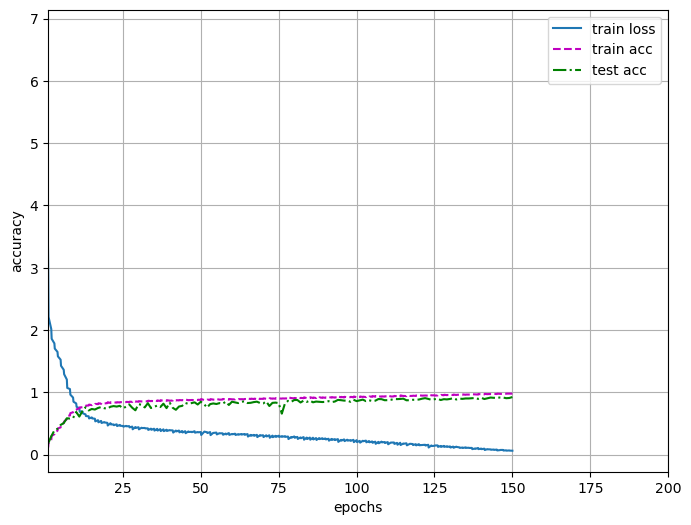

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 150 train loss: 0.057, train accuracy: 0.982, test accuracy 0.924, lr: 0.014644660940672632


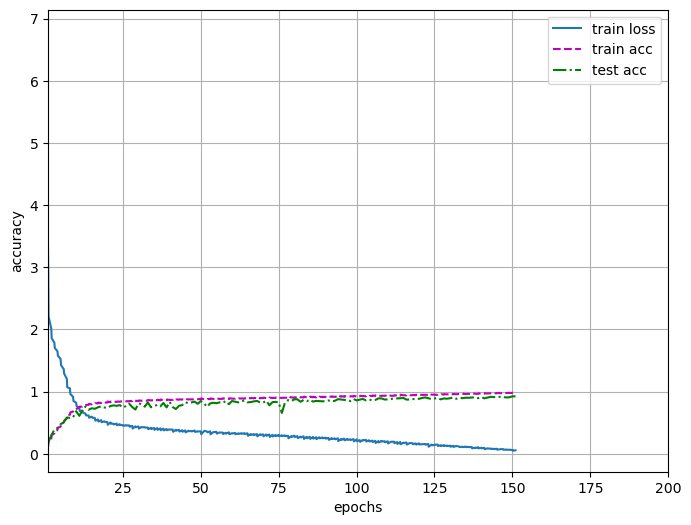

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 151 train loss: 0.054, train accuracy: 0.982, test accuracy 0.913, lr: 0.01409368511184057


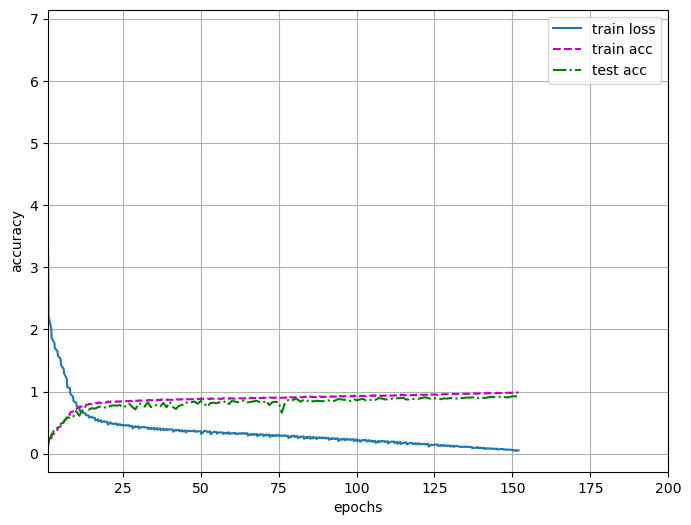

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 152 train loss: 0.051, train accuracy: 0.983, test accuracy 0.922, lr: 0.013551568628929438


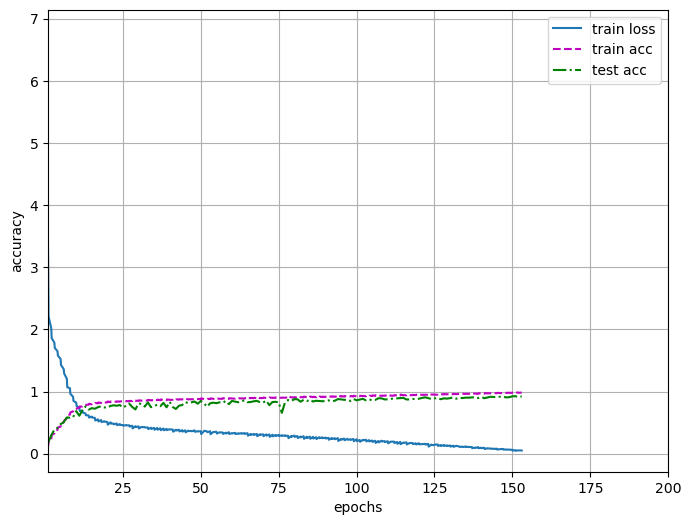

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 153 train loss: 0.050, train accuracy: 0.984, test accuracy 0.919, lr: 0.013018445251069516


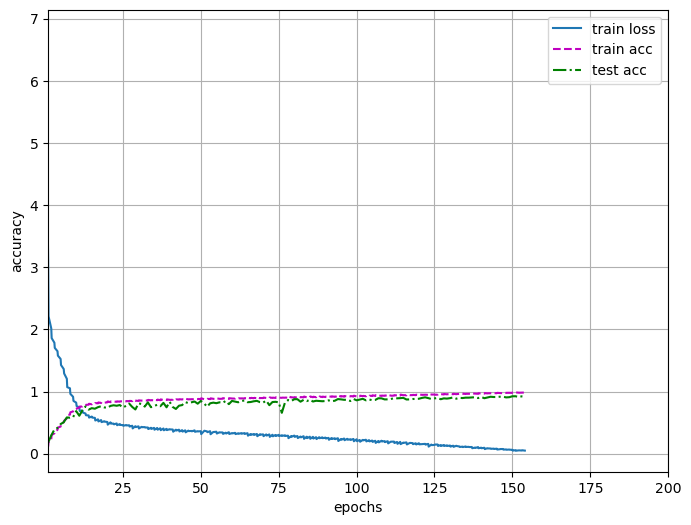

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 154 train loss: 0.048, train accuracy: 0.984, test accuracy 0.920, lr: 0.012494446518477026


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 155 train loss: 0.044, train accuracy: 0.985, test accuracy 0.925, lr: 0.011979701719998459


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 156 train loss: 0.042, train accuracy: 0.986, test accuracy 0.919, lr: 0.011474337861210548


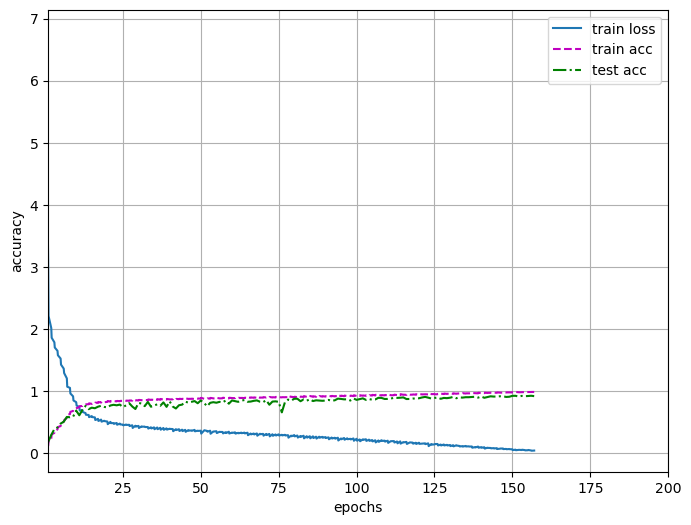

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 157 train loss: 0.037, train accuracy: 0.988, test accuracy 0.927, lr: 0.010978479633083526


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 158 train loss: 0.032, train accuracy: 0.990, test accuracy 0.930, lr: 0.010492249381215483


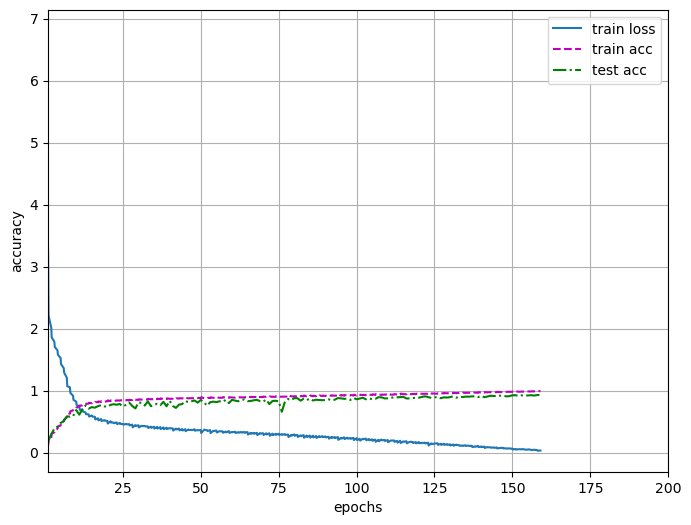

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 159 train loss: 0.031, train accuracy: 0.990, test accuracy 0.931, lr: 0.010015767075645474


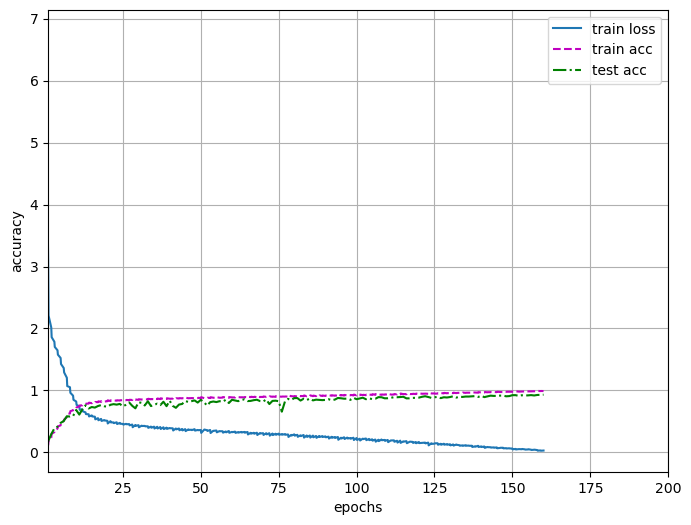

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 160 train loss: 0.029, train accuracy: 0.990, test accuracy 0.921, lr: 0.009549150281252637


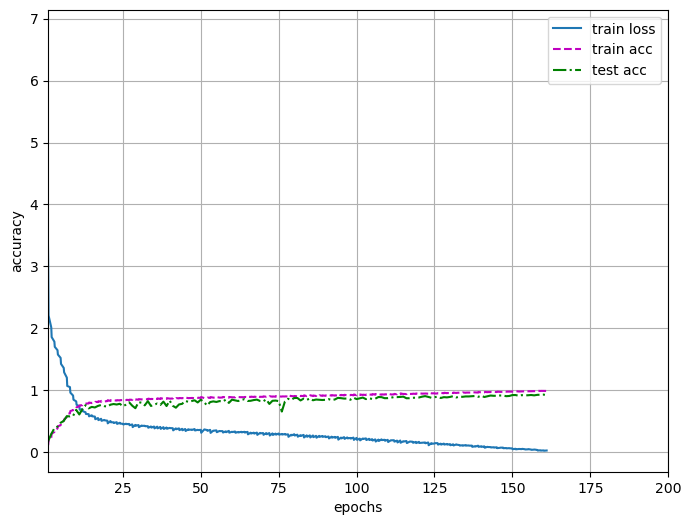

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 161 train loss: 0.026, train accuracy: 0.992, test accuracy 0.927, lr: 0.00909251412874884


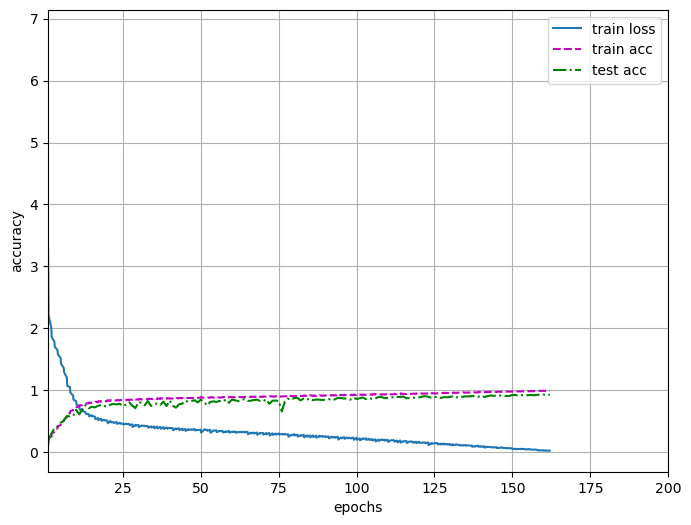

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 162 train loss: 0.021, train accuracy: 0.994, test accuracy 0.926, lr: 0.008645971286271918


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 163 train loss: 0.020, train accuracy: 0.994, test accuracy 0.934, lr: 0.008209631931586501


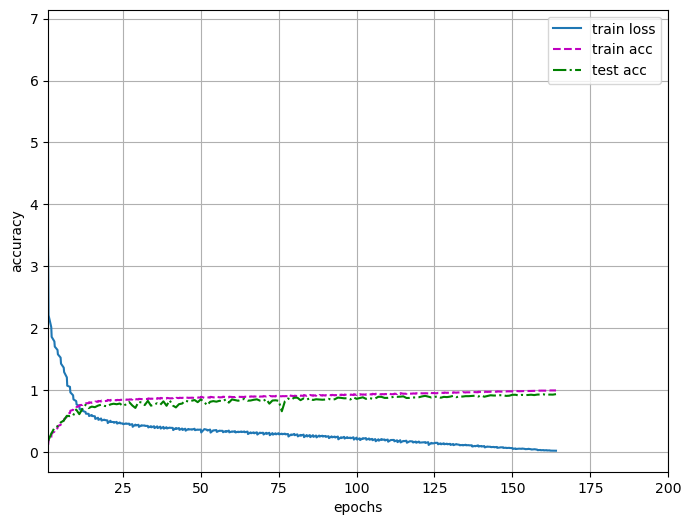

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 164 train loss: 0.017, train accuracy: 0.995, test accuracy 0.934, lr: 0.0077836037248992605


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 165 train loss: 0.017, train accuracy: 0.995, test accuracy 0.937, lr: 0.0073679917822954055


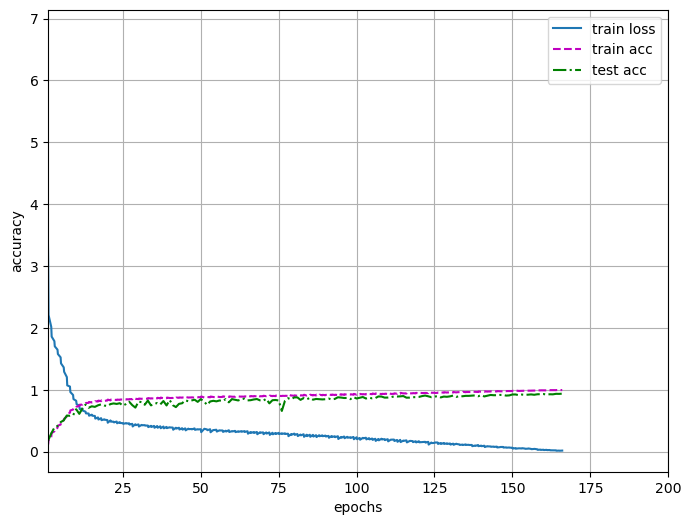

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 166 train loss: 0.014, train accuracy: 0.996, test accuracy 0.936, lr: 0.006962898649802815


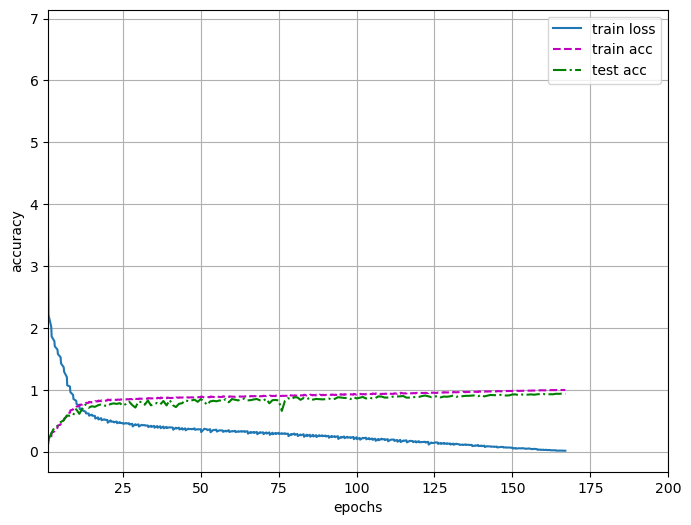

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 167 train loss: 0.011, train accuracy: 0.997, test accuracy 0.943, lr: 0.006568424278090438


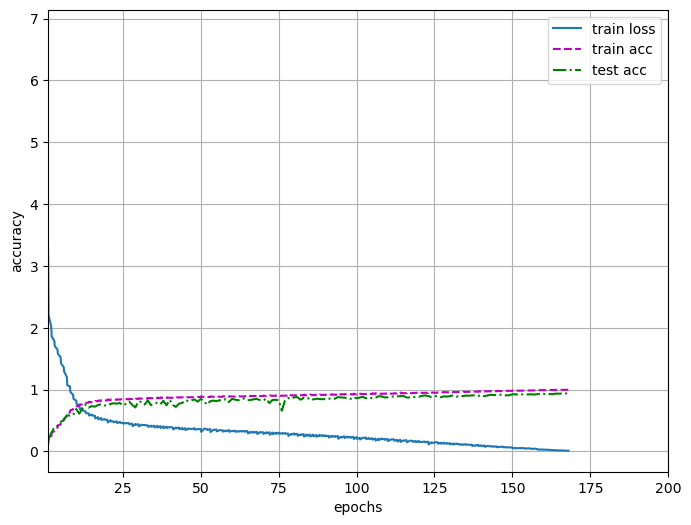

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 168 train loss: 0.010, train accuracy: 0.997, test accuracy 0.939, lr: 0.006184665997806824


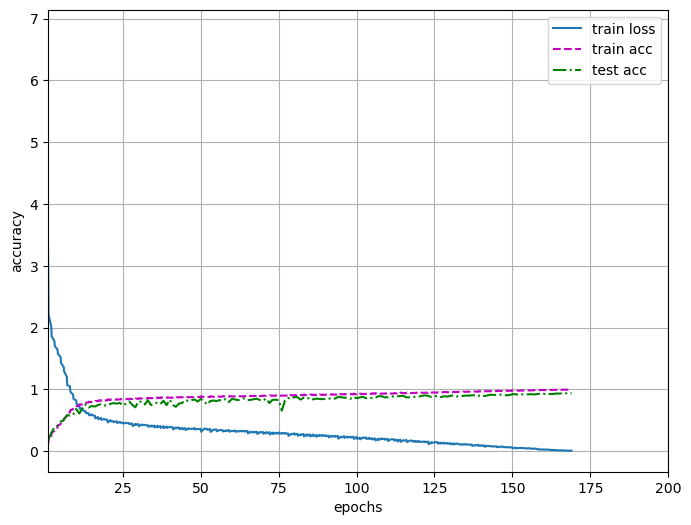

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 169 train loss: 0.011, train accuracy: 0.997, test accuracy 0.940, lr: 0.00581171849556533


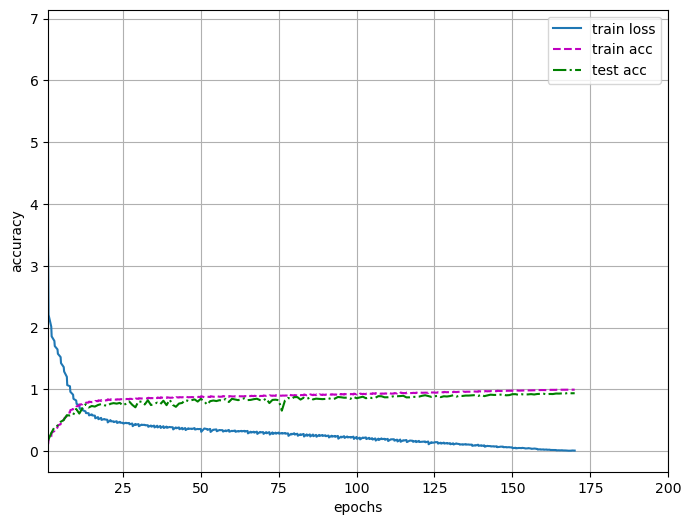

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 170 train loss: 0.007, train accuracy: 0.998, test accuracy 0.941, lr: 0.0054496737905816136


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 171 train loss: 0.007, train accuracy: 0.999, test accuracy 0.943, lr: 0.005098621211969226


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 172 train loss: 0.005, train accuracy: 0.999, test accuracy 0.944, lr: 0.004758647376699035


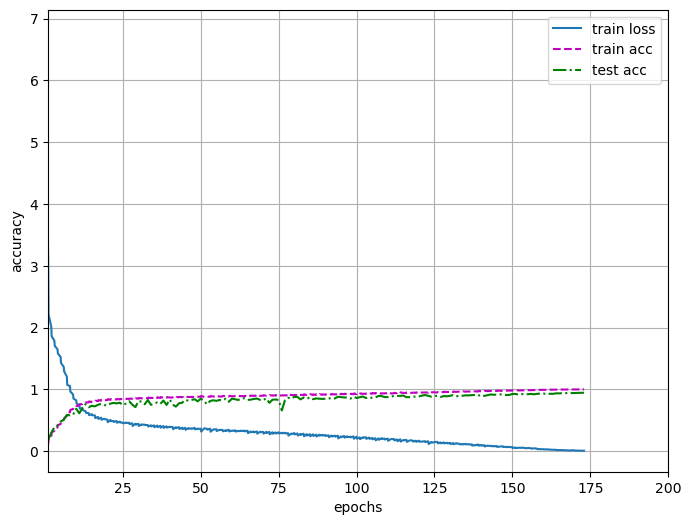

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 173 train loss: 0.006, train accuracy: 0.999, test accuracy 0.945, lr: 0.00442983616822775


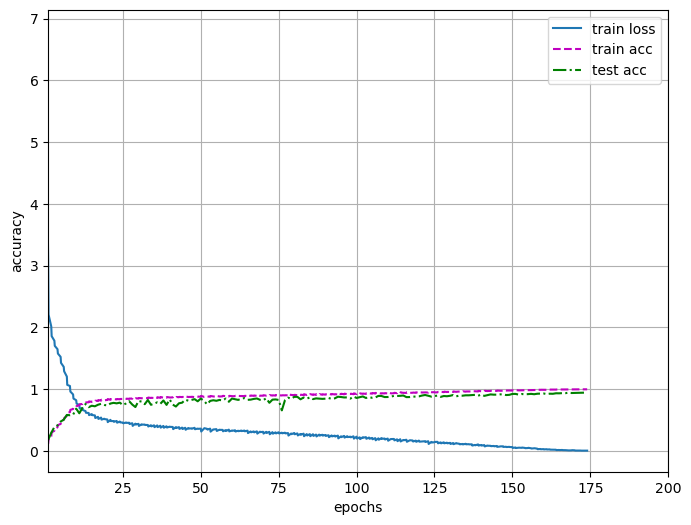

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 174 train loss: 0.004, train accuracy: 0.999, test accuracy 0.946, lr: 0.004112268715800957


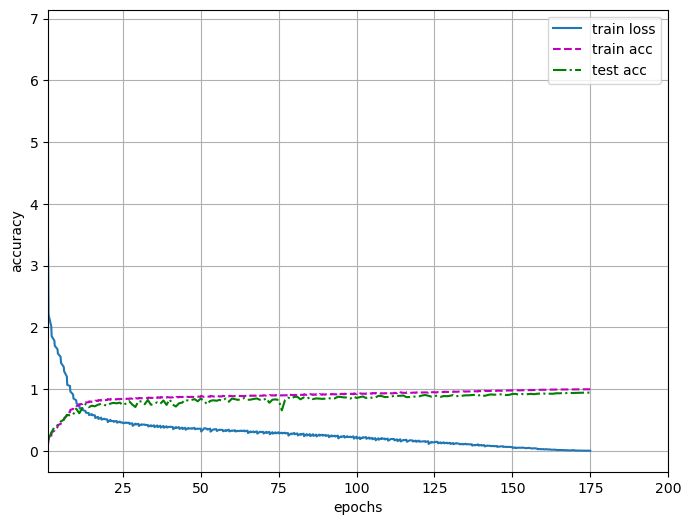

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 175 train loss: 0.003, train accuracy: 0.999, test accuracy 0.948, lr: 0.003806023374435677


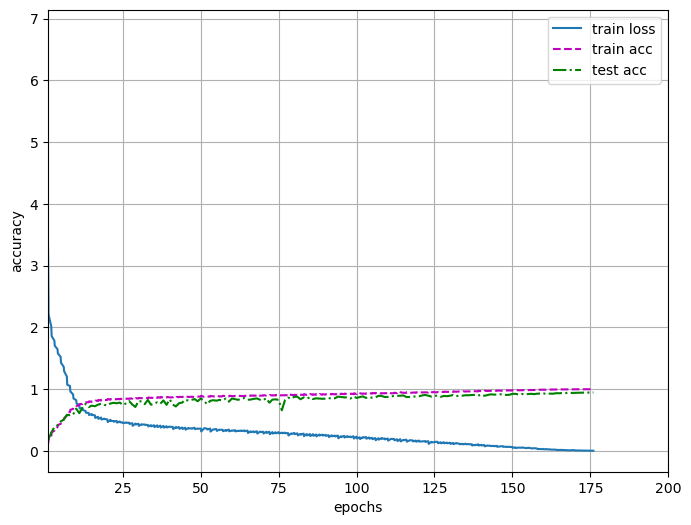

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 176 train loss: 0.003, train accuracy: 1.000, test accuracy 0.948, lr: 0.003511175705587435


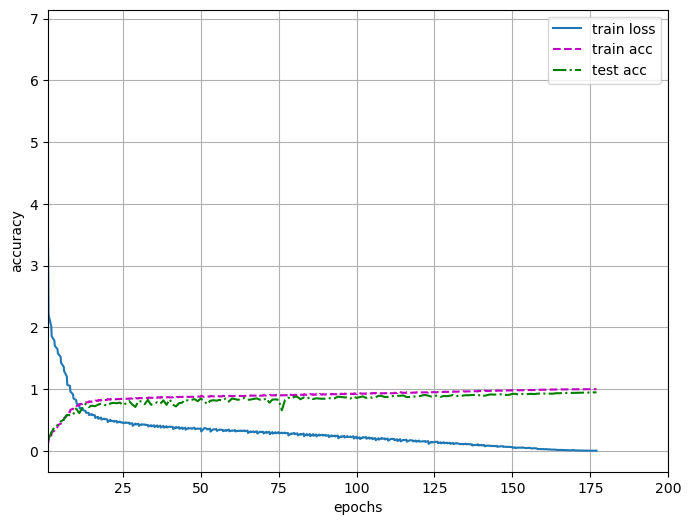

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 177 train loss: 0.003, train accuracy: 0.999, test accuracy 0.949, lr: 0.0032277984585066333


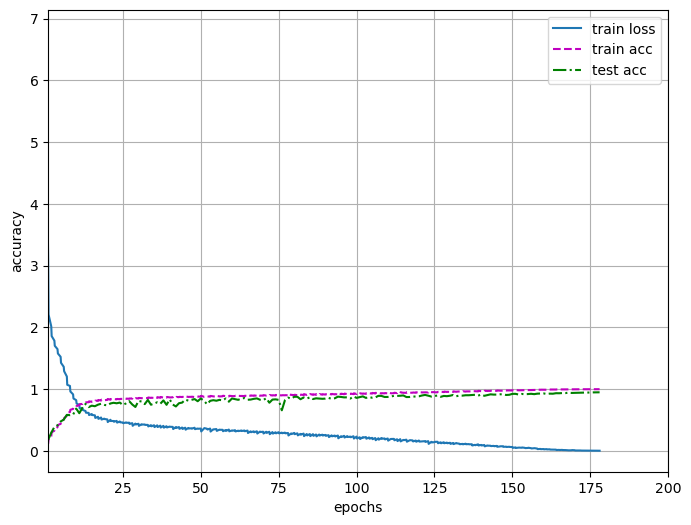

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 178 train loss: 0.003, train accuracy: 1.000, test accuracy 0.948, lr: 0.002955961552288729


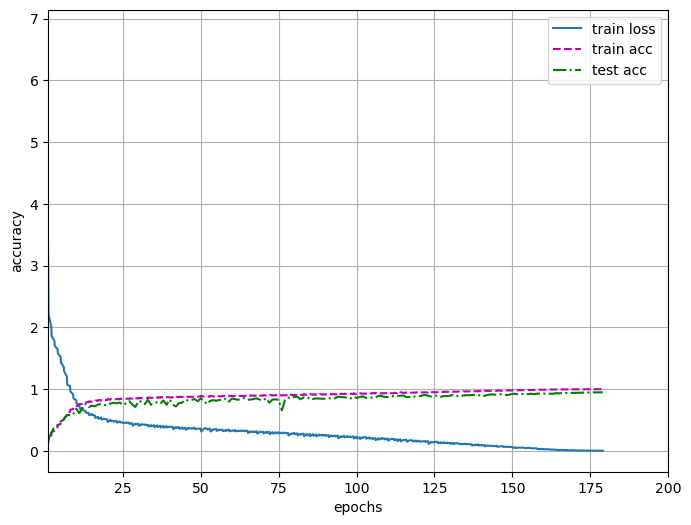

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 179 train loss: 0.002, train accuracy: 1.000, test accuracy 0.949, lr: 0.0026957320586227366


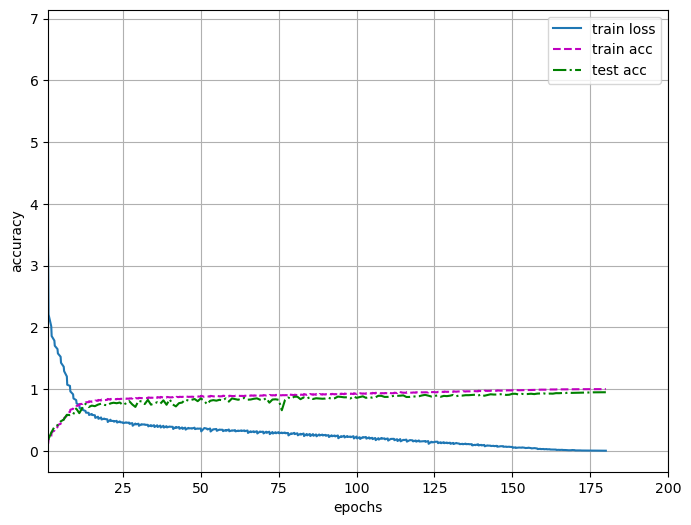

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 180 train loss: 0.002, train accuracy: 1.000, test accuracy 0.948, lr: 0.002447174185242325


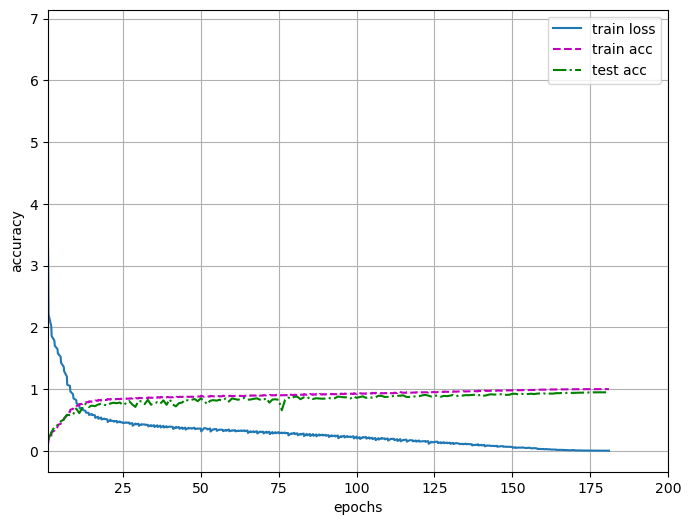

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 181 train loss: 0.002, train accuracy: 1.000, test accuracy 0.949, lr: 0.0022103492600834954


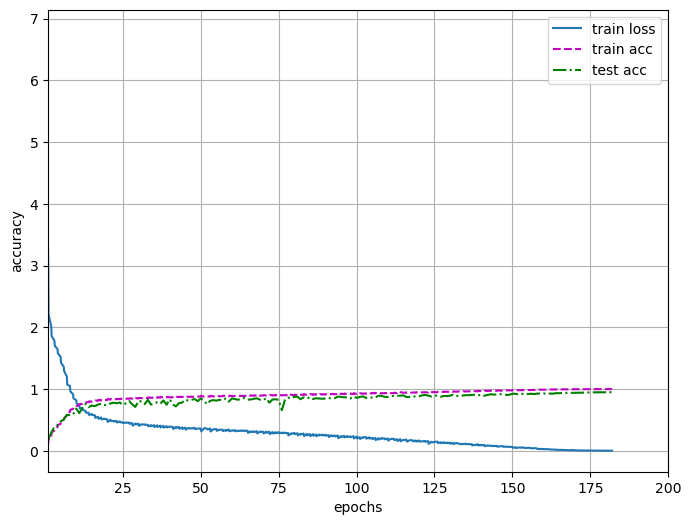

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 182 train loss: 0.002, train accuracy: 1.000, test accuracy 0.951, lr: 0.0019853157161528537


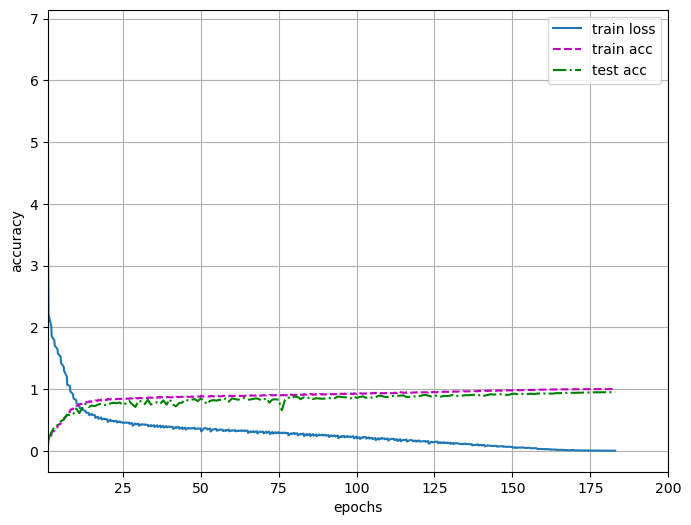

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 183 train loss: 0.002, train accuracy: 1.000, test accuracy 0.951, lr: 0.001772129077110103


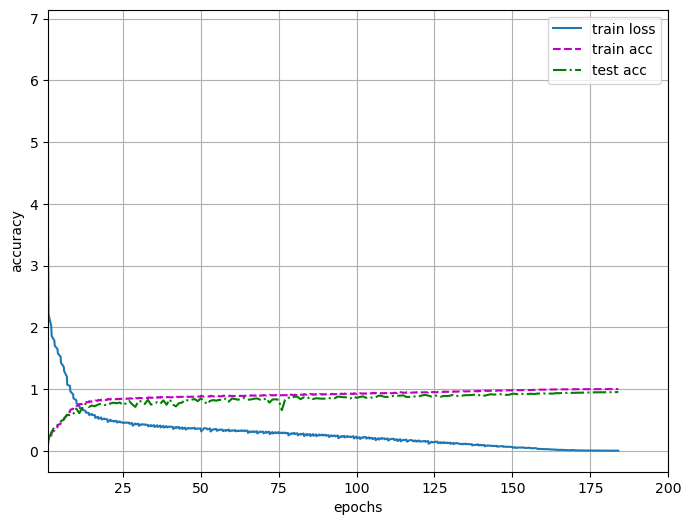

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 184 train loss: 0.002, train accuracy: 1.000, test accuracy 0.951, lr: 0.0015708419435684529


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 185 train loss: 0.002, train accuracy: 1.000, test accuracy 0.951, lr: 0.0013815039801161732


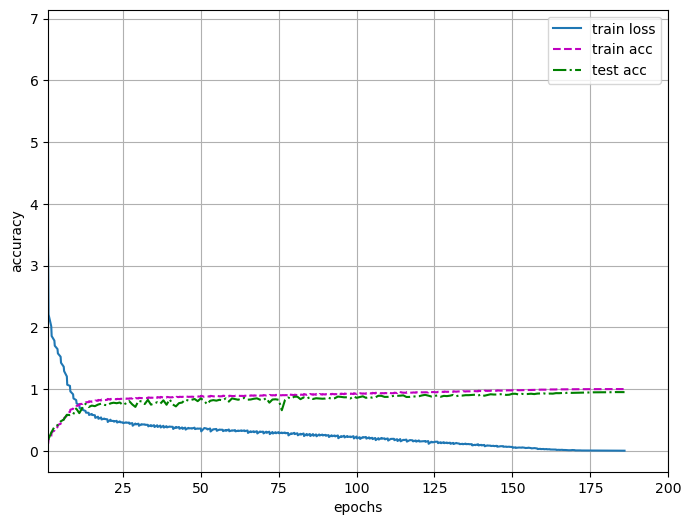

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 186 train loss: 0.002, train accuracy: 1.000, test accuracy 0.951, lr: 0.0012041619030626347


  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 187 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 0.0010388594689117077


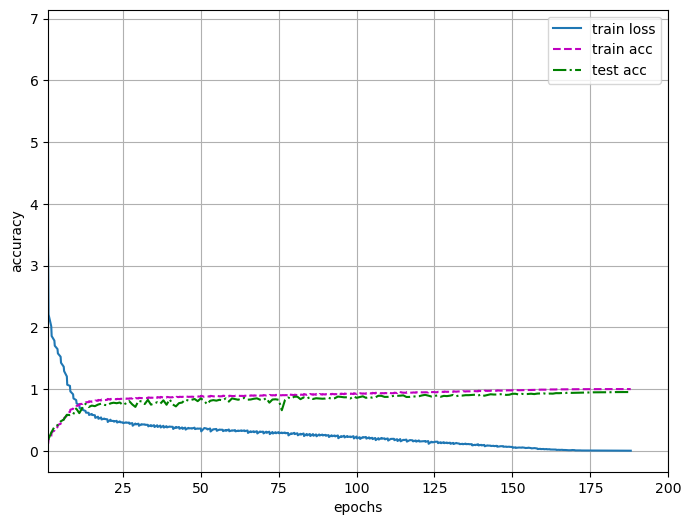

  0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b5c0a0edd80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch: 188 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 0.0008856374635655645


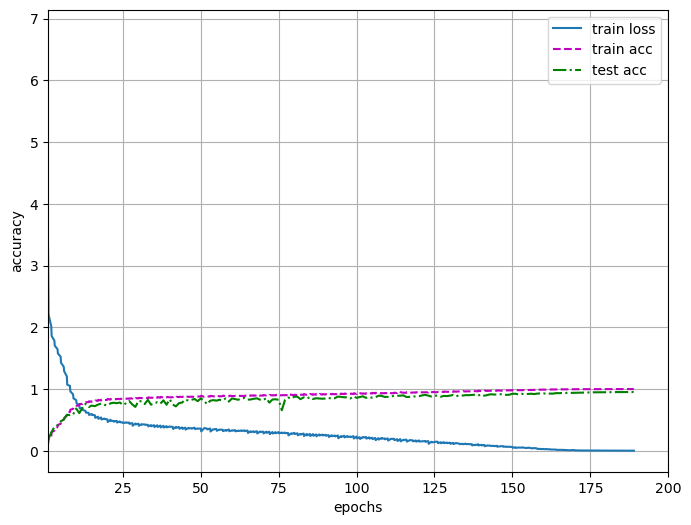

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 189 train loss: 0.002, train accuracy: 1.000, test accuracy 0.951, lr: 0.000744533692261307


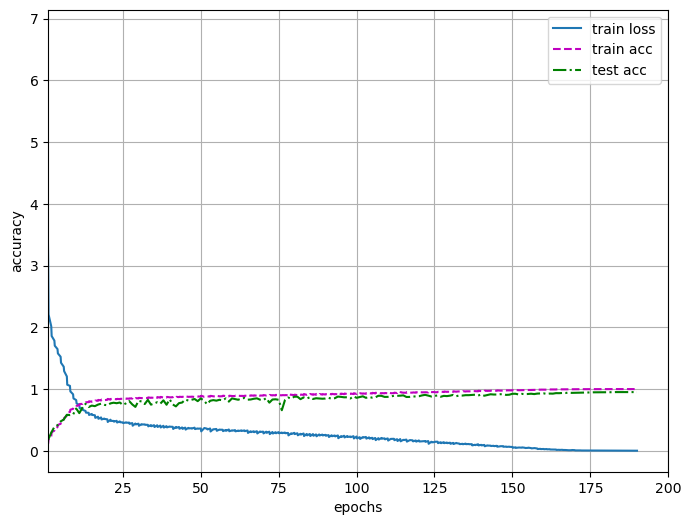

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 190 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 0.0006155829702431174


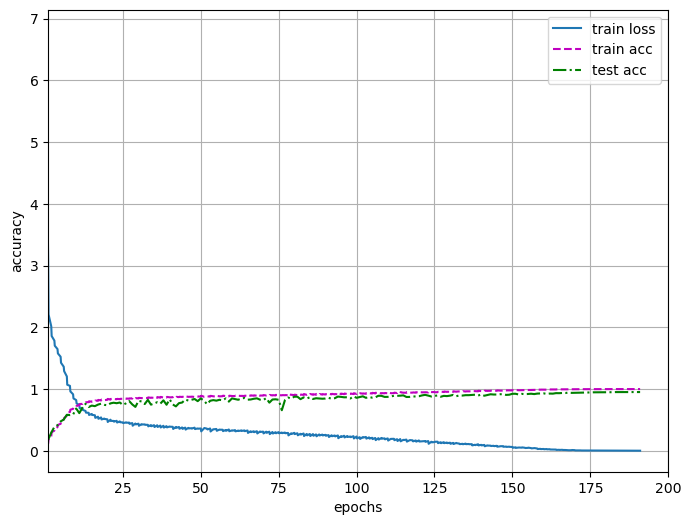

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 191 train loss: 0.002, train accuracy: 1.000, test accuracy 0.953, lr: 0.0004988171141721235


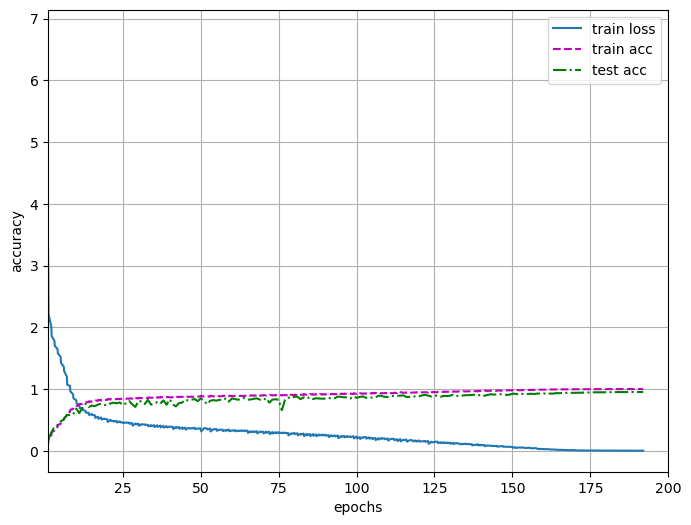

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 192 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 0.00039426493427611206


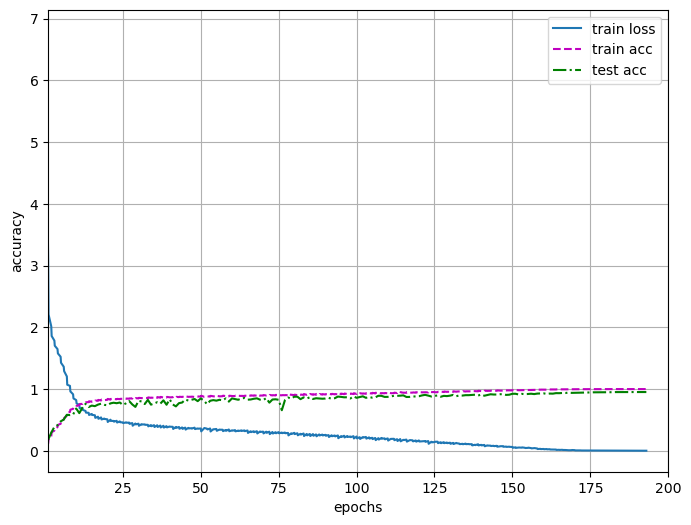

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 193 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 0.00030195222724102046


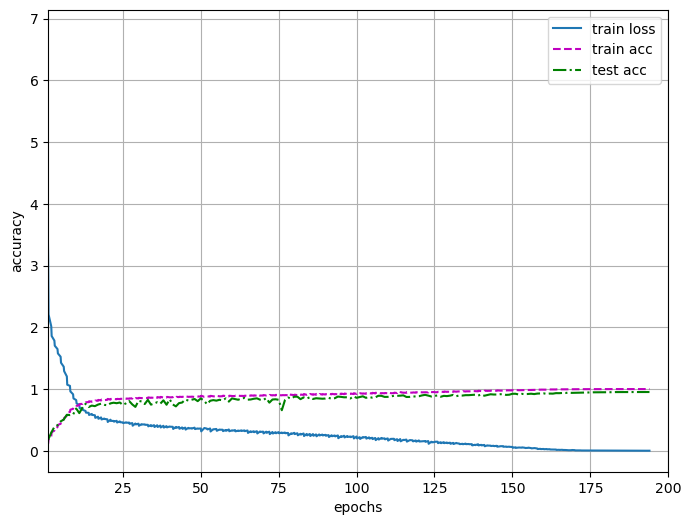

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 194 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 0.00022190176984600036


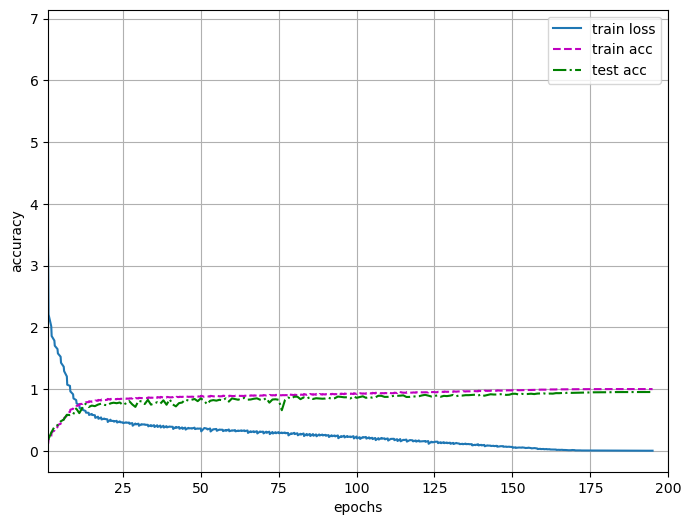

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 195 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 0.00015413331334360192


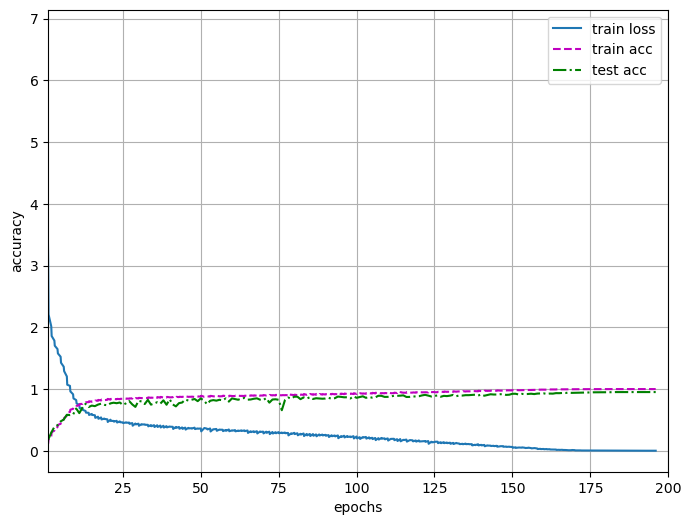

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 196 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 9.866357858642213e-05


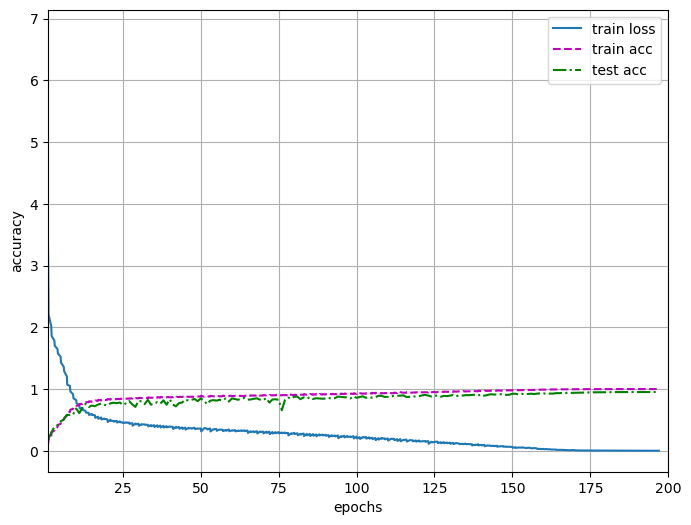

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 197 train loss: 0.002, train accuracy: 1.000, test accuracy 0.951, lr: 5.5506251901504864e-05


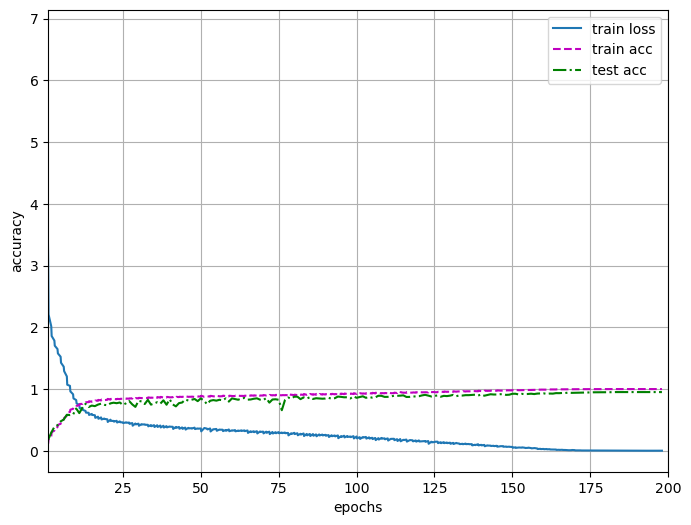

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 198 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 2.4671981713420017e-05


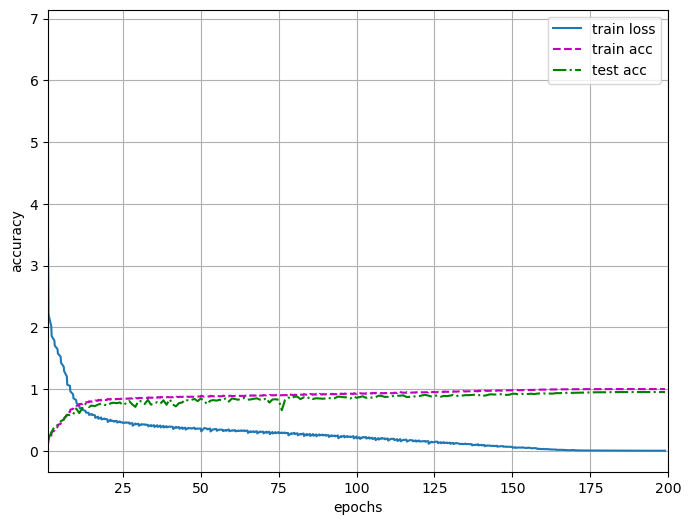

  0%|          | 0/391 [00:00<?, ?it/s]

epoch: 199 train loss: 0.002, train accuracy: 1.000, test accuracy 0.952, lr: 6.168375916970619e-06


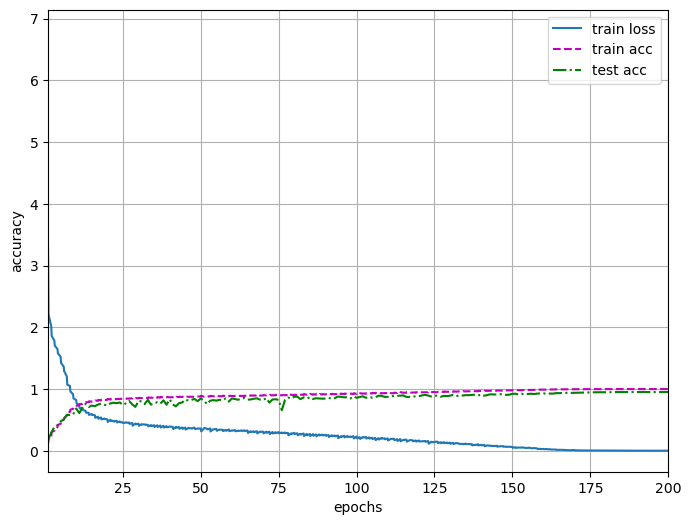

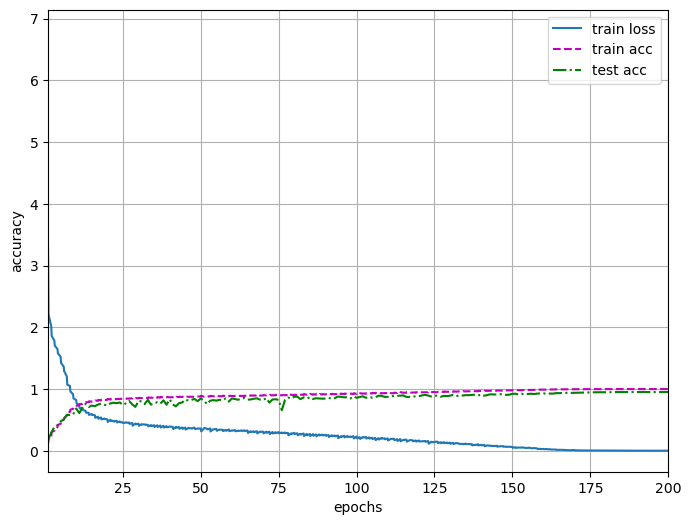

In [43]:
BATCH_SIZE = 128

# transformations = [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
transform_train = [
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]
transform_test = [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
train_iter = load_cifar("~/data", BATCH_SIZE, transformations=transform_train, num_workers=1)
test_iter = load_cifar("~/data", BATCH_SIZE, transformations=transform_test, train=False, num_workers=1)

epochs = 200
lr = 0.1
optim = torch.optim.SGD(resnet_18.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=200)

train_model(
    resnet_18, train_iter, test_iter, epochs, optim, mode="vanilla",
    verbose_interval=1, init_weights=True, scheduler=scheduler
)


### Single representation ResNet 

In [20]:
class SRResNet(nn.Module):
    def __init__(self, input_channels: int, output_size: int, hidden_size: int = 100, n_blocks: int = 10, padding=1):
        super().__init__()

        self.input_l = nn.Conv2d(input_channels, hidden_size, kernel_size=(3, 3), padding=1)
        blocks = OrderedDict()
        for i in range(n_blocks):
            blocks[f"block_{i}"] = ResBlock(hidden_size, hidden_size, padding=padding)

        self.res_blocks = nn.Sequential(blocks)
        # Avg pool transforms into (B, C, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # (B, C * 1 * 1)
        self.flat = nn.Flatten()
        self.out_l = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        # X has dimensions (B, C, W, H)
        out = self.input_l(X)
        out = self.res_blocks(out)
        out = self.flat(self.avgpool(out))

        return self.out_l(out)


SRResNet(
  (input_l): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (res_blocks): Sequential(
    (block_0): ResBlock(
      (conv_1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
      (conv_2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
      (batch_n_1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_n_2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block_1): ResBlock(
      (conv_1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
      (conv_2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
      (batch_n_1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_n_2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block_2): ResBlock(
      (conv_1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
      (conv_2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
   

In [24]:
sr = SRResNet(3, 10)
sum([p.nelement() for p in sr.parameters()])


1809810